<a href="https://colab.research.google.com/github/areegtarek/ELO-Merchant-Category-Prediction/blob/main/ELO_Merchant_Category_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Merchant Category Prediction**

cartao-elo.avif

Elo, one of the largest payment brands in Brazil, has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the Notebook is to identify and serve the most relevant opportunities to individuals, by uncovering signal in customer loyalty.

# **Dataset Description**

The **historical_transactions.csv** and **new_merchant_transactions.csv** files contain information about each card's transactions. **historical_transactions.csv** contains up to 3 months' worth of transactions for every card at any of the provided merchant_ids. **new_merchant_transactions.csv** contains the transactions at new merchants (merchant_ids that this particular card_id has not yet visited) over a period of two months.

**merchants.csv** contains aggregate information for each merchant_id represented in the data set.

## **What should I expect the data format to be?**
**The data is formatted as follows:**

**user_score.csv** contain card_ids and information about the card itself - the first month the card was active, etc.

**historical_transactions.csv** and **new_merchant_transactions.csv** are designed to be joined with **user_score.csv** , and **merchants.csv** . They contain information about transactions for each card, as described above.

merchants can be joined with the transaction sets to provide additional merchant-level information.



## **File descriptions**
**userscore.csv:**
- card_id: A unique identifier for each card
- first_active_month: The month in which the card was first used
- feature_1: An anonymized categorical feature related to the card
- feature_2: An anonymized categorical feature related to the card
- feature_3: An anonymized categorical feature related to the card
- score: The loyalty score for each card, which is the target variable for prediction.

**merchants.csv:**

- merchant_id: A unique identifier for each merchant
- merchant_group_id: An anonymized categorical feature indicating the merchant group to which the merchant belongs
- merchant_category_id: An anonymized categorical feature indicating the type of merchant (e.g., department store, restaurant, etc.)
- subsector_id: An anonymized categorical feature indicating the subsector to which the merchant belongs
- numerical_1: A numerical feature related to the merchant
- numerical_2: A numerical feature related to the merchant
- category_1: An anonymized categorical feature related to the merchant
- most_recent_sales_range: An anonymized categorical feature indicating the sales volume of the merchant in the most recent period
- most_recent_purchases_range: An anonymized categorical feature indicating the number of purchases made at the merchant in the most recent period
- avg_sales_lag3: A numerical feature indicating the average sales volume of the merchant over the previous3 months
- avg_purchases_lag3: A numerical feature indicating the average number of purchases made at the merchant over the previous 3 months
- active_months_lag3: A numerical feature indicating the number of months in the previous 3 months during which the merchant had sales
- avg_sales_lag6: A numerical feature indicating the average sales volume of the merchant over the previous 6 months
- avg_purchases_lag6: A numerical feature indicating the average number of purchases made at the merchant over the previous 6 months
- active_months_lag6: A numerical feature indicating the number of months in the previous 6 months during which the merchant had sales
- avg_sales_lag12: A numerical feature indicating the average sales volume of the merchant over the previous 12 months
- avg_purchases_lag12: A numerical feature indicating the average number of purchases made at the merchant over the previous 12 months
- active_months_lag12: A numerical feature indicating the number of months in the previous 12 months during which the merchant had sales.

**historical transactions.csv and new merchant transactions.csv:**
- card_id: A unique identifier for each card
- merchant_id: A unique identifier for each merchant
- month_lag: A numerical feature indicating the number of months between the transaction and the reference date (i.e., the last month in the dataset)
- purchase_amount: A numerical feature indicating the amount of the transaction in USD- authorized_flag: A binary feature indicating whether the transaction was authorized or not (Y/N)
- category_1: A binary feature indicating whether the transaction was made in a category 1 merchant or not (Y/N)
- category_2: An anonymized categorical feature indicating the type of category 2 merchant in which the transaction was made
- category_3: An anonymized categorical feature indicating the type of category 3 merchant in which the transaction was made.

In [ ]:
!pip install missingno

In [ ]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import time
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder,LabelEncoder, RobustScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Set Pandas display option to show floats with 10 decimal places
pd.set_option('display.float_format', '{:.10f}'.format)

# Set Seaborn style to 'ggplot'
plt.style.use('ggplot')

In [ ]:
# Read in the dataframes
usersc_df = pd.read_csv("userscore.csv")
merch_df = pd.read_csv('merchants.csv')
hist_trans_df = pd.read_csv('historical_transactions.csv')
new_trans_df = pd.read_csv('new_merchant_transactions.csv')

## **Loyalty Score Data Analysis:**

In [ ]:
usersc_df.head()

card_id first_active_month  feature_1  feature_2  feature_3   
0  C_ID_92a2005557             Jun-17          5          2          1  \
1  C_ID_3d0044924f             Jan-17          4          1          0   
2  C_ID_d639edf6cd             Aug-16          2          2          0   
3  C_ID_186d6a6901             Sep-17          4          3          0   
4  C_ID_cdbd2c0db2             Nov-17          1          3          0   

          score  
0 -0.8202826000  
1  0.3929132500  
2  0.6880559900  
3  0.1424952000  
4 -0.1597491900

In [ ]:
# Convert the date column to datetime format
usersc_df['first_active_month'] = pd.to_datetime(usersc_df['first_active_month'], format='%b-%y')

In [ ]:
usersc_df.head()

card_id first_active_month  feature_1  feature_2  feature_3   
0  C_ID_92a2005557         2017-06-01          5          2          1  \
1  C_ID_3d0044924f         2017-01-01          4          1          0   
2  C_ID_d639edf6cd         2016-08-01          2          2          0   
3  C_ID_186d6a6901         2017-09-01          4          3          0   
4  C_ID_cdbd2c0db2         2017-11-01          1          3          0   

          score  
0 -0.8202826000  
1  0.3929132500  
2  0.6880559900  
3  0.1424952000  
4 -0.1597491900

### **Check Missing Values**

In [ ]:
usersc_df.isna().sum()

card_id               0
first_active_month    0
feature_1             0
feature_2             0
feature_3             0
score                 0
dtype: int64

**Observations** There is no nulls values

In [ ]:
usersc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   card_id             201917 non-null  object        
 1   first_active_month  201917 non-null  datetime64[ns]
 2   feature_1           201917 non-null  int64         
 3   feature_2           201917 non-null  int64         
 4   feature_3           201917 non-null  int64         
 5   score               201917 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.2+ MB


In [ ]:
usersc_df.describe()

first_active_month         feature_1         feature_2   
count                         201917 201917.0000000000 201917.0000000000  \
mean   2017-01-15 00:30:16.001624320      3.1053105979      1.7454102428   
min              2011-11-01 00:00:00      1.0000000000      1.0000000000   
25%              2016-10-01 00:00:00      2.0000000000      1.0000000000   
50%              2017-04-01 00:00:00      3.0000000000      2.0000000000   
75%              2017-09-01 00:00:00      4.0000000000      2.0000000000   
max              2018-02-01 00:00:00      5.0000000000      3.0000000000   
std                              NaN      1.1861595849      0.7513617363   

              feature_3             score  
count 201917.0000000000 201917.0000000000  
mean       0.5655690209     -0.3936362991  
min        0.0000000000    -33.2192809500  
25%        0.0000000000     -0.8831102300  
50%        1.0000000000     -0.0234368900  
75%        1.0000000000      0.7654530300  
max        1.0000000000     17.9650684000  
std        0.4956832863      3.8504999955

For the "first_active_month" column, NaN is shown because the standard deviation of date values does not make sense and is not calculated.

It is worth noting that calculating the mean of date values does not always make sense, as dates do not have a natural zero point. In some cases, it may be more appropriate to use other metrics, such as the median or mode, to summarize the central tendency of date values.

In [ ]:
usersc_df.duplicated().sum()

0

**Observations** There is no duplicated values

### **Check Normality and Outliers**

### **loyalty score**

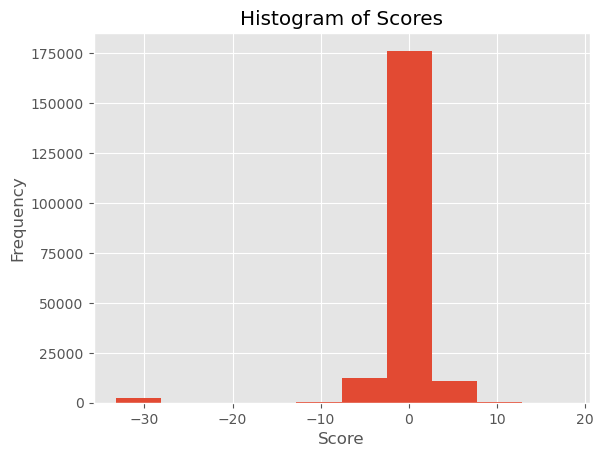

In [ ]:
# Draw a histogram of the "score" column
usersc_df['score'].hist()

# Set the title and axis labels
plt.title('Histogram of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Show the plot
plt.show()

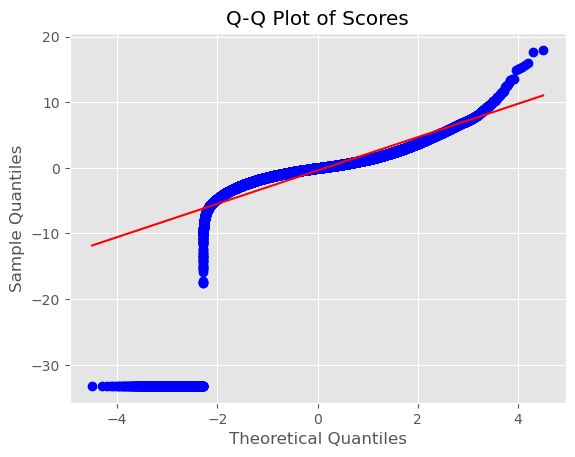

In [ ]:
# Generate a Q-Q plot for the "score" column
stats.probplot(usersc_df['score'], plot=plt)

# Set the title and axis labels
plt.title('Q-Q Plot of Scores')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Show the plot
plt.show()

In [ ]:
# Count the values of the "score" column
# Count the values of the "score" column
counts = usersc_df['score'].value_counts()

# Calculate the percentages of values in different ranges
total_count = len(usersc_df)
range_a_count = len(usersc_df.loc[(usersc_df['score'] >= -30) & (usersc_df['score'] < -10)])
range_b_count = len(usersc_df.loc[(usersc_df['score'] >= -10) & (usersc_df['score'] < 0)])
range_c_count = len(usersc_df.loc[(usersc_df['score'] >= 0) & (usersc_df['score'] <= 10)])
range_d_count = len(usersc_df.loc[(usersc_df['score'] > -1) & (usersc_df['score'] < 1)])
range_e_count = len(usersc_df.loc[(usersc_df['score'] >= -1) & (usersc_df['score'] < 0)])
range_f_count = len(usersc_df.loc[(usersc_df['score'] >= 0) & (usersc_df['score'] <= 1)])
range_a_percent = range_a_count / total_count * 100
range_b_percent = range_b_count / total_count * 100
range_c_percent = range_c_count / total_count * 100
range_d_percent = range_d_count / total_count * 100
range_e_percent = range_e_count / total_count * 100
range_f_percent = range_f_count / total_count * 100

# Print the results
print('Value Counts:')
print(counts)
print('Percentages:')
print('Values between -30 and -10:', round(range_a_percent, 2), '%')
print('Values between -10 and 0:', round(range_b_percent, 2), '%')
print('Values between 0 and 10:', round(range_c_percent, 2), '%')
print('Values between -1 and 1:', round(range_d_percent, 2), '%')
print('Values between -1 and 0:', round(range_e_percent, 2), '%')
print('Values between 0 and 1:', round(range_f_percent, 2), '%')

Value Counts:
score
-33.2192809500    2207
0.0000000000      1630
1.0000000000       117
-1.0000000000       81
-0.5849625000       35
                  ... 
-1.1991465400        1
0.4916790500         1
0.9916803300         1
-2.0061117800        1
-1.8594130100        1
Name: count, Length: 197110, dtype: int64
Percentages:
Values between -30 and -10: 0.03 %
Values between -10 and 0: 49.73 %
Values between 0 and 10: 49.12 %
Values between -1 and 1: 57.03 %
Values between -1 and 0: 28.24 %
Values between 0 and 1: 28.89 %


In [ ]:
# Calculate the number of values below -30
num_below_30 = len(usersc_df.loc[usersc_df['score'] < -30])

# Calculate the percentage of values below -30
percentage_below_30 = (num_below_30 / len(usersc_df)) * 100

# Calculate the number of values over -30
num_over_30 = len(usersc_df.loc[usersc_df['score'] >= -30])

# Calculate the percentage of values over -30
percentage_over_30 = (num_over_30 / len(usersc_df)) * 100

# Print the results
print(f'Number of values below -30: {num_below_30}')
print(f'Percentage of values below -30: {percentage_below_30:.2f}%')
print(f'Number of values over or equal to -30: {num_over_30}')
print(f'Percentage of values over or equal to -30: {percentage_over_30:.2f}%')

Number of values below -30: 2207
Percentage of values below -30: 1.09%
Number of values over or equal to -30: 199710
Percentage of values over or equal to -30: 98.91%


**Observations**

From loyalty score distribution in a dataset:
it seems that the loyalty scores are not normally distributed, but are mostly centered around 0 and have a relatively normal distribution, except for a small number of outliers with very low scores that may require further investigation.

**The ranges and their corresponding percentages are:**

- Values between -30 and -10: 0.03%
- Values between -10 and 0: 49.73%
- Values between 0 and 10: 49.12%
- Values between -1 and 1: 57.03%
- Values between -1 and 0: 28.24%
- Values between 0 and 1: 28.89%

The number of values below -30 is 2207, accounting for 1.09% of the total values. It seems to be an outliers but we needed to investigate if we can remove these points or not

The number of values over or equal to -30 is 199710, accounting for 98.91% of the total values.

### ***Univariante Analysis***

In [ ]:
print(usersc_df['feature_1'].unique()); print(usersc_df['feature_2'].unique()); print(usersc_df['feature_3'].unique())

[5 4 2 1 3]
[2 1 3]
[1 0]


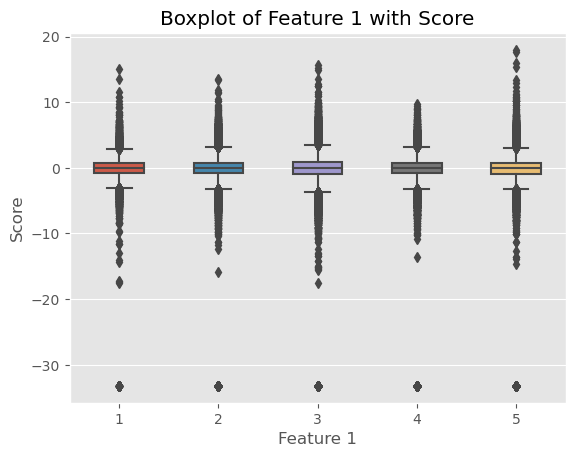

In [ ]:
# Create a boxplot of feature_1 with score
sns.boxplot(x='feature_1', y='score', data=usersc_df, width=0.5)

# Set the plot title and labels
plt.title('Boxplot of Feature 1 with Score')
plt.xlabel('Feature 1')
plt.ylabel('Score')

# Show the plot
plt.show()

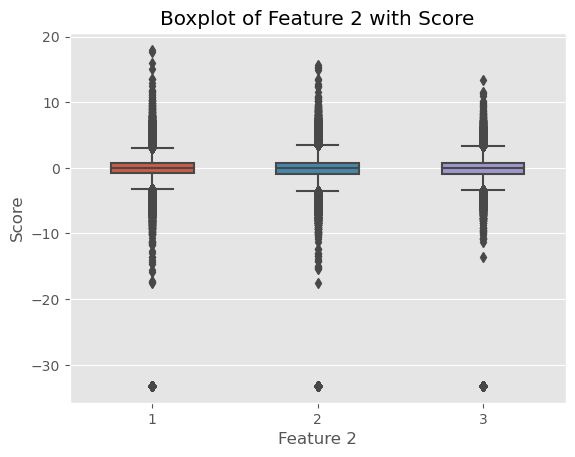

In [ ]:
# Create a boxplot of feature_1 with score
sns.boxplot(x='feature_2', y='score', data=usersc_df, width=0.5)

# Set the plot title and labels
plt.title('Boxplot of Feature 2 with Score')
plt.xlabel('Feature 2')
plt.ylabel('Score')

# Show the plot
plt.show()

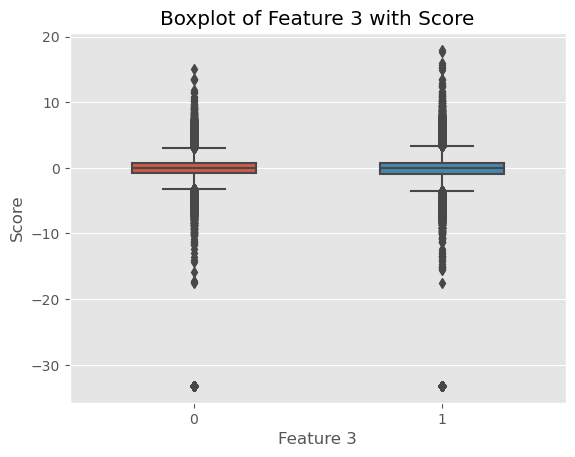

In [ ]:
# Create a boxplot of feature_1 with score
sns.boxplot(x='feature_3', y='score', data=usersc_df, width=0.5)

# Set the plot title and labels
plt.title('Boxplot of Feature 3 with Score')
plt.xlabel('Feature 3')
plt.ylabel('Score')

# Show the plot
plt.show()

**Observations** 
Categorical features feature_1,feature_2 and feature_3 are almost equally important for loyalty score prediction as it has spread equally. Also one thing is common in all the features are few points are above -30 which may not be the outliers and having significant impact on evaluation.

In [ ]:
'''# Create data for the pie chart
# Set up the plot
fig, ax = plt.subplots()

# Create the pie chart
ax.pie(usersc_df['feature_1'], startangle=90, counterclock=False, labeldistance=1.1, autopct='%1.1f%%')
ax.pie(usersc_df['feature_2'], startangle=90, counterclock=False, labeldistance=0.8, autopct='%1.1f%%')
ax.pie(usersc_df['feature_3'], startangle=90, counterclock=False, labeldistance=0.5, autopct='%1.1f%%')

# Add a title and legend
ax.set_title('Pie chart of Three Features')
ax.legend(['Feature_1', 'Feature_2', 'Feature_3'], loc='upper right')
# Show the plot
plt.show()'''

"# Create data for the pie chart\n# Set up the plot\nfig, ax = plt.subplots()\n\n# Create the pie chart\nax.pie(usersc_df['feature_1'], startangle=90, counterclock=False, labeldistance=1.1, autopct='%1.1f%%')\nax.pie(usersc_df['feature_2'], startangle=90, counterclock=False, labeldistance=0.8, autopct='%1.1f%%')\nax.pie(usersc_df['feature_3'], startangle=90, counterclock=False, labeldistance=0.5, autopct='%1.1f%%')\n\n# Add a title and legend\nax.set_title('Pie chart of Three Features')\nax.legend(['Feature_1', 'Feature_2', 'Feature_3'], loc='upper right')\n# Show the plot\nplt.show()"

**Observations**

We have 5 categories for feature_1 column, 3 categories for feature_2 column and 2 categories for feature_3 column. As these columns are categorical column we need to one hot encoded it before model training. Above pie plots showing percentages of categories for each of the future respectively.

In [ ]:
# Find the low date and high date for "first_active_month"
low_date = usersc_df['first_active_month'].min()
high_date = usersc_df['first_active_month'].max()

# Print the low date and high date
print('Low date:', low_date)
print('High date:', high_date)

Low date: 2011-11-01 00:00:00
High date: 2018-02-01 00:00:00


**Observations** The cards are activated between ‘2011’ to ‘2018’ for period of 7 
s.

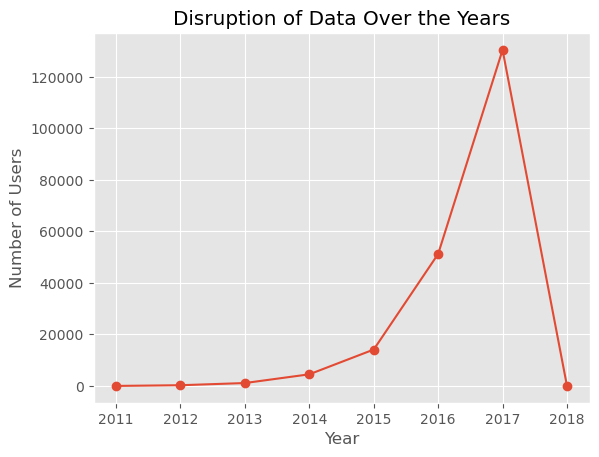

In [ ]:
# Extract the year from the 'first_active_month' column and create a new 'year' column
usersc_df['year'] = usersc_df['first_active_month'].dt.year
usersc_df['month'] = usersc_df['first_active_month'].dt.month

# Count the number of users in each year and sort the values by year
year_count = usersc_df['year'].value_counts().sort_index()

# Plot the data using a line chart
plt.plot(year_count.index, year_count.values, marker='o')

# Add a title and axis labels to the plot
plt.title('Disruption of Data Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Users')

# Show the plot
plt.show()

**Observations** Most of cards are activated in period of 2016 to 2018, as compared to previous years.

### **Correlation Analysis**

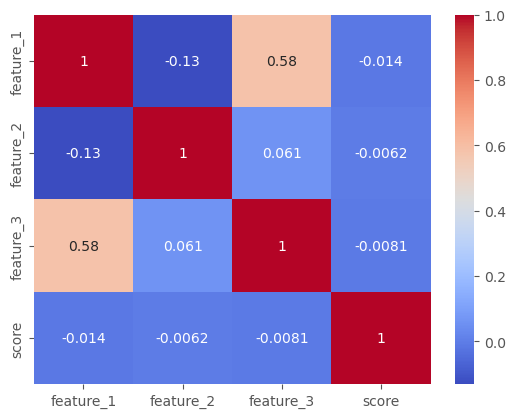

In [ ]:
# Subset the dataframe to include only the columns of interest
subset_df = usersc_df[['feature_1', 'feature_2', 'feature_3', 'score']]

# Calculate the correlation matrix
corr_matrix = subset_df.corr()

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

# Show the plot
plt.show()

## **Merchants Data Analysis:**

In [ ]:
merch_df.head()

merchant_id  merchant_group_id  merchant_category_id  subsector_id   
0  M_ID_838061e48c               8353                   792             9  \
1  M_ID_9339d880ad               3184                   840            20   
2  M_ID_e726bbae1e                447                   690             1   
3  M_ID_a70e9c5f81               5026                   792             9   
4  M_ID_64456c37ce               2228                   222            21   

    numerical_1   numerical_2 category_1 most_recent_sales_range   
0 -0.0574706500 -0.0574706500          N                       E  \
1 -0.0574706500 -0.0574706500          N                       E   
2 -0.0574706500 -0.0574706500          N                       E   
3 -0.0574706500 -0.0574706500          Y                       E   
4 -0.0574706500 -0.0574706500          Y                       E   

  most_recent_purchases_range  avg_sales_lag3  ...  avg_sales_lag6   
0                           E   -0.4000000000  ...   -2.2500000000  \
1                           E   -0.7200000000  ...   -0.7400000000   
2                           E  -82.1300000000  ...  -82.1300000000   
3                           E             NaN  ...             NaN   
4                           E             NaN  ...             NaN   

   avg_purchases_lag6  active_months_lag6  avg_sales_lag12   
0       18.6666666700                   6    -2.3200000000  \
1        1.2916666700                   6    -0.5700000000   
2      260.0000000000                   2   -82.1300000000   
3        4.6666666700                   6              NaN   
4        0.3611111100                   6              NaN   

   avg_purchases_lag12  active_months_lag12  category_4  city_id state_id   
0        13.9166666700                   12           N      242        9  \
1         1.6875000000                   12           N       22       16   
2       260.0000000000                    2           N       -1        5   
3         3.8333333300                   12           Y       -1       -1   
4         0.3472222200                   12           Y       -1       -1   

    category_2  
0 1.0000000000  
1 1.0000000000  
2 5.0000000000  
3          NaN  
4          NaN  

[5 rows x 22 columns]

**Observations** There is an equally 13 null values in (avg_sales_lag3, avg_sales_lag6, avg_sales_lag12) and 11887 null valule in category_2 

In [ ]:
merch_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   merchant_id                  334696 non-null  object 
 1   merchant_group_id            334696 non-null  int64  
 2   merchant_category_id         334696 non-null  int64  
 3   subsector_id                 334696 non-null  int64  
 4   numerical_1                  334696 non-null  float64
 5   numerical_2                  334696 non-null  float64
 6   category_1                   334696 non-null  object 
 7   most_recent_sales_range      334696 non-null  object 
 8   most_recent_purchases_range  334696 non-null  object 
 9   avg_sales_lag3               334683 non-null  float64
 10  avg_purchases_lag3           334696 non-null  float64
 11  active_months_lag3           334696 non-null  int64  
 12  avg_sales_lag6               334683 non-null  float64
 13 

In [ ]:
merch_df.describe()

merchant_group_id  merchant_category_id      subsector_id   
count  334696.0000000000     334696.0000000000 334696.0000000000  \
mean    31028.7361426489        423.1316627626     25.1164041399   
std     31623.0434258543        252.8980464072      9.8073711505   
min         1.0000000000         -1.0000000000     -1.0000000000   
25%      3612.0000000000        222.0000000000     19.0000000000   
50%     19900.0000000000        373.0000000000     27.0000000000   
75%     51707.2500000000        683.0000000000     33.0000000000   
max    112586.0000000000        891.0000000000     41.0000000000   

            numerical_1       numerical_2    avg_sales_lag3   
count 334696.0000000000 334696.0000000000 334683.0000000000  \
mean       0.0114763798      0.0081031097     13.8329925034   
std        1.0981535341      1.0704971291   2395.4899987269   
min       -0.0574706500     -0.0574706500    -82.1300000000   
25%       -0.0574706500     -0.0574706500      0.8800000000   
50%       -0.0574706500     -0.0574706500      1.0000000000   
75%       -0.0475557500     -0.0475557500      1.1600000000   
max      183.7351113700    182.0793223400 851844.6400000000   

       avg_purchases_lag3  active_months_lag3     avg_sales_lag6   
count   334696.0000000000   334696.0000000000  334683.0000000000  \
mean                  inf        2.9941080861      21.6507871329   
std                   NaN        0.0952474880    3947.1080986729   
min          0.3334953300        1.0000000000     -82.1300000000   
25%          0.9236499100        3.0000000000       0.8500000000   
50%          1.0166666700        3.0000000000       1.0100000000   
75%          1.1465217525        3.0000000000       1.2300000000   
max                   inf        3.0000000000 1513959.0000000000   

       avg_purchases_lag6  active_months_lag6    avg_sales_lag12   
count   334696.0000000000   334696.0000000000  334683.0000000000  \
mean                  inf        5.9473970409      25.2277088768   
std                   NaN        0.3949360217    5251.8421649484   
min          0.1670446600        1.0000000000     -82.1300000000   
25%          0.9022474575        6.0000000000       0.8500000000   
50%          1.0269607800        6.0000000000       1.0200000000   
75%          1.2155752550        6.0000000000       1.2900000000   
max                   inf        6.0000000000 2567408.0000000000   

       avg_purchases_lag12  active_months_lag12           city_id   
count    334696.0000000000    334696.0000000000 334696.0000000000  \
mean                   inf        11.5993349189    102.9179255205   
std                    NaN         1.5201376721    107.0906729100   
min           0.0983295400         1.0000000000     -1.0000000000   
25%           0.8983333300        12.0000000000     -1.0000000000   
50%           1.0433611550        12.0000000000     69.0000000000   
75%           1.2664796350        12.0000000000    182.0000000000   
max                    inf        12.0000000000    347.0000000000   

               state_id        category_2  
count 334696.0000000000 322809.0000000000  
mean      11.8609424672      2.3800017967  
std        6.1768887837      1.5626610493  
min       -1.0000000000      1.0000000000  
25%        9.0000000000      1.0000000000  
50%        9.0000000000      2.0000000000  
75%       16.0000000000      4.0000000000  
max       24.0000000000      5.0000000000

**Observations** (std) is NaN for some columns. This occurs when a column contains only missing values (represented as nan) or infinite values (represented as inf).

In [ ]:
merch_df.duplicated().sum()

0

**Observations** There is no duplicated values

In [ ]:
merch_df.isna().sum()

merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_lag3                    13
avg_purchases_lag3                 0
active_months_lag3                 0
avg_sales_lag6                    13
avg_purchases_lag6                 0
active_months_lag6                 0
avg_sales_lag12                   13
avg_purchases_lag12                0
active_months_lag12                0
category_4                         0
city_id                            0
state_id                           0
category_2                     11887
dtype: int64

**Observations** There is an equally 13 null values in (avg_sales_lag3, avg_sales_lag6, avg_sales_lag12) and 11887 null valule in category_2 

### **Check Missing Values**

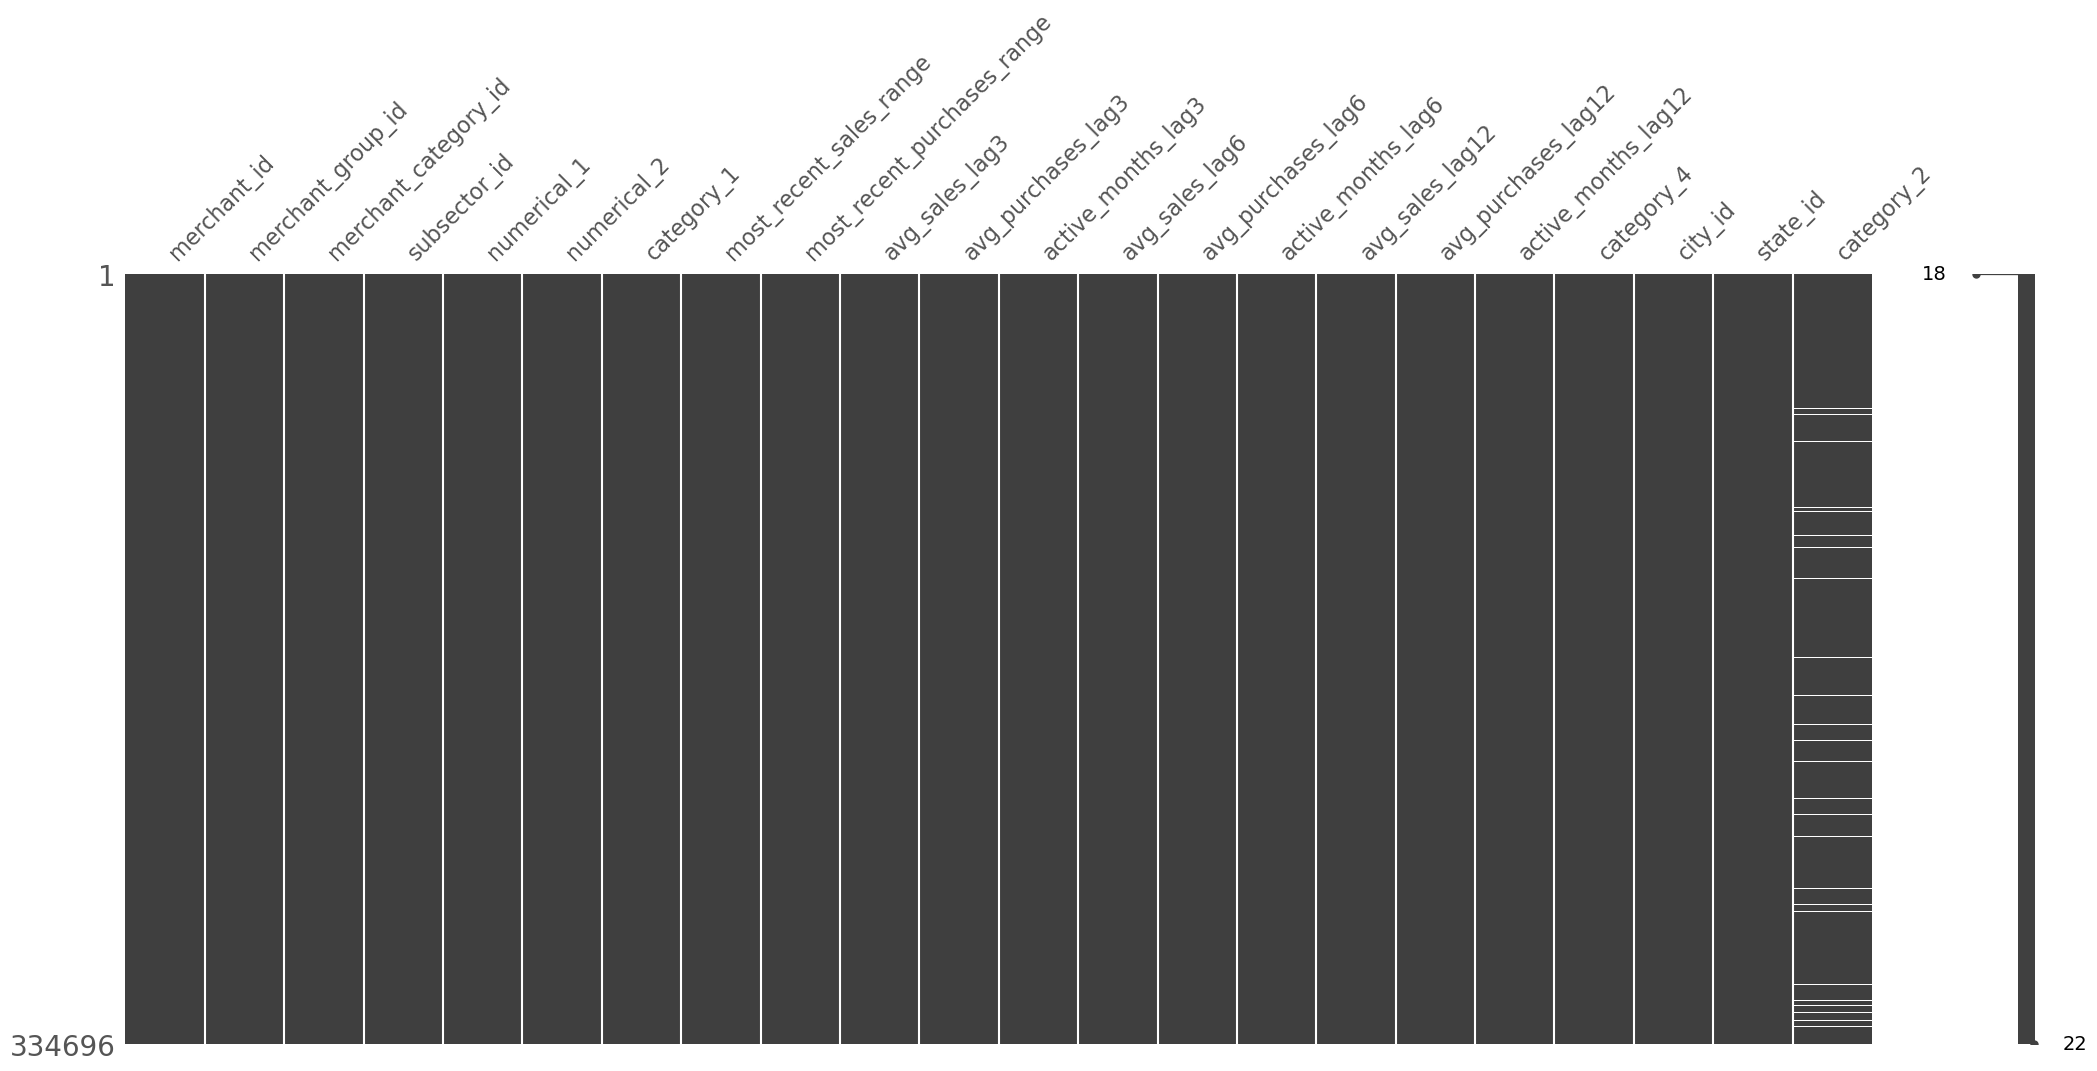

In [ ]:
# Create a visualization of the missing values
msno.matrix(merch_df)

# Show the plot
plt.show()

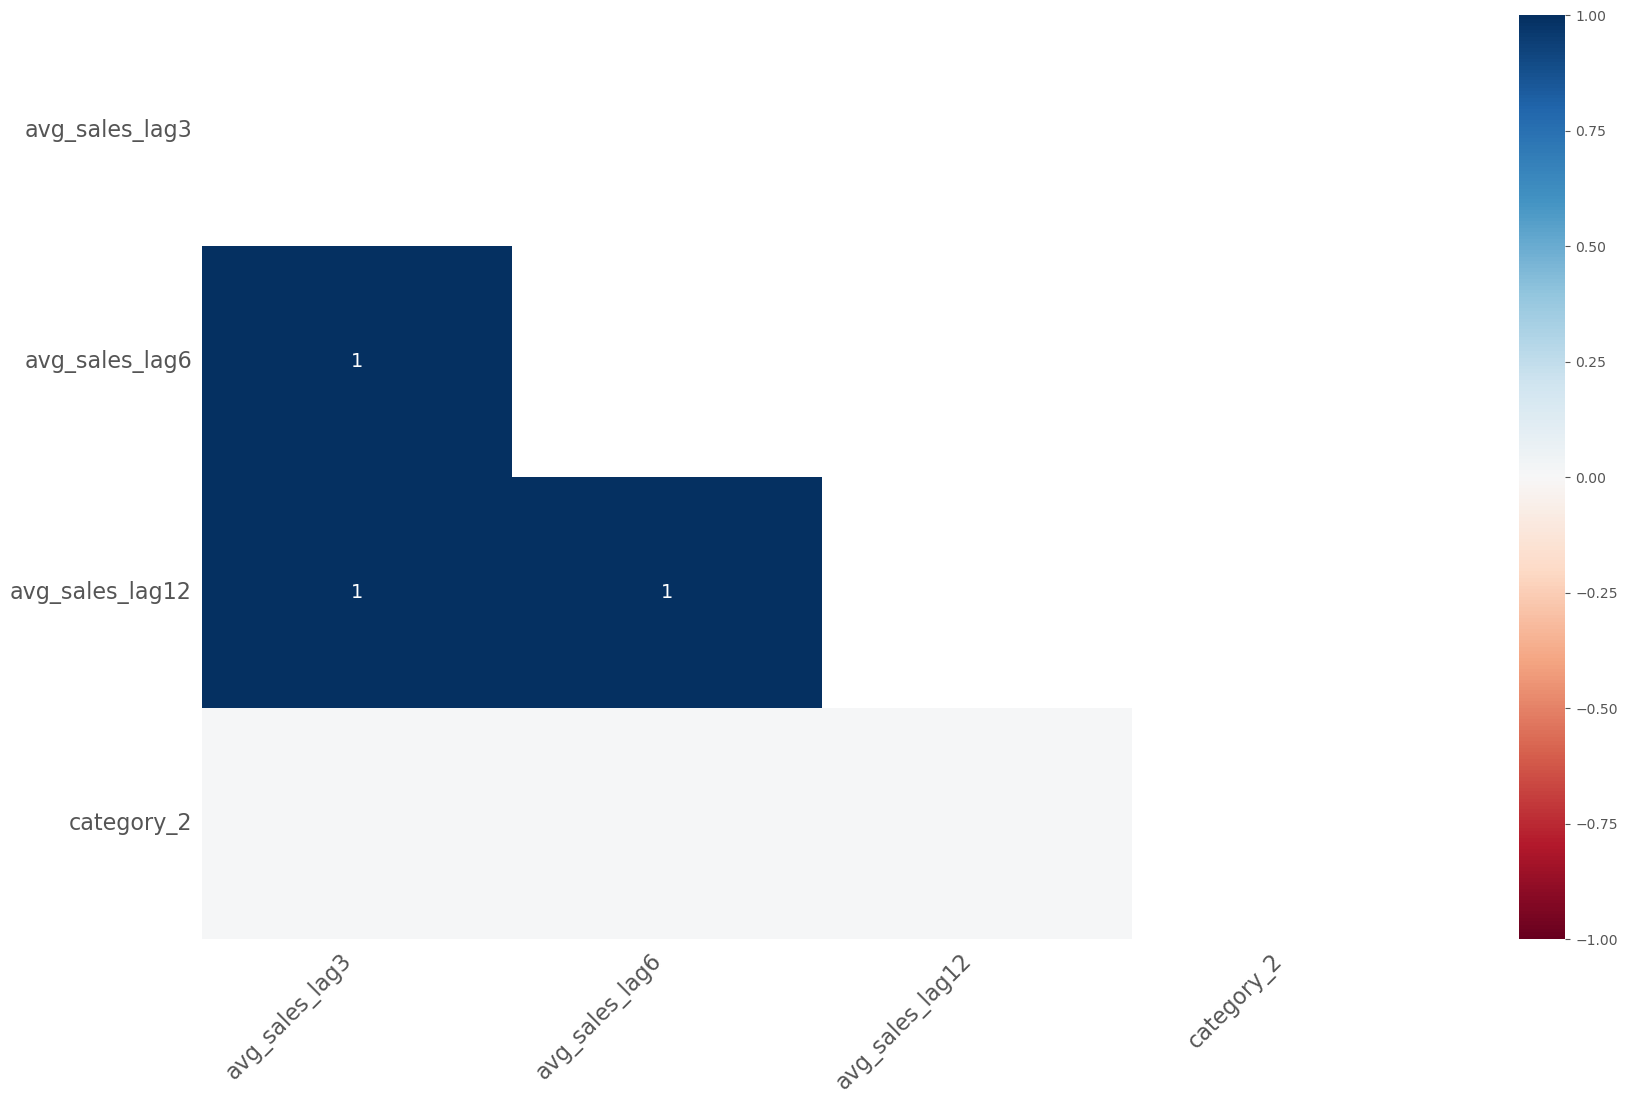

In [ ]:
# Create a heatmap of the correlation between missing values
msno.heatmap(merch_df)

# Show the plot
plt.show()

In [ ]:
# Create a boolean mask for the null values in avg_sales_lag3 column
mask1 = merch_df['avg_sales_lag3'].isnull()

# Create a boolean mask for the null values in avg_sales_lag6 column
mask2 = merch_df['avg_sales_lag6'].isnull()

# Create a boolean mask for the null values in avg_sales_lag12 column
mask3 = merch_df['avg_sales_lag12'].isnull()

# Combine the masks to check for the cases where all three columns have null values
combined_mask = mask1 & mask2 & mask3

# Count the number of rows where all three columns have null values
count = combined_mask.sum()

# Print the count
print(count)

13


In [ ]:
# Create a boolean mask for the null values in category_2 column
mask4 = merch_df['category_2'].isnull()

# Combine the masks to check for the cases where all Four columns have null values
combined_mask = mask1 & mask2 & mask3 & mask4

# Count the number of rows where all Four columns have null values
count = combined_mask.sum()

# Print the count
print(count)

6


**Observations** 

There are 13 rows where all three columns have null values, and the null values in these columns (`avg_sales_lag3`, `avg_sales_lag6`, and `avg_sales_lag12`) have null values and occur together. 

here are 6 rows in the dataset where all four columns (avg_sales_lag3, avg_sales_lag6, avg_sales_lag12, and category_2) have null values, and the null values in these columns occur together.

that there may be a systematic reason why these values are missing.

It's possible that the null values in these columns are related to a specific time period or to a specific group of observations. Understanding the reason why these values are missing can help to determine the appropriate method for handling them in your analysis.

We can handling missing values with replacing it with estimated values based on the available data. 

**Type of missing:**
- avg_sales_lag3, avg_sales_lag6, and avg_sales_lag12 are at Random
- category_2 is Completley at Random

**Mechanism:** General 


### **Correlation Analysis**

In [ ]:
# Select all numerical columns in the merchants DataFrame
numerical_features = merch_df.select_dtypes(include=['float64', 'int64'])

# Display the first 10 rows of the numerical features
print(numerical_features.head(10))

   merchant_group_id  merchant_category_id  subsector_id   numerical_1   
0               8353                   792             9 -0.0574706500  \
1               3184                   840            20 -0.0574706500   
2                447                   690             1 -0.0574706500   
3               5026                   792             9 -0.0574706500   
4               2228                   222            21 -0.0574706500   
5              20201                    87            27 -0.0574706500   
6              33861                   792             9 -0.0574706500   
7              16430                   529            20 -0.0574706500   
8              37179                   813            29 -0.0574706500   
9             112122                    81            29 -0.0574706500   

    numerical_2  avg_sales_lag3  avg_purchases_lag3  active_months_lag3   
0 -0.0574706500   -0.4000000000        9.6666666700                   3  \
1 -0.0574706500   -0.7200000000    

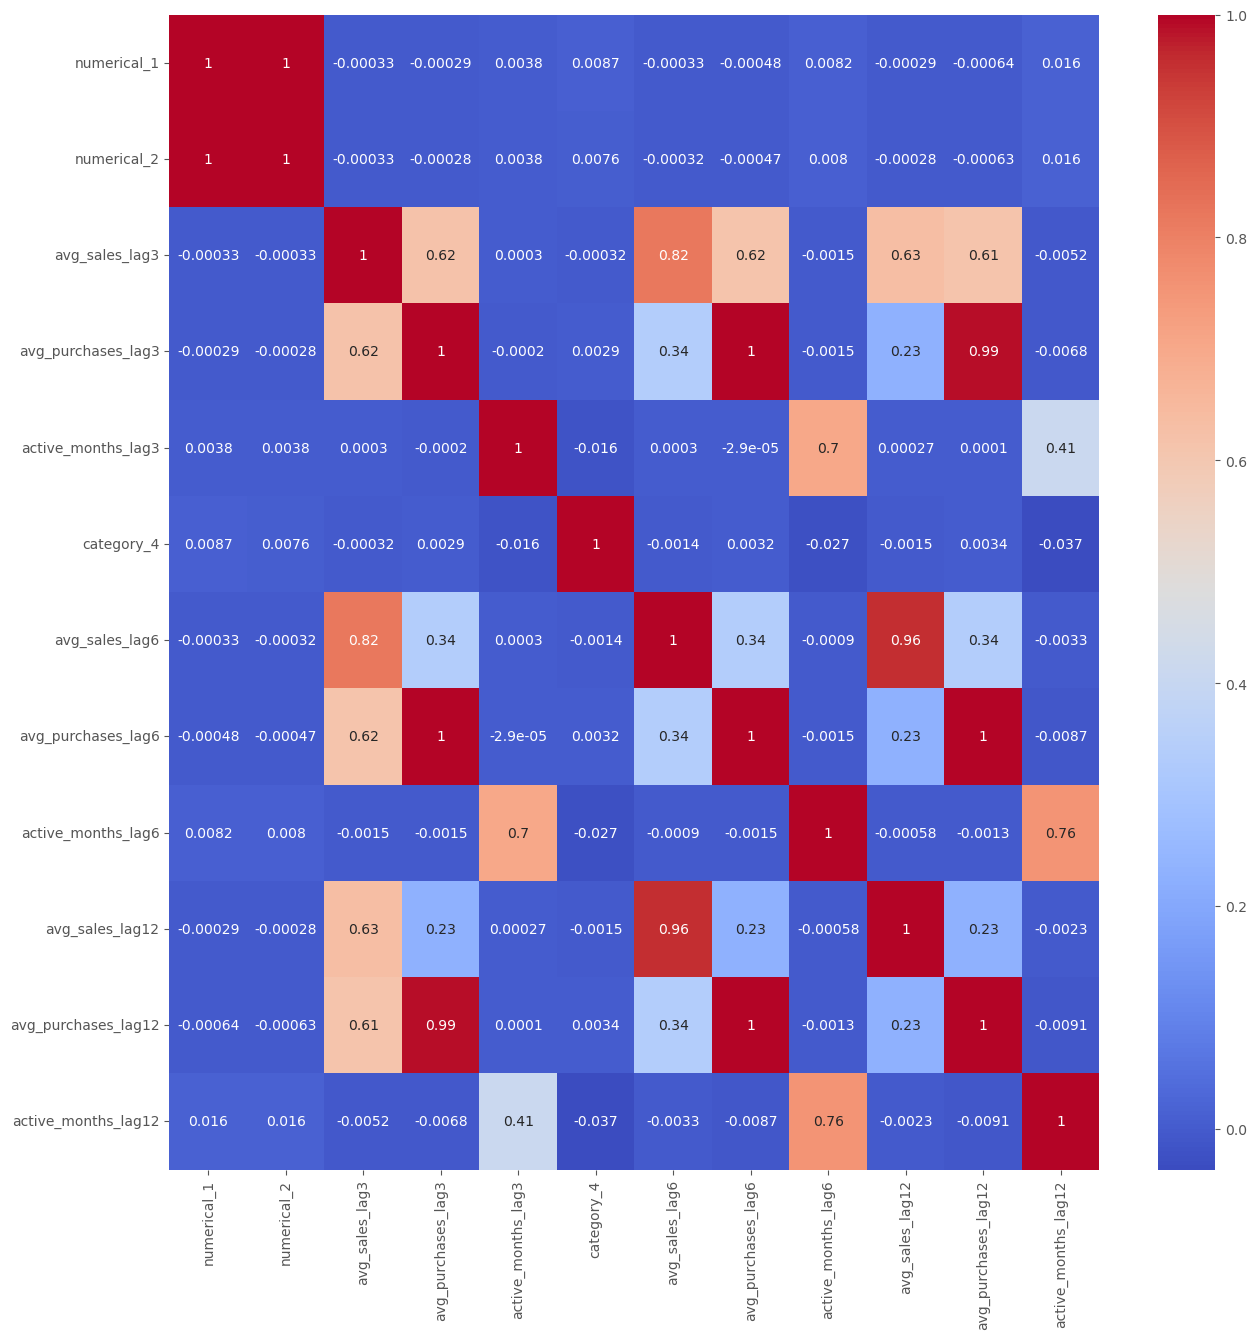

In [ ]:
# Convert the 'category_4' column to a binary format
merch_df['category_4'] = merch_df['category_4'].replace({'Y': 1, 'N': 0})

# Subset the dataframe to include only the columns of interest
subset_df = merch_df[['numerical_1', 'numerical_2', 'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3', 'category_4','avg_sales_lag6',  
'avg_purchases_lag6',  'active_months_lag6',  'avg_sales_lag12','avg_purchases_lag12',  'active_months_lag12']]

# Calculate the correlation matrix
corr_matrix = subset_df.corr()

# Create a larger figure
plt.figure(figsize=(15, 15))

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

# Show the plot
plt.show()

In [ ]:
# Stack the correlation matrix into a multi-index series
stacked_corr = corr_matrix.stack()

# Select only the pairs of features that have a correlation greater than 0.9 and are not equal to 1.0
high_corr = stacked_corr[(stacked_corr > 0.9) & (stacked_corr != 1.0)]

# Get the names of the highly correlated features
high_corr_names = high_corr.reset_index()[['level_0', 'level_1']].apply(tuple, axis=1).tolist()

# Print the names of the highly correlated features
print(high_corr_names)

[('numerical_1', 'numerical_2'), ('numerical_2', 'numerical_1'), ('avg_purchases_lag3', 'avg_purchases_lag6'), ('avg_purchases_lag3', 'avg_purchases_lag12'), ('avg_sales_lag6', 'avg_sales_lag12'), ('avg_purchases_lag6', 'avg_purchases_lag3'), ('avg_purchases_lag6', 'avg_purchases_lag12'), ('avg_sales_lag12', 'avg_sales_lag6'), ('avg_purchases_lag12', 'avg_purchases_lag3'), ('avg_purchases_lag12', 'avg_purchases_lag6')]


**Observations** 
 
There is multicollinearity between: 
- numeri_1 and numerical_2
- avg_purchases_lag3, avg_purchases_lag6
- avg_purchases_lag3, avg_purchases_lag12
- avg_sales_lag6, avg_sales_lag12

### **Check Normality and Outliers**

In [ ]:
# Randomly sample 10% of the rows from the 'dataset' dataframe
# without replacement, using a random seed of 42
df = merch_df.sample(frac=0.1, replace=False, random_state=42)

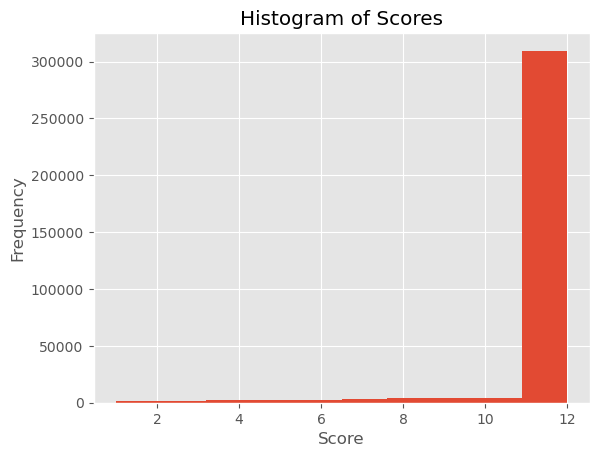

In [ ]:
# Draw a histogram of the "score" column
merch_df['active_months_lag12'].hist()

# Set the title and axis labels
plt.title('Histogram of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Show the plot
plt.show()

<Axes: >

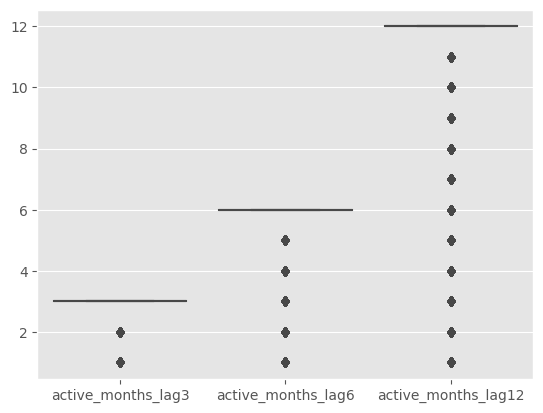

In [ ]:
# Plot a box plot of a numerical feature
sns.boxplot(merch_df[['active_months_lag3','active_months_lag6','active_months_lag12']])

**Observations** Active months lag 12 are very high in the respective features

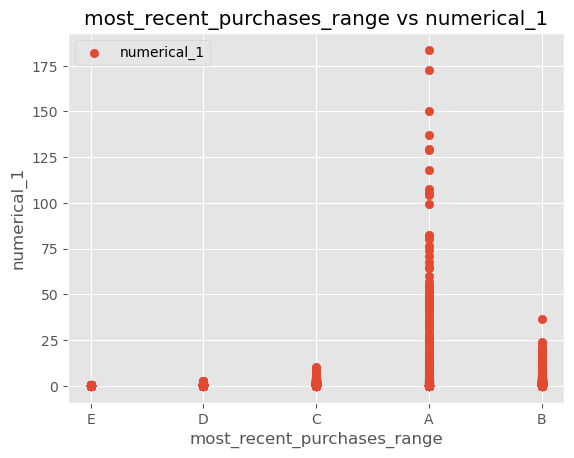

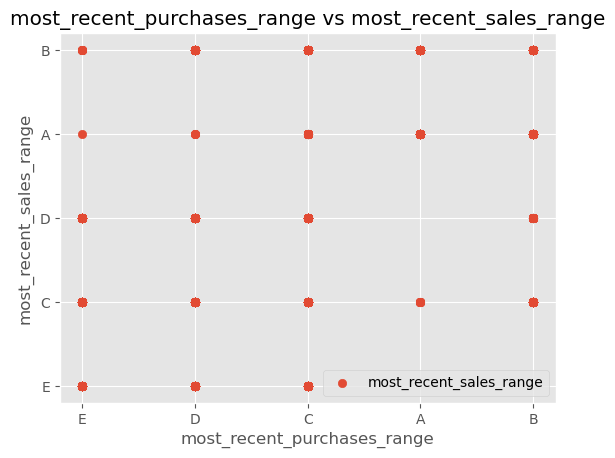

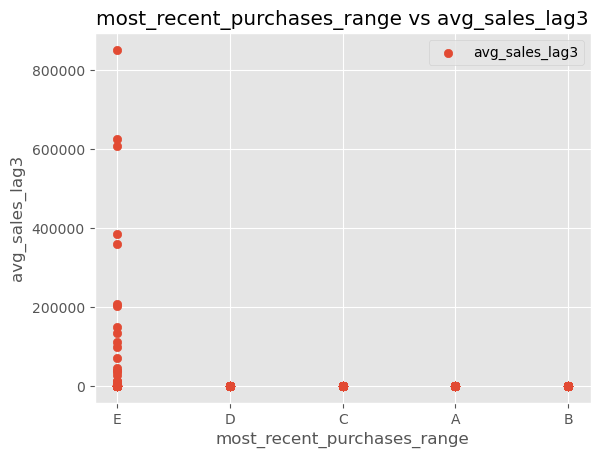

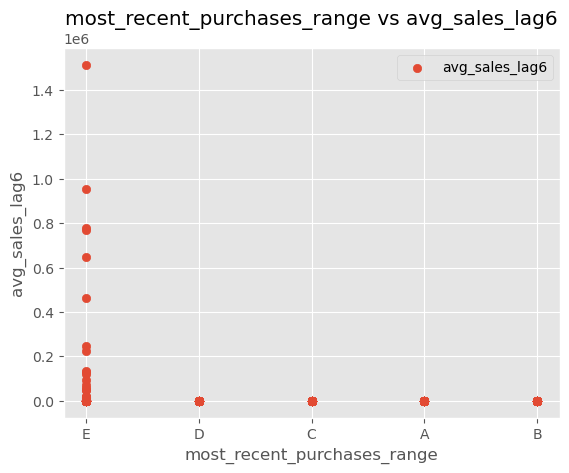

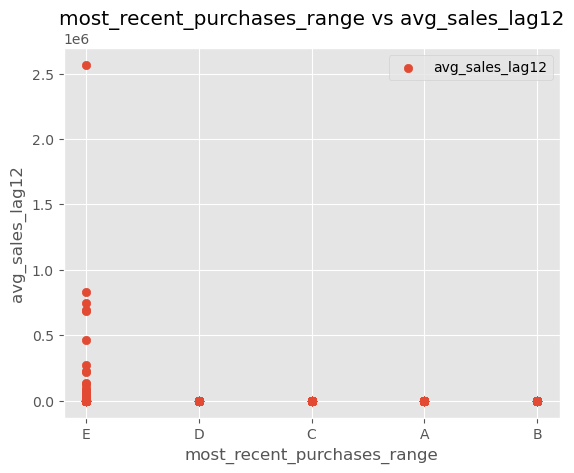

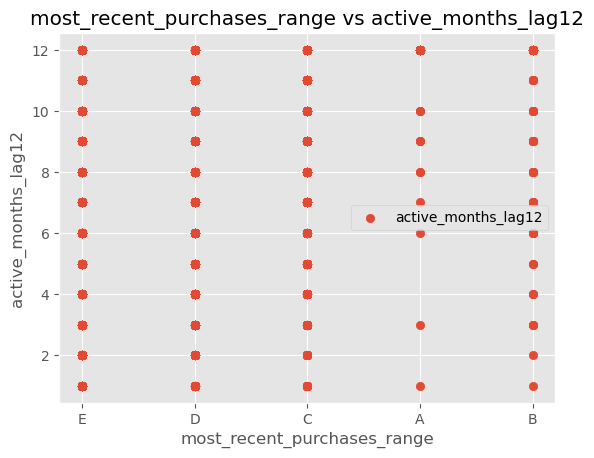

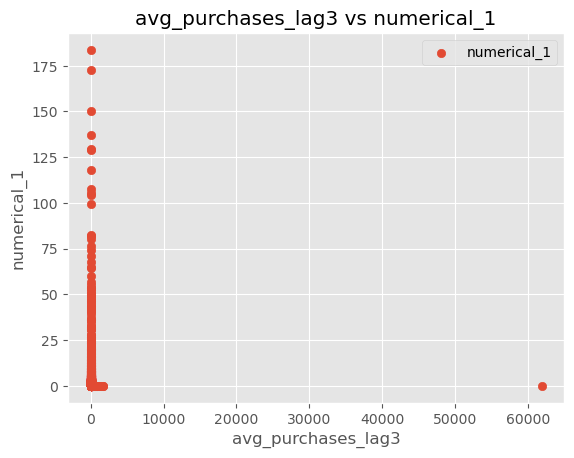

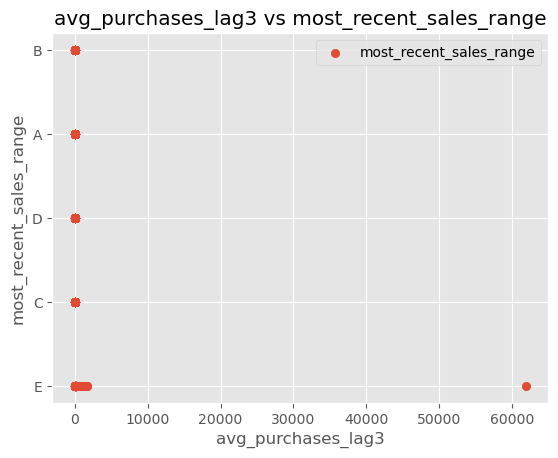

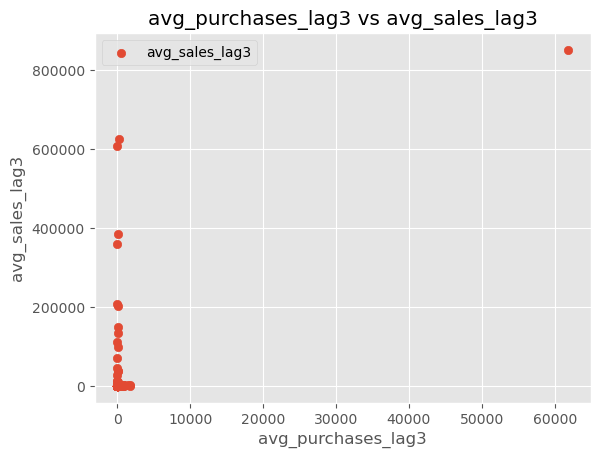

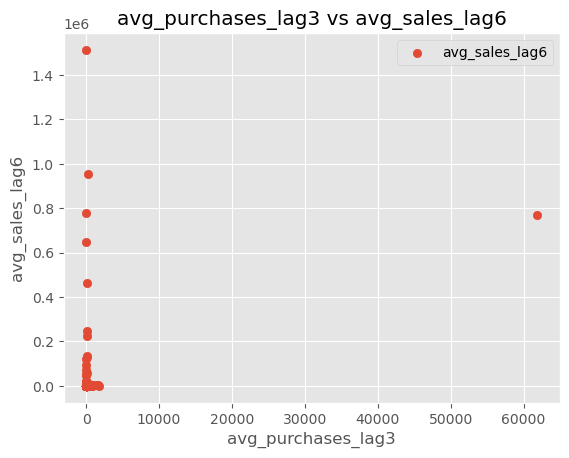

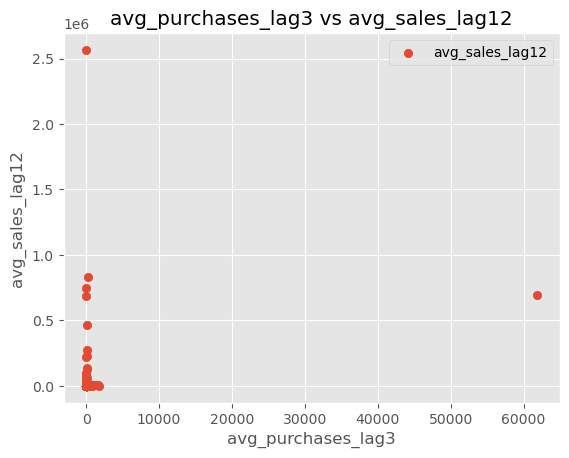

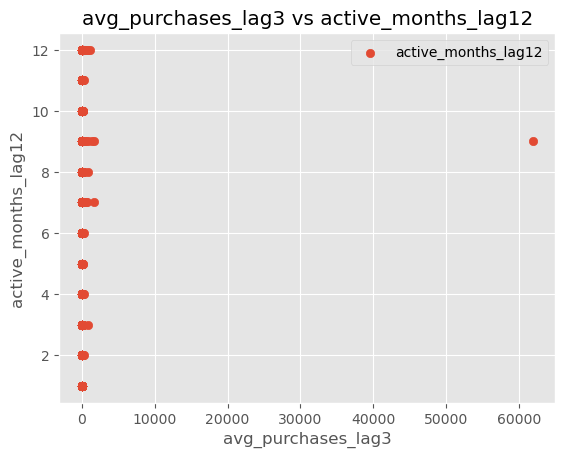

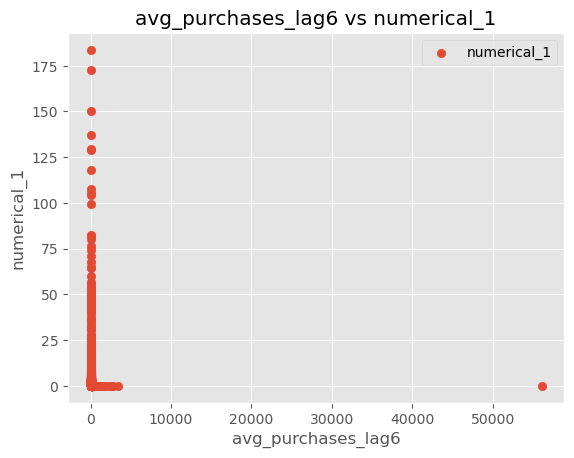

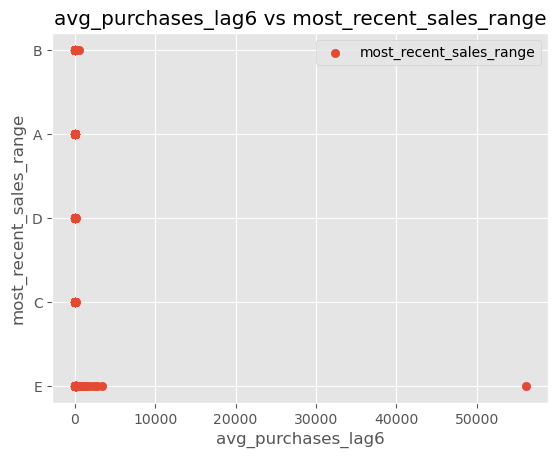

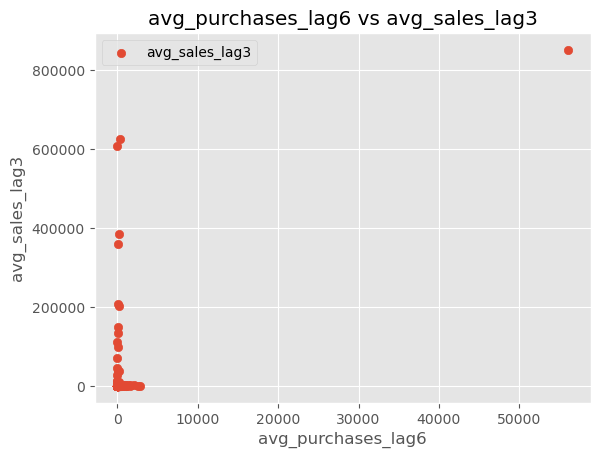

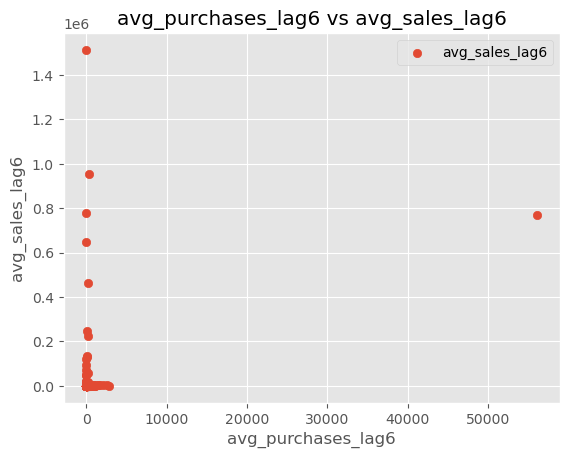

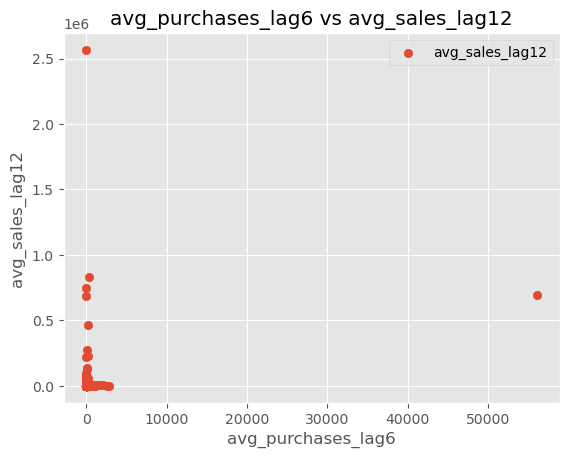

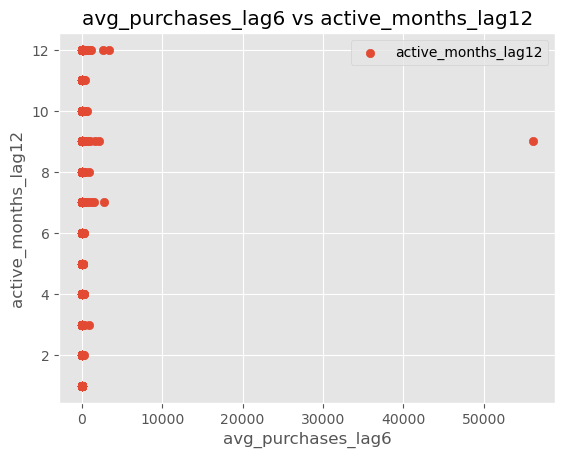

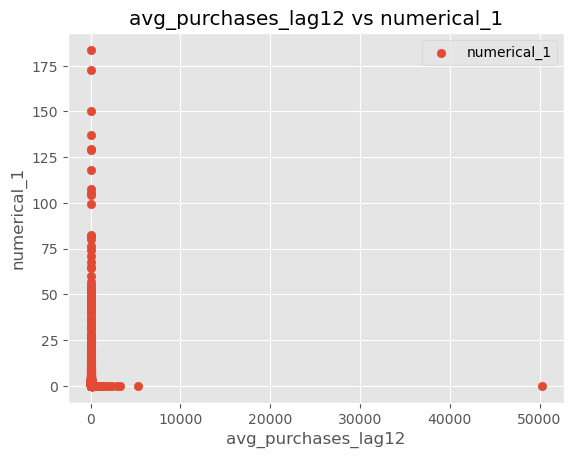

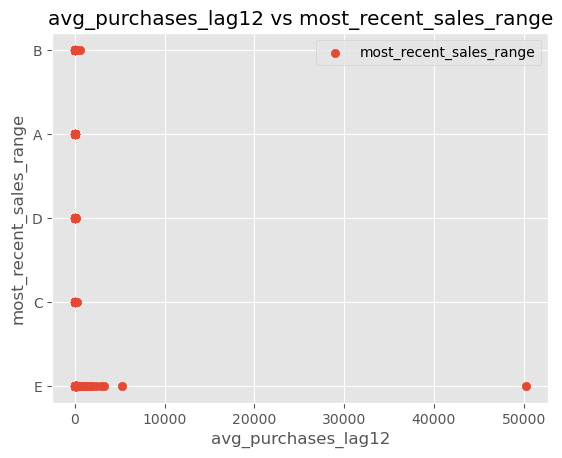

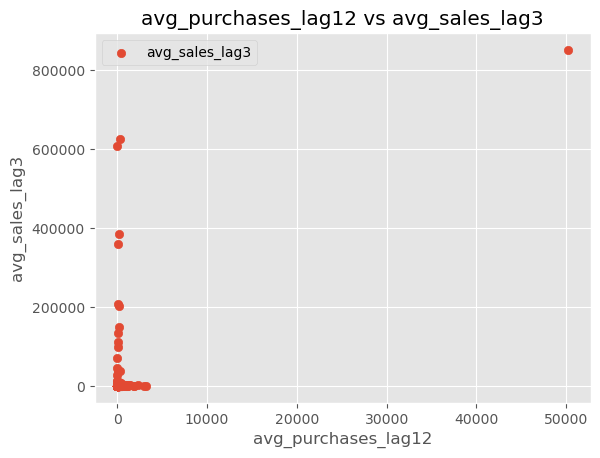

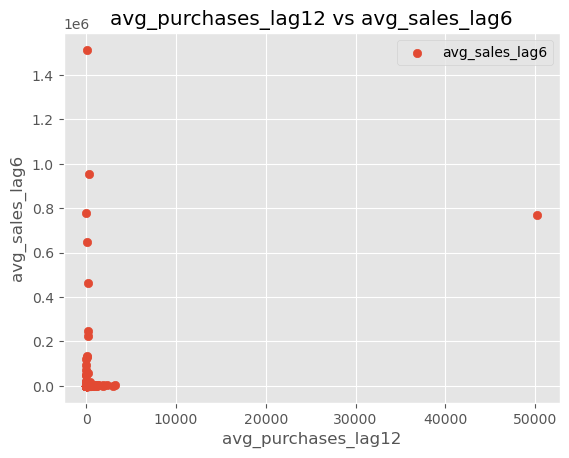

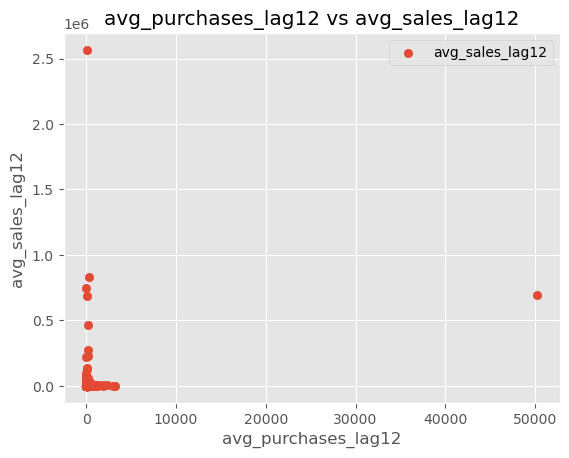

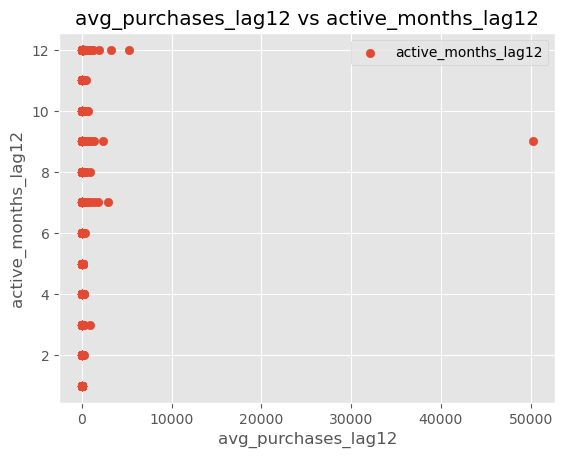

In [ ]:
# List of columns related to purchases and sales
purchase_cols = ['most_recent_purchases_range', 'avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']
sales_cols = ['numerical_1', 'most_recent_sales_range', 'avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12', 'active_months_lag12']

# Iterate through all pairs of columns
for purchase_col in purchase_cols:
    for sales_col in sales_cols:
        # Create a scatter plot
        plt.scatter(merch_df[purchase_col], merch_df[sales_col], label=sales_col)

        # Add axis labels and title
        plt.xlabel(purchase_col)
        plt.ylabel(sales_col)
        plt.title('{} vs {}'.format(purchase_col, sales_col))

        # Add legend
        plt.legend()

        # Show the plot
        plt.show()

## **History Merchant Transaction VS. New Transaction Data Analysis:**

### **History Merchant Transaction Data Analysis:**

In [ ]:
hist_trans_df.head()

authorized_flag          card_id  city_id category_1  installments   
0               Y  C_ID_4e6213e9bc       88          N             0  \
1               Y  C_ID_4e6213e9bc       88          N             0   
2               Y  C_ID_4e6213e9bc       88          N             0   
3               Y  C_ID_4e6213e9bc       88          N             0   
4               Y  C_ID_4e6213e9bc       88          N             0   

  category_3  merchant_category_id      merchant_id  month_lag   
0          A                    80  M_ID_e020e9b302         -8  \
1          A                   367  M_ID_86ec983688         -7   
2          A                    80  M_ID_979ed661fc         -6   
3          A                   560  M_ID_e6d5ae8ea6         -5   
4          A                    80  M_ID_e020e9b302        -11   

   purchase_amount        purchase_date   category_2  state_id  subsector_id  
0    -0.7033309100  2017-06-25 15:33:07 1.0000000000        16            37  
1    -0.7331284800  2017-07-15 12:10:45 1.0000000000        16            16  
2    -0.7203860000  2017-08-09 22:04:29 1.0000000000        16            37  
3    -0.7353524100  2017-09-02 10:06:26 1.0000000000        16            34  
4    -0.7228653800  2017-03-10 01:14:19 1.0000000000        16            37

In [ ]:
# Convert the date column to datetime format
hist_trans_df['purchase_date'] = pd.to_datetime(hist_trans_df['purchase_date'])

In [ ]:
hist_trans_df.head()

authorized_flag          card_id  city_id category_1  installments   
0               Y  C_ID_4e6213e9bc       88          N             0  \
1               Y  C_ID_4e6213e9bc       88          N             0   
2               Y  C_ID_4e6213e9bc       88          N             0   
3               Y  C_ID_4e6213e9bc       88          N             0   
4               Y  C_ID_4e6213e9bc       88          N             0   

  category_3  merchant_category_id      merchant_id  month_lag   
0          A                    80  M_ID_e020e9b302         -8  \
1          A                   367  M_ID_86ec983688         -7   
2          A                    80  M_ID_979ed661fc         -6   
3          A                   560  M_ID_e6d5ae8ea6         -5   
4          A                    80  M_ID_e020e9b302        -11   

   purchase_amount       purchase_date   category_2  state_id  subsector_id  
0    -0.7033309100 2017-06-25 15:33:07 1.0000000000        16            37  
1    -0.7331284800 2017-07-15 12:10:45 1.0000000000        16            16  
2    -0.7203860000 2017-08-09 22:04:29 1.0000000000        16            37  
3    -0.7353524100 2017-09-02 10:06:26 1.0000000000        16            34  
4    -0.7228653800 2017-03-10 01:14:19 1.0000000000        16            37

In [ ]:
hist_trans_df.describe()

city_id        installments  merchant_category_id   
count 29112361.0000000000 29112361.0000000000   29112361.0000000000  \
mean       129.3256165998        0.6484953934        481.0130283490   
min         -1.0000000000       -1.0000000000         -1.0000000000   
25%         53.0000000000        0.0000000000        307.0000000000   
50%         90.0000000000        0.0000000000        454.0000000000   
75%        212.0000000000        1.0000000000        705.0000000000   
max        347.0000000000      999.0000000000        891.0000000000   
std        104.2563013804        2.7955769340        249.3757137661   

                month_lag     purchase_amount                  purchase_date   
count 29112361.0000000000 29112361.0000000000                       29112361  \
mean        -4.4872935589        0.0364009014  2017-09-06 17:56:46.261038080   
min        -13.0000000000       -0.7469078000            2017-01-01 00:00:08   
25%         -7.0000000000       -0.7203559500            2017-06-09 12:22:42   
50%         -4.0000000000       -0.6883494800            2017-09-24 15:05:43   
75%         -2.0000000000       -0.6032543400            2017-12-14 12:50:55   
max          0.0000000000  6010603.9717525002            2018-02-28 23:59:51   
std          3.5887997186     1123.5216483035                            NaN   

               category_2            state_id        subsector_id  
count 26459497.0000000000 29112361.0000000000 29112361.0000000000  
mean         2.1945784155       10.5667899282       26.8483882843  
min          1.0000000000       -1.0000000000       -1.0000000000  
25%          1.0000000000        9.0000000000       19.0000000000  
50%          1.0000000000        9.0000000000       29.0000000000  
75%          3.0000000000       16.0000000000       34.0000000000  
max          5.0000000000       24.0000000000       41.0000000000  
std          1.5318962886        6.3669271756        9.6927930678

**Observations**

- The dataset seems to be quite large, containing almost 30 million observations.
- the mean value for purchase_amount is 0.036, indicating that the average purchase amount is relatively small.
-  the maximum value for purchase_amount is over 6 million, which is much larger than the mean and median values, suggesting the presence of extreme values or outliers in the data.

In [ ]:
hist_trans_df.duplicated().sum()

0

**Observations** There is no duplicated values

In [ ]:
hist_trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
 #   Column                Dtype         
---  ------                -----         
 0   authorized_flag       object        
 1   card_id               object        
 2   city_id               int64         
 3   category_1            object        
 4   installments          int64         
 5   category_3            object        
 6   merchant_category_id  int64         
 7   merchant_id           object        
 8   month_lag             int64         
 9   purchase_amount       float64       
 10  purchase_date         datetime64[ns]
 11  category_2            float64       
 12  state_id              int64         
 13  subsector_id          int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(5)
memory usage: 3.0+ GB


### **Check Missing Values**

In [ ]:
hist_trans_df.isna().sum()

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64

In [ ]:
# calculate the percentage of missing values for each variable
missing_percent = hist_trans_df.isnull().sum() / len(hist_trans_df) * 100

# print the percentage of missing values for each variable
print(missing_percent)

authorized_flag        0.0000000000
card_id                0.0000000000
city_id                0.0000000000
category_1             0.0000000000
installments           0.0000000000
category_3             0.6119702899
merchant_category_id   0.0000000000
merchant_id            0.4756776683
month_lag              0.0000000000
purchase_amount        0.0000000000
purchase_date          0.0000000000
category_2             9.1125003568
state_id               0.0000000000
subsector_id           0.0000000000
dtype: float64


In [ ]:
# print the most frequent values in category_2
print(hist_trans_df['category_2'].value_counts())

category_2
1.0000000000    15177199
3.0000000000     3911795
5.0000000000     3725915
4.0000000000     2618053
2.0000000000     1026535
Name: count, dtype: int64


In [ ]:
# print the most frequent values in category_2
print(hist_trans_df['category_3'].value_counts())

category_3
A    15411747
B    11677522
C     1844933
Name: count, dtype: int64


In [ ]:
# Randomly sample 10% of the rows from the 'hist_trans_df' dataframe
# without replacement, using a random seed of 42
df = hist_trans_df.sample(frac=0.1, replace=False, random_state=42)

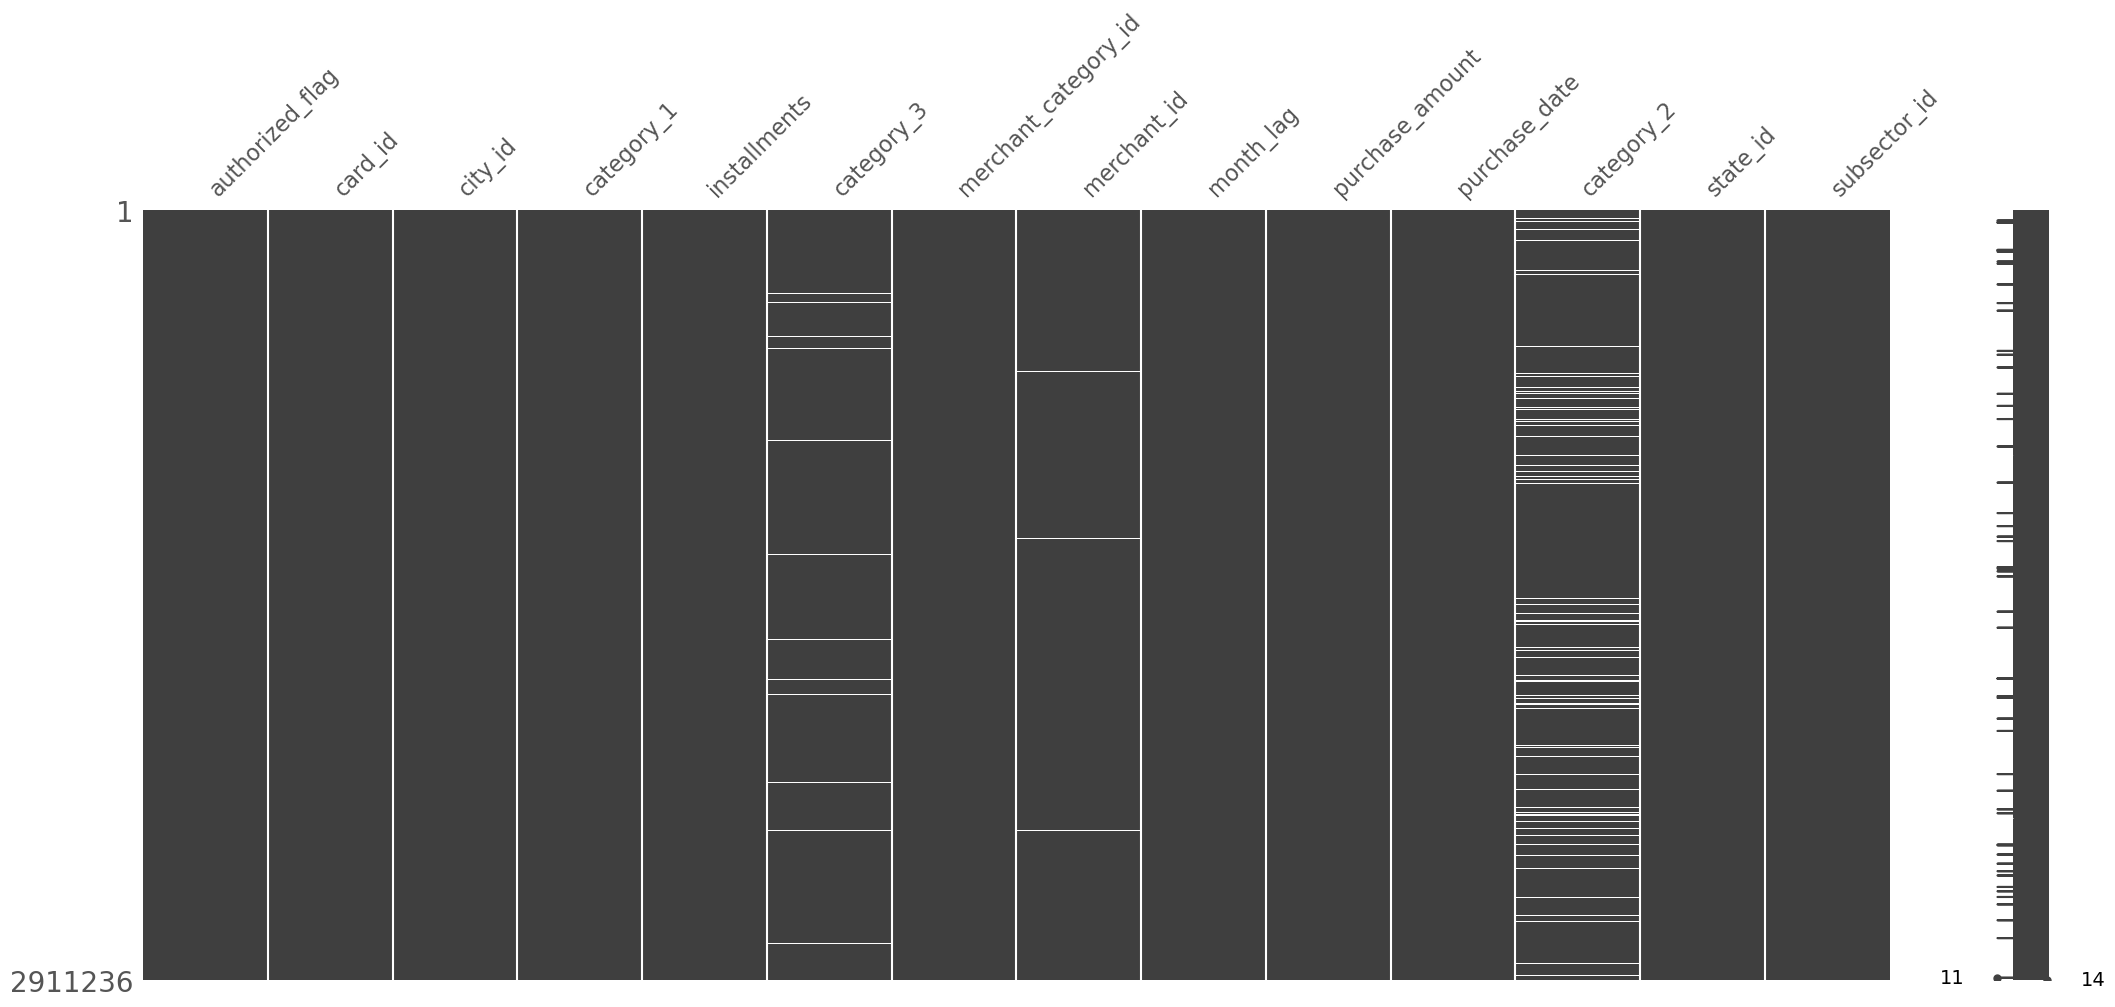

In [ ]:
# Create a visualization of the missing values
msno.matrix(df)

# Show the plot
plt.show()

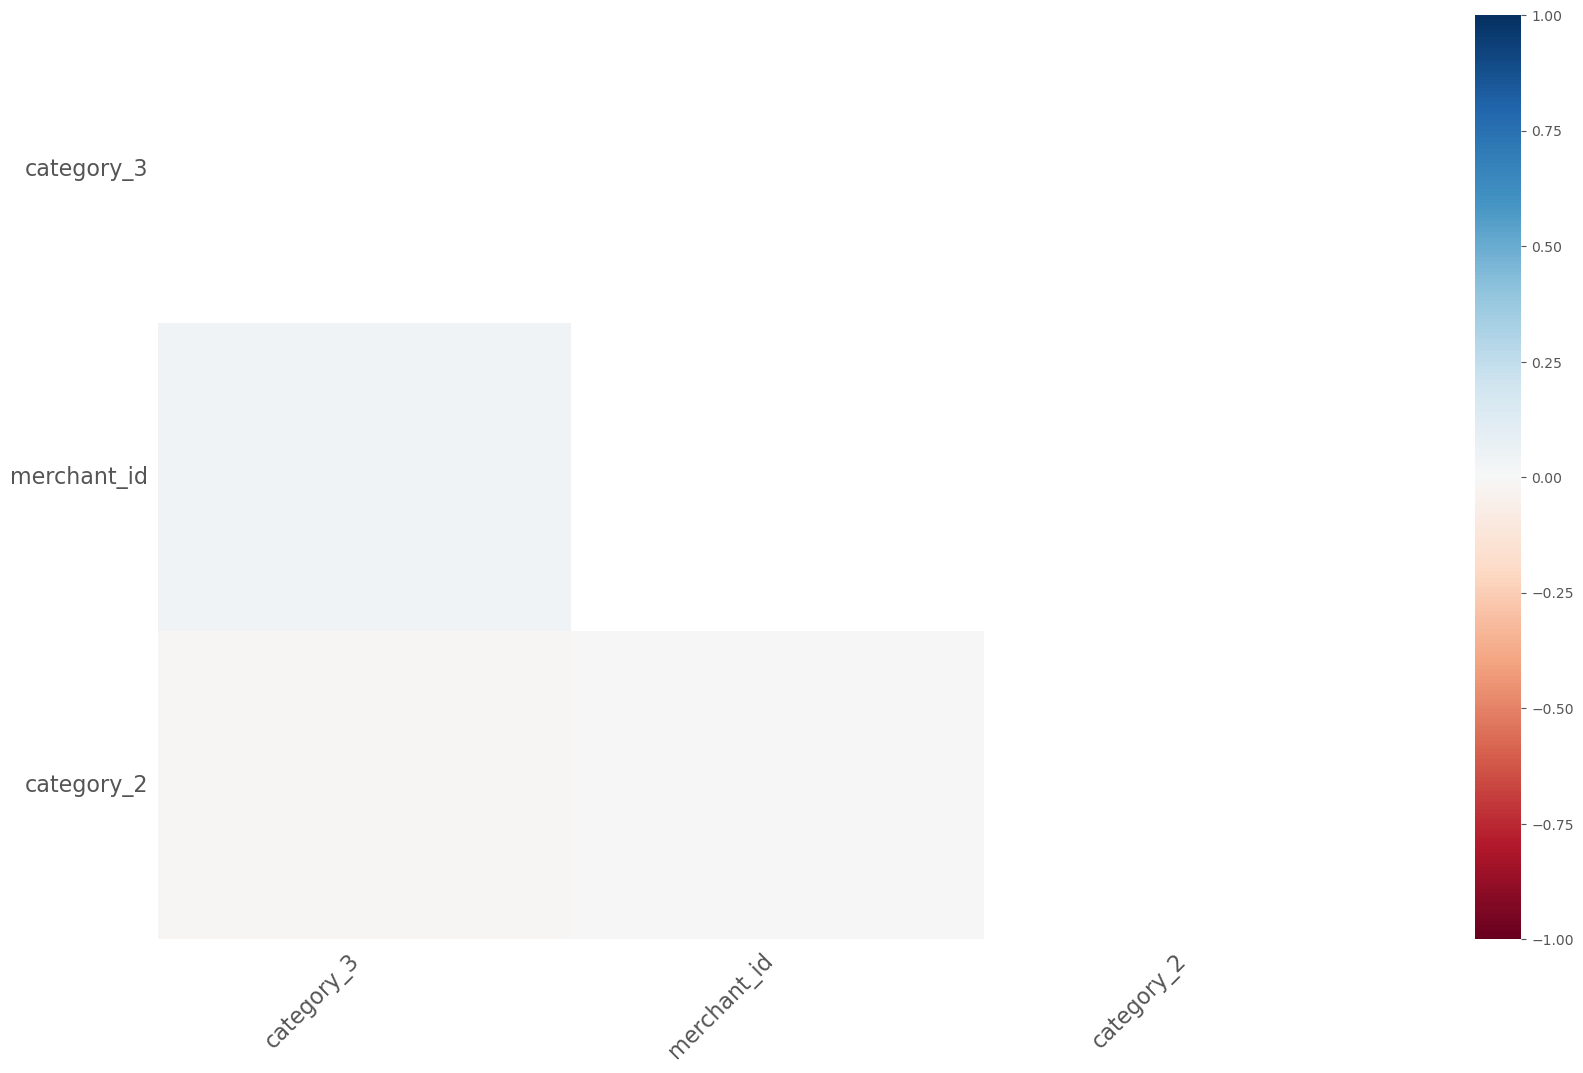

In [ ]:
# Create a heatmap of the correlation between missing values
msno.heatmap(df)

# Show the plot
plt.show()

In [ ]:
# Create a boolean mask for the null values in merchant_id column
mask1 = hist_trans_df['merchant_id'].isnull()

# Create a boolean mask for the null values in category_2 column
mask2 = hist_trans_df['category_2'].isnull()

# Create a boolean mask for the null values in category_3 column
mask3 = hist_trans_df['category_3'].isnull()

# Combine the masks to check for the cases where all three columns have null values
combined_mask = mask1 & mask2 & mask3

# Count the number of rows where all three columns have null values
count = combined_mask.sum()

# Print the count
print(count)

487


In [ ]:
# Create a boolean mask for the null values in merchant_id column
mask1 = hist_trans_df['merchant_id'].isnull()

# Create a boolean mask for the null values in category_2 column
#mask2 = hist_trans_df['category_2'].isnull()

# Create a boolean mask for the null values in category_3 column
mask3 = hist_trans_df['category_3'].isnull()

# Combine the masks to check for the cases where all three columns have null values
combined_mask = mask1 & mask3

# Count the number of rows where all three columns have null values
count = combined_mask.sum()

# Print the count
print(count)

7207


**Observations** 
- The "category_2" variable has missing values for approximately 10% of the observations

**Type of missing:**
- merchant_id, category_2, and category_3 are Completely ar Random

**Mechanism:** General 


### **New Transaction Data Analysis:**

In [ ]:
new_trans_df.head()

authorized_flag          card_id  city_id category_1  installments   
0               Y  C_ID_415bb3a509      107          N             1  \
1               Y  C_ID_415bb3a509      140          N             1   
2               Y  C_ID_415bb3a509      330          N             1   
3               Y  C_ID_415bb3a509       -1          Y             1   
4               Y  C_ID_ef55cf8d4b       -1          Y             1   

  category_3  merchant_category_id      merchant_id  month_lag   
0          B                   307  M_ID_b0c793002c          1  \
1          B                   307  M_ID_88920c89e8          1   
2          B                   507  M_ID_ad5237ef6b          2   
3          B                   661  M_ID_9e84cda3b1          1   
4          B                   166  M_ID_3c86fa3831          1   

   purchase_amount        purchase_date   category_2  state_id  subsector_id  
0    -0.5575737500  2018-03-11 14:57:36 1.0000000000         9            19  
1    -0.5695799300  2018-03-19 18:53:37 1.0000000000         9            19  
2    -0.5510372100  2018-04-26 14:08:44 1.0000000000         9            14  
3    -0.6719255000  2018-03-07 09:43:21          NaN        -1             8  
4    -0.6599042900  2018-03-22 21:07:53          NaN        -1            29

In [ ]:
# Convert the date column to datetime format
new_trans_df['purchase_date'] = pd.to_datetime(new_trans_df['purchase_date'])

In [ ]:
new_trans_df.head()

authorized_flag          card_id  city_id category_1  installments   
0               Y  C_ID_415bb3a509      107          N             1  \
1               Y  C_ID_415bb3a509      140          N             1   
2               Y  C_ID_415bb3a509      330          N             1   
3               Y  C_ID_415bb3a509       -1          Y             1   
4               Y  C_ID_ef55cf8d4b       -1          Y             1   

  category_3  merchant_category_id      merchant_id  month_lag   
0          B                   307  M_ID_b0c793002c          1  \
1          B                   307  M_ID_88920c89e8          1   
2          B                   507  M_ID_ad5237ef6b          2   
3          B                   661  M_ID_9e84cda3b1          1   
4          B                   166  M_ID_3c86fa3831          1   

   purchase_amount       purchase_date   category_2  state_id  subsector_id  
0    -0.5575737500 2018-03-11 14:57:36 1.0000000000         9            19  
1    -0.5695799300 2018-03-19 18:53:37 1.0000000000         9            19  
2    -0.5510372100 2018-04-26 14:08:44 1.0000000000         9            14  
3    -0.6719255000 2018-03-07 09:43:21          NaN        -1             8  
4    -0.6599042900 2018-03-22 21:07:53          NaN        -1            29

In [ ]:
new_trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
 #   Column                Dtype         
---  ------                -----         
 0   authorized_flag       object        
 1   card_id               object        
 2   city_id               int64         
 3   category_1            object        
 4   installments          int64         
 5   category_3            object        
 6   merchant_category_id  int64         
 7   merchant_id           object        
 8   month_lag             int64         
 9   purchase_amount       float64       
 10  purchase_date         datetime64[ns]
 11  category_2            float64       
 12  state_id              int64         
 13  subsector_id          int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(5)
memory usage: 209.7+ MB


In [ ]:
new_trans_df.describe()

city_id       installments  merchant_category_id   
count 1963031.0000000000 1963031.0000000000    1963031.0000000000  \
mean      134.3866790693       0.6829642527        430.9701349597   
min        -1.0000000000      -1.0000000000         -1.0000000000   
25%        69.0000000000       0.0000000000        278.0000000000   
50%       110.0000000000       1.0000000000        367.0000000000   
75%       212.0000000000       1.0000000000        683.0000000000   
max       347.0000000000     999.0000000000        891.0000000000   
std       101.5152418531       1.5840690280        246.3385132155   

               month_lag    purchase_amount                  purchase_date   
count 1963031.0000000000 1963031.0000000000                        1963031  \
mean        1.4765151442      -0.5509689992  2018-02-23 01:03:02.528938752   
min         1.0000000000      -0.7468927700            2017-03-01 03:24:51   
25%         1.0000000000      -0.7166293700            2018-02-26 18:26:25   
50%         1.0000000000      -0.6748406400            2018-03-19 12:16:35   
75%         2.0000000000      -0.5816161700            2018-04-08 19:32:43   
max         2.0000000000     263.1574978900            2018-04-30 23:59:59   
std         0.4994482842       0.6940042579                            NaN   

              category_2           state_id       subsector_id  
count 1851286.0000000000 1963031.0000000000 1963031.0000000000  
mean        2.1978413924      10.8806687210      25.9762413329  
min         1.0000000000      -1.0000000000      -1.0000000000  
25%         1.0000000000       9.0000000000      19.0000000000  
50%         1.0000000000       9.0000000000      29.0000000000  
75%         3.0000000000      15.0000000000      34.0000000000  
max         5.0000000000      24.0000000000      41.0000000000  
std         1.5281252822       6.0385420949      10.1290826495

For the "first_active_month" column, NaN is shown because the standard deviation of date values does not make sense and is not calculated.

It is worth noting that calculating the mean of date values does not always make sense, as dates do not have a natural zero point. In some cases, it may be more appropriate to use other metrics, such as the median or mode, to summarize the central tendency of date values.

In [ ]:
new_trans_df.duplicated().sum()

0

### **Check Missing Values**

In [ ]:
new_trans_df.isna().sum()

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

In [ ]:
# calculate the percentage of missing values for each variable
missing_percent = new_trans_df.isnull().sum() / len(new_trans_df) * 100

# print the percentage of missing values for each variable
print(missing_percent)

authorized_flag        0.0000000000
card_id                0.0000000000
city_id                0.0000000000
category_1             0.0000000000
installments           0.0000000000
category_3             2.8487578648
merchant_category_id   0.0000000000
merchant_id            1.3354857870
month_lag              0.0000000000
purchase_amount        0.0000000000
purchase_date          0.0000000000
category_2             5.6924725081
state_id               0.0000000000
subsector_id           0.0000000000
dtype: float64


In [ ]:
# print the most frequent values in category_2
print(new_trans_df['category_2'].value_counts())

category_2
1.0000000000    1058242
3.0000000000     289525
5.0000000000     259266
4.0000000000     178590
2.0000000000      65663
Name: count, dtype: int64


In [ ]:
# print the most frequent values in category_3
print(new_trans_df['category_3'].value_counts())

category_3
A    922244
B    836178
C    148687
Name: count, dtype: int64


In [ ]:
# Randomly sample 20% of the rows from the 'hist_trans_df' dataframe
# without replacement, using a random seed of 42
df = new_trans_df.sample(frac=0.2, replace=False, random_state=42)

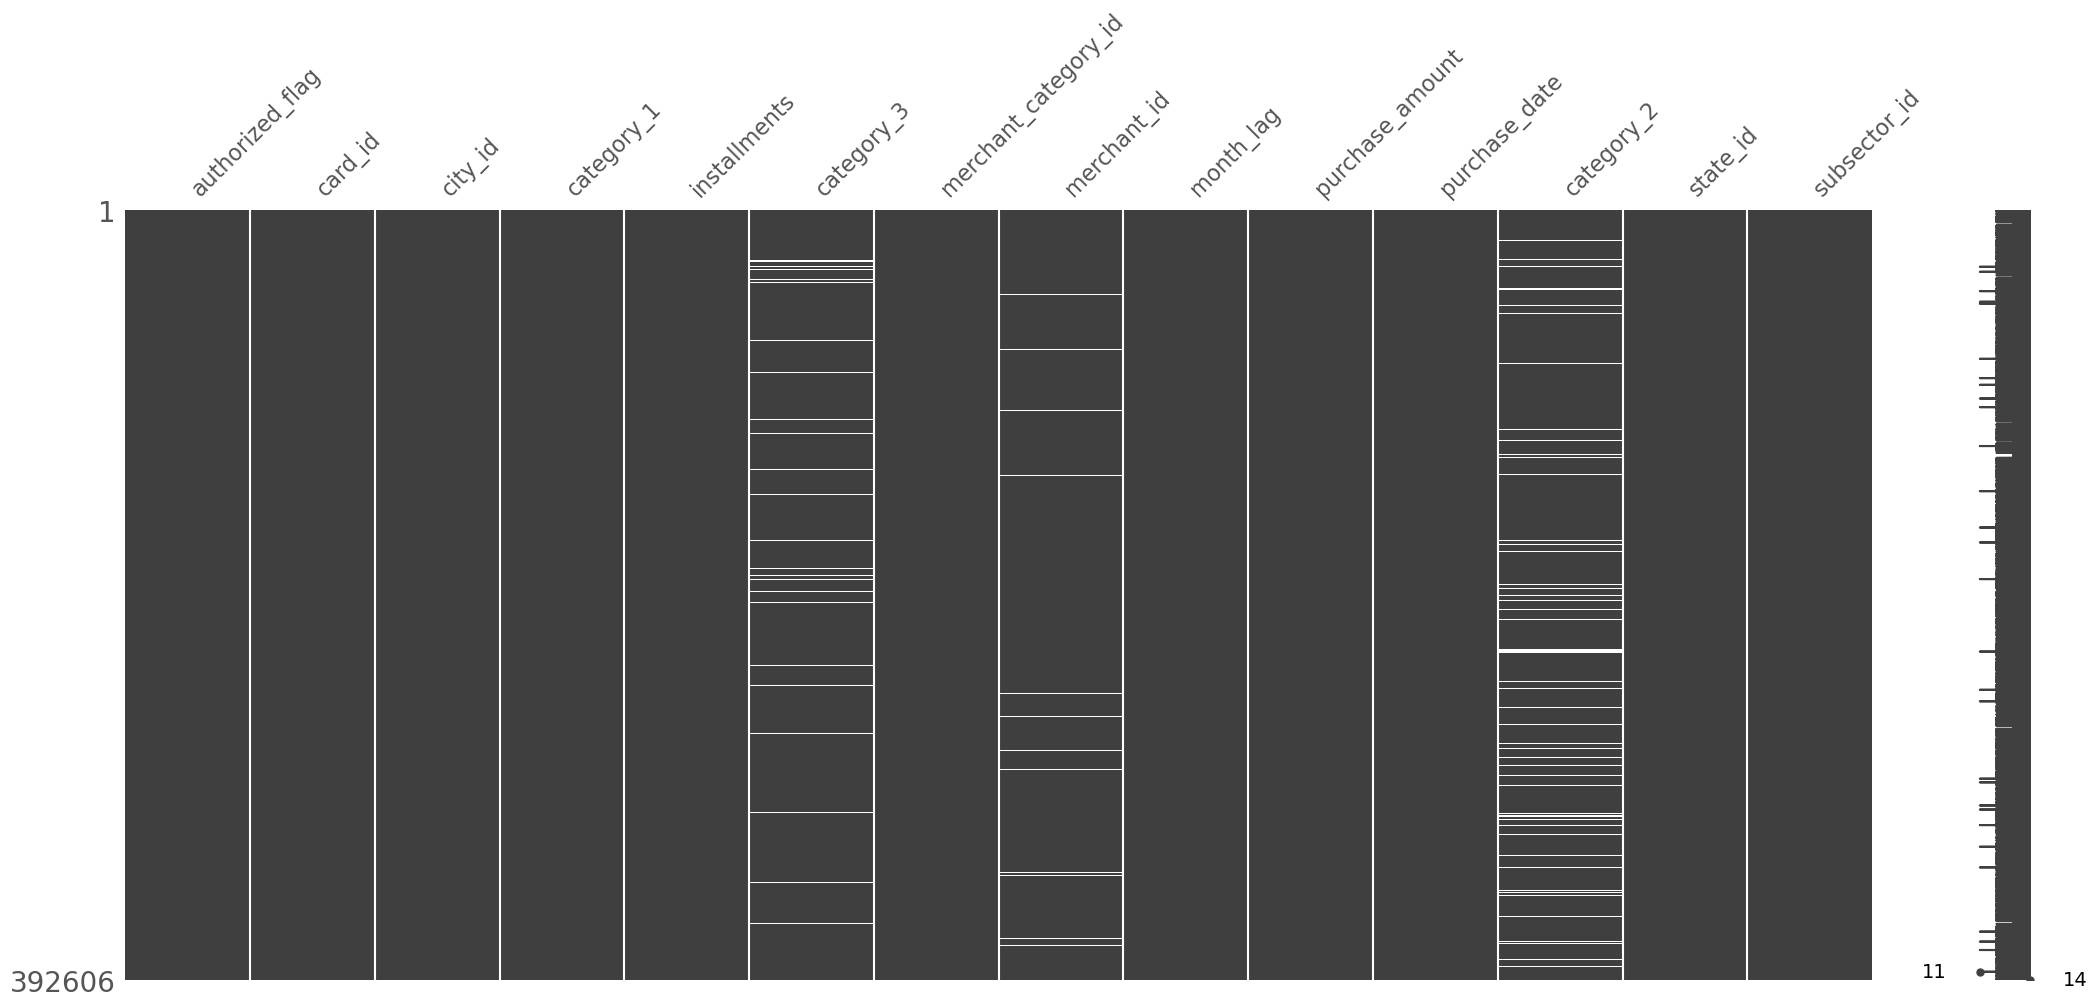

In [ ]:
# Create a visualization of the missing values
msno.matrix(df)

# Show the plot
plt.show()

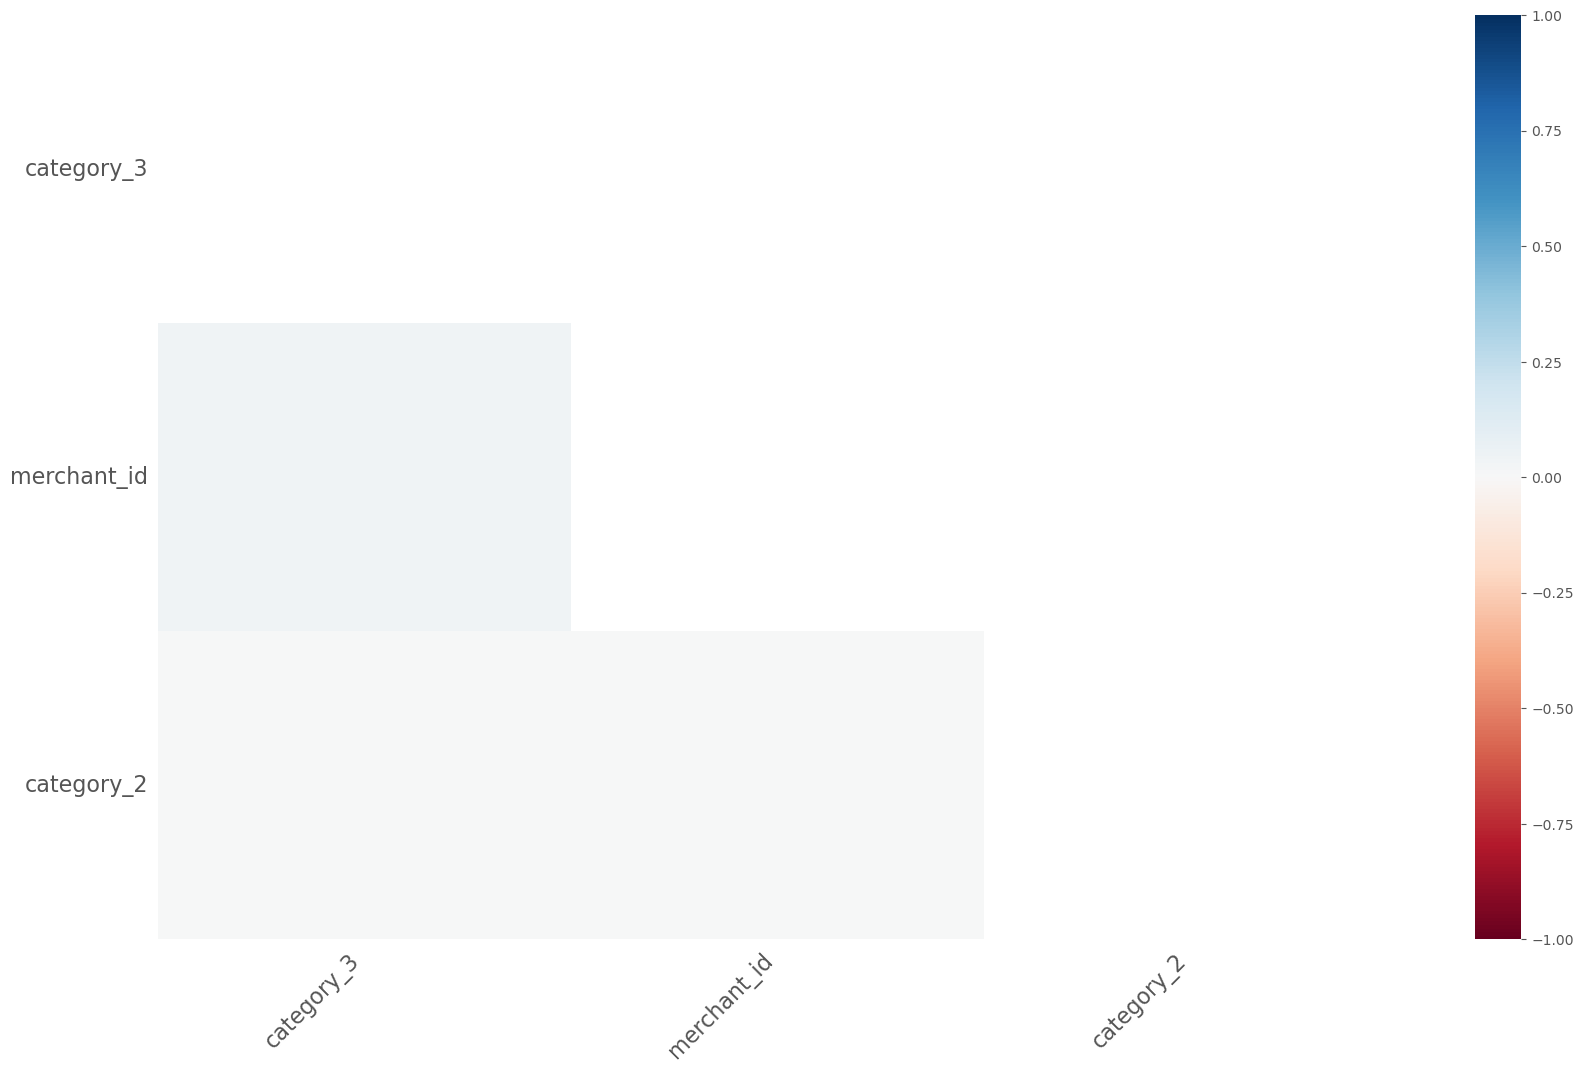

In [ ]:
# Create a heatmap of the correlation between missing values
msno.heatmap(df)

# Show the plot
plt.show()

In [ ]:
# Create a boolean mask for the null values in merchant_id column
mask1 = new_trans_df['merchant_id'].isnull()

# Create a boolean mask for the null values in category_2 column
mask2 = new_trans_df['category_2'].isnull()

# Create a boolean mask for the null values in category_3 column
mask3 = new_trans_df['category_3'].isnull()

# Combine the masks to check for the cases where all three columns have null values
combined_mask = mask1 & mask2 & mask3

# Count the number of rows where all three columns have null values
count = combined_mask.sum()

# Print the count
print(count)

131


In [ ]:
# Create a boolean mask for the null values in merchant_id column
mask1 = new_trans_df['merchant_id'].isnull()

# Create a boolean mask for the null values in category_2 column
#mask2 = new_trans_df['category_2'].isnull()

# Create a boolean mask for the null values in category_3 column
mask3 = new_trans_df['category_3'].isnull()

# Combine the masks to check for the cases where all three columns have null values
combined_mask = mask1 & mask3

# Count the number of rows where all three columns have null values
count = combined_mask.sum()

# Print the count
print(count)

2182


**Observations** 
- The "category_2" variable has missing values for approximately 6% of the observations

**Type of missing:**
- merchant_id, category_2, and category_3 are Completely ar Random

**Mechanism:** General 


### **History Merchant Transaction VS. New Transaction Data Analysis:**

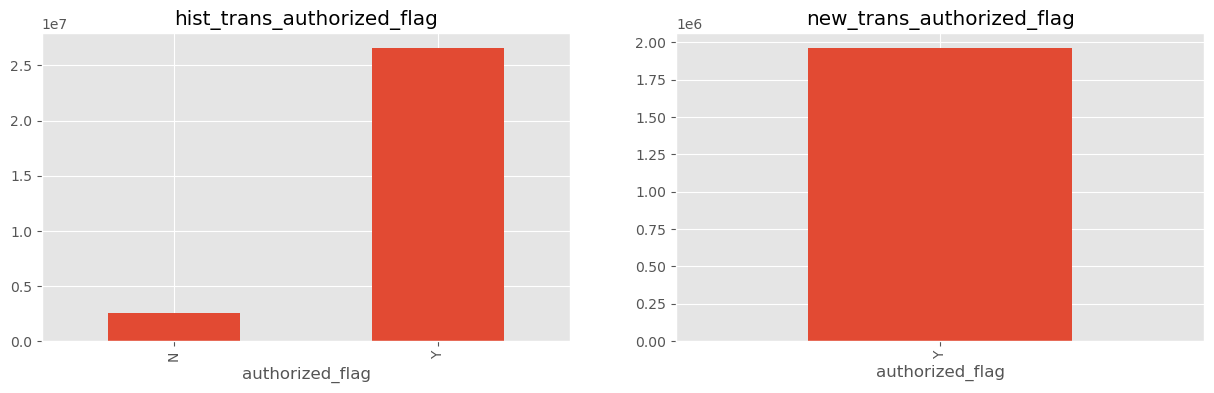

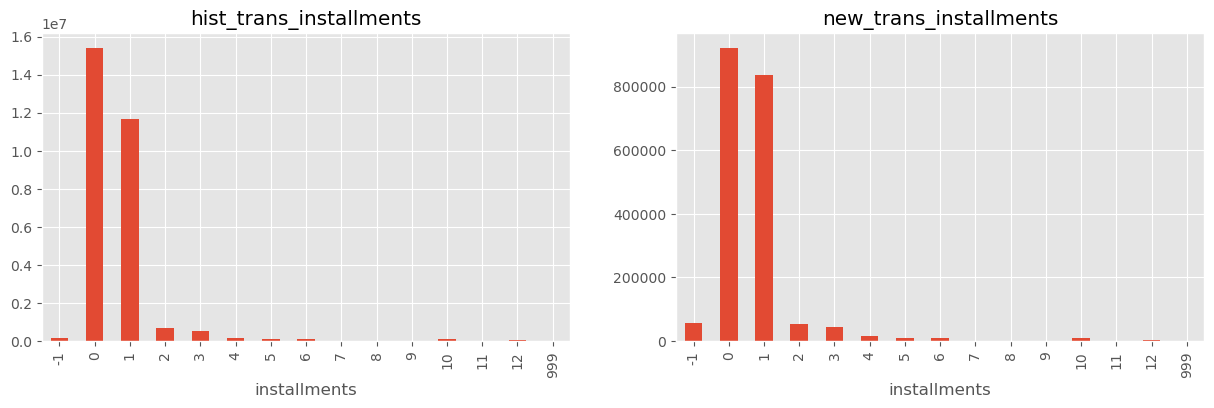

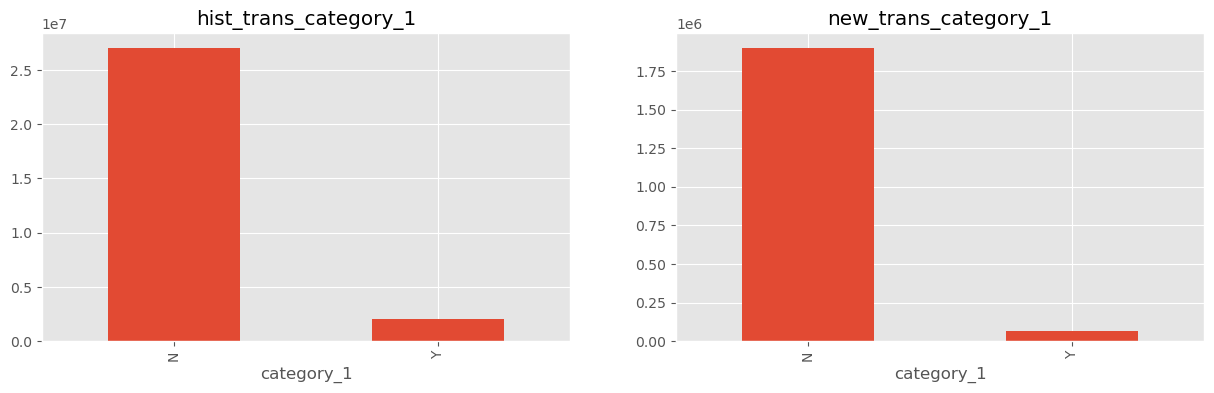

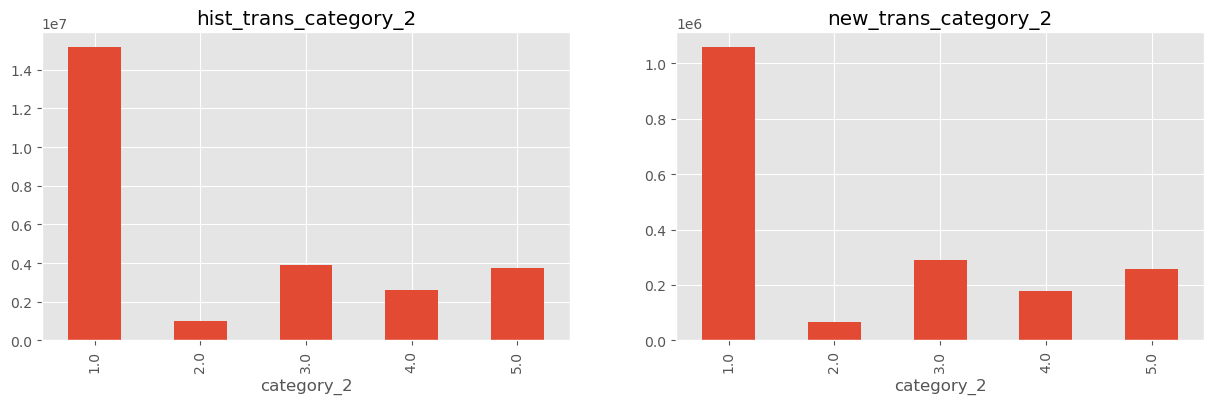

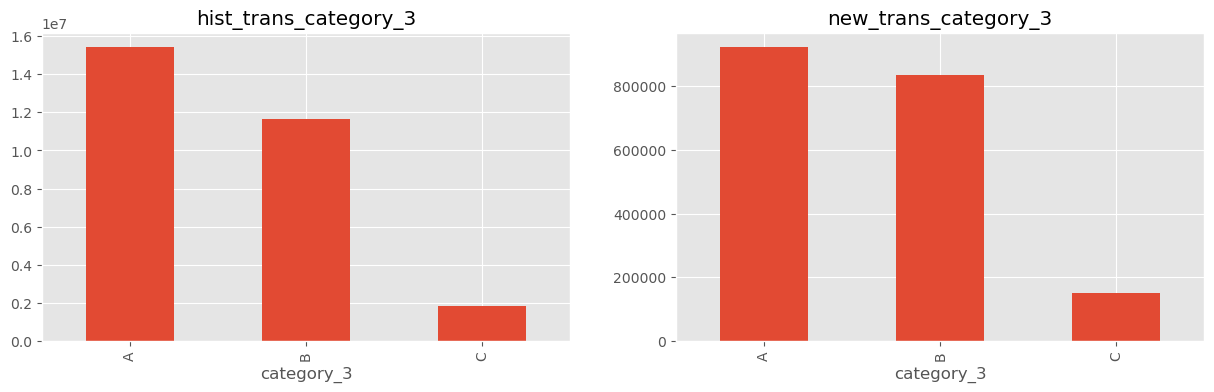

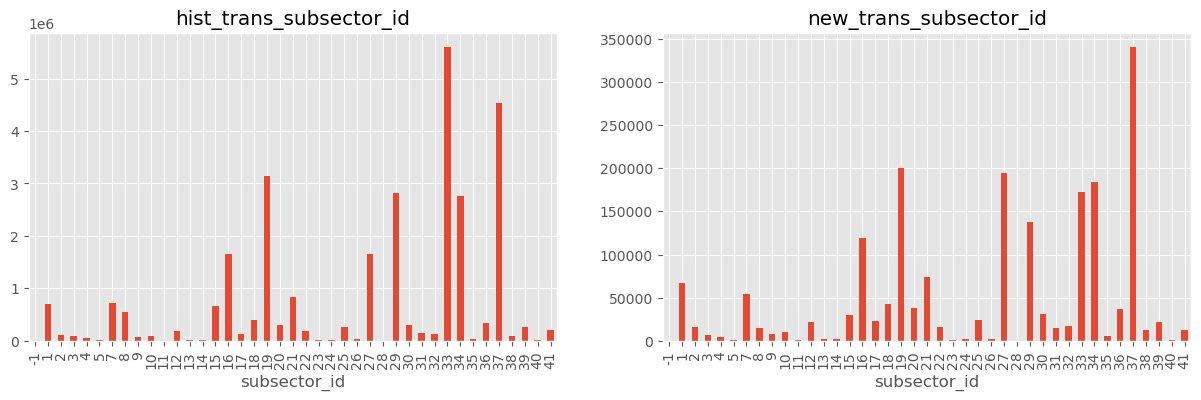

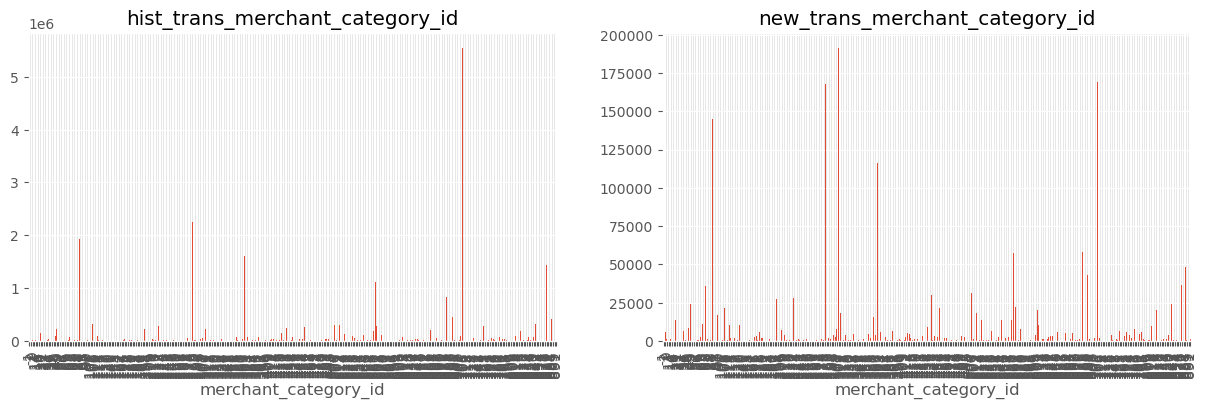

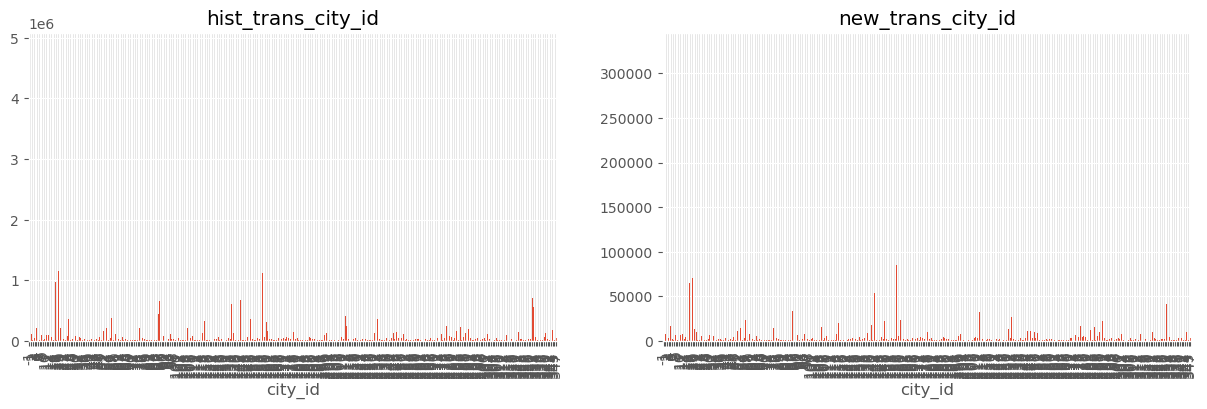

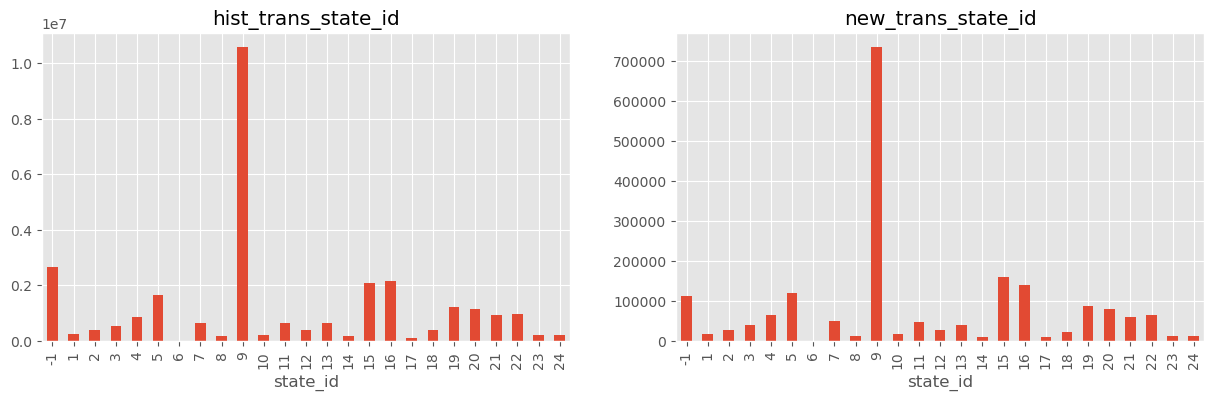

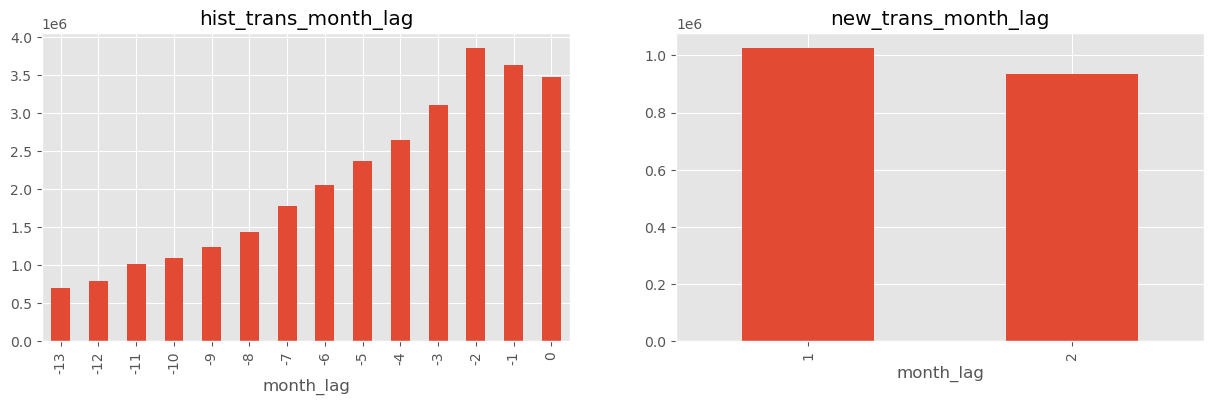

In [ ]:
# features distrubution in historical and new transactions
features = ['authorized_flag',
            'installments',
            'category_1',
            'category_2',
            'category_3',
            'subsector_id',
            'merchant_category_id',
            'city_id',
            'state_id',
            'month_lag']
for feature in features:
    fig, axes = plt.subplots(nrows=1, ncols=2)
    hist_trans_df.groupby(feature).count()['card_id'].plot(kind='bar',
                                                           title='hist_trans_{}'.format(feature),
                                                           figsize=(15, 4),
                                                           ax=axes[0])
    new_trans_df.groupby(feature).count()['card_id'].plot(kind='bar',
                                                          title='new_trans_{}'.format(feature),
                                                          figsize=(15, 4))
    plt.show()

**Observations** in authorized_flag and category_1 Most values are “Y”. we can remove this column as it is not having much significance on predicting loyalty score as all values are same.

In [ ]:
# number of unique card_id in historical transactions
hist_trans_card_id_list = hist_trans_df['card_id'].unique()
len(hist_trans_card_id_list)

325540

In [ ]:
# number of unique card_id in new transactions
new_trans_card_id_list = new_trans_df['card_id'].unique()
len(new_trans_card_id_list)

290001

In [ ]:
# number of unique card_id in userscore
usersc_card_id_list = usersc_df['card_id'].unique()
len(usersc_card_id_list)

201917

In [ ]:
# check if new card_id is subset of historical card_id
set(new_trans_card_id_list).issubset(set(hist_trans_card_id_list))

True

In [ ]:
# check if usersc_df card_id is subset of historical card_id
set(usersc_card_id_list).issubset(set(hist_trans_card_id_list))

True

In [ ]:
# check if usersc_df card_id is subset of new card_id
set(usersc_card_id_list).issubset(set(new_trans_card_id_list))

False

In [ ]:
# check the intersection of usersc_df and new card_id
len(set(usersc_card_id_list).intersection(set(new_trans_card_id_list)))

179986

In [ ]:
# number of unique merchant_id in historical transactions
hist_trans_merch_id_list = hist_trans_df['merchant_id'].unique()
len(hist_trans_merch_id_list)

326312

In [ ]:
# percent of missing merchant id in historical transactions
len(hist_trans_df[hist_trans_df['merchant_id'].notnull()]) / len(hist_trans_df)

0.995243223316721

In [ ]:
# number of unique merchant_id in new transactions
new_trans_merch_id_list = new_trans_df['merchant_id'].unique()
len(new_trans_merch_id_list)

226130

In [ ]:
# number of missing merchant id in new transactions
len(new_trans_df[new_trans_df['merchant_id'].notnull()]) / len(new_trans_df)

0.9866451421296963

In [ ]:
# check if new merchant_id is subset of historical card_id
set(new_trans_merch_id_list).issubset(set(hist_trans_merch_id_list))

False

In [ ]:
# check the intersection of historical and new merchant_id
len(set(new_trans_merch_id_list).intersection(set(hist_trans_merch_id_list)))

217808

In [ ]:
# number if unique of mechant_id, has duplicates, 334633 < 334696, with 33 duplicates
merchant_id_list = merch_df['merchant_id'].unique()
len(merchant_id_list)

334633

In [ ]:
# check missing values of features:
print('=================hist_trans_df====================')
print('authorized_flag missing #: ', len(hist_trans_df[hist_trans_df['authorized_flag'].isnull()]))
print('installments missing #: ', len(hist_trans_df[hist_trans_df['installments'].isnull()]))
print('category_1 missing #: ', len(hist_trans_df[hist_trans_df['category_1'].isnull()]))
print('category_2 missing #: ', len(hist_trans_df[hist_trans_df['category_2'].isnull()]))
print('category_3 missing #: ', len(hist_trans_df[hist_trans_df['category_3'].isnull()]))
print('subsector_id missing #: ', len(hist_trans_df[hist_trans_df['subsector_id'].isnull()]))
print('merchant_category_id missing #: ', len(hist_trans_df[hist_trans_df['merchant_category_id'].isnull()]))
print('city_id missing #: ', len(hist_trans_df[hist_trans_df['city_id'].isnull()]))
print('state_id missing #: ', len(hist_trans_df[hist_trans_df['state_id'].isnull()]))
print('month_lag missing #: ', len(hist_trans_df[hist_trans_df['month_lag'].isnull()]))
print('purchase_amount missing #: ', len(hist_trans_df[hist_trans_df['purchase_amount'].isnull()]))
print('purchase_date missing #: ', len(hist_trans_df[hist_trans_df['purchase_date'].isnull()]))
print('=================new_trans_df====================')
print('authorized_flag missing #: ', len(new_trans_df[new_trans_df['authorized_flag'].isnull()]))
print('installments missing #: ', len(new_trans_df[new_trans_df['installments'].isnull()]))
print('category_1 missing #: ', len(new_trans_df[new_trans_df['category_1'].isnull()]))
print('category_2 missing #: ', len(new_trans_df[new_trans_df['category_2'].isnull()]))
print('category_3 missing #: ', len(new_trans_df[new_trans_df['category_3'].isnull()]))
print('subsector_id missing #: ', len(new_trans_df[new_trans_df['subsector_id'].isnull()]))
print('merchant_category_id missing #: ', len(new_trans_df[new_trans_df['merchant_category_id'].isnull()]))
print('city_id missing #: ', len(new_trans_df[new_trans_df['city_id'].isnull()]))
print('state_id missing #: ', len(new_trans_df[new_trans_df['state_id'].isnull()]))
print('month_lag missing #: ', len(new_trans_df[new_trans_df['month_lag'].isnull()]))
print('purchase_amount missing #: ', len(new_trans_df[new_trans_df['purchase_amount'].isnull()]))
print('purchase_date missing #: ', len(new_trans_df[new_trans_df['purchase_date'].isnull()]))
print('=================merch_df====================')
print('category_4 missing #: ', len(merch_df[merch_df['category_4'].isnull()]))
print('merchant_group_id missing #: ', len(merch_df[merch_df['merchant_group_id'].isnull()]))

=================hist_trans_df====================
authorized_flag missing #:  0
installments missing #:  0
category_1 missing #:  0
category_2 missing #:  2652864
category_3 missing #:  178159
subsector_id missing #:  0
merchant_category_id missing #:  0
city_id missing #:  0
state_id missing #:  0
month_lag missing #:  0
purchase_amount missing #:  0
purchase_date missing #:  0
=================new_trans_df====================
authorized_flag missing #:  0
installments missing #:  0
category_1 missing #:  0
category_2 missing #:  111745
category_3 missing #:  55922
subsector_id missing #:  0
merchant_category_id missing #:  0
city_id missing #:  0
state_id missing #:  0
month_lag missing #:  0
purchase_amount missing #:  0
purchase_date missing #:  0
=================merch_df====================
category_4 missing #:  0
merchant_group_id missing #:  0


In [ ]:
# show dataframe types
hist_trans_df.dtypes

authorized_flag                 object
card_id                         object
city_id                          int64
category_1                      object
installments                     int64
category_3                      object
merchant_category_id             int64
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                     float64
state_id                         int64
subsector_id                     int64
dtype: object

In [ ]:
# convert the columns into correct format
hist_trans_df['authorized_flag'] = hist_trans_df['authorized_flag'].astype('category')
hist_trans_df['city_id'] = hist_trans_df['city_id'].astype('category')
hist_trans_df['category_1'] = hist_trans_df['category_1'].astype('category')
hist_trans_df['category_3'] = hist_trans_df['category_3'].astype('category')
hist_trans_df['merchant_category_id'] = hist_trans_df['merchant_category_id'].astype('category')
hist_trans_df['purchase_date'] = pd.to_datetime(hist_trans_df['purchase_date'])
hist_trans_df['category_2'] = hist_trans_df['category_2'].astype('category')
hist_trans_df['state_id'] = hist_trans_df['state_id'].astype('category')
hist_trans_df['subsector_id'] = hist_trans_df['subsector_id'].astype('category')
hist_trans_df.dtypes

authorized_flag               category
card_id                         object
city_id                       category
category_1                    category
installments                     int64
category_3                    category
merchant_category_id          category
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                    category
state_id                      category
subsector_id                  category
dtype: object

In [ ]:
# show dataframe types
new_trans_df.dtypes

authorized_flag                 object
card_id                         object
city_id                          int64
category_1                      object
installments                     int64
category_3                      object
merchant_category_id             int64
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                     float64
state_id                         int64
subsector_id                     int64
dtype: object

In [ ]:
# convert the columns into correct format
new_trans_df['authorized_flag'] = new_trans_df['authorized_flag'].astype('category')
new_trans_df['city_id'] = new_trans_df['city_id'].astype('category')
new_trans_df['category_1'] = new_trans_df['category_1'].astype('category')
new_trans_df['category_3'] = new_trans_df['category_3'].astype('category')
new_trans_df['merchant_category_id'] = new_trans_df['merchant_category_id'].astype('category')
new_trans_df['purchase_date'] = pd.to_datetime(new_trans_df['purchase_date'])
new_trans_df['category_2'] = new_trans_df['category_2'].astype('category')
new_trans_df['state_id'] = new_trans_df['state_id'].astype('category')
new_trans_df['subsector_id'] = new_trans_df['subsector_id'].astype('category')

In [ ]:
# show dataframe types
new_trans_df.dtypes

authorized_flag               category
card_id                         object
city_id                       category
category_1                    category
installments                     int64
category_3                    category
merchant_category_id          category
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                    category
state_id                      category
subsector_id                  category
dtype: object

In [ ]:
# fill in some missing values
hist_trans_df['category_2'] = hist_trans_df['category_2'].cat.add_categories(-999).fillna(-999)
hist_trans_df['category_3'] = hist_trans_df['category_3'].cat.add_categories('X').fillna('X')
new_trans_df['category_2'] = new_trans_df['category_2'].cat.add_categories(-999).fillna(-999)
new_trans_df['category_3'] = new_trans_df['category_3'].cat.add_categories('X').fillna('X')

In [ ]:
# minimum and maxmium values in historical and new transactions 
print('Minimum purchase amount in historical transaction: ', min(hist_trans_df['purchase_amount']))
print('Maxmium purchase amount in historical transaction: ', max(hist_trans_df['purchase_amount']))
print('Minimum purchase amount in New transaction: ', min(new_trans_df['purchase_amount']))
print('Maximum purchase amount in New transaction: ', max(new_trans_df['purchase_amount']))

Minimum purchase amount in historical transaction:  -0.7469078
Maxmium purchase amount in historical transaction:  6010603.9717525
Minimum purchase amount in New transaction:  -0.74689277
Maximum purchase amount in New transaction:  263.15749789


In [ ]:
# most of the purchase amount are less than 1
print('Percent of purchase_amount < 1 in historical transactions: ',
      len(hist_trans_df[hist_trans_df['purchase_amount'] < 1]) / len(hist_trans_df))
print('Percent of purchase_amount < 1 in new transactions: ',
      len(new_trans_df[new_trans_df['purchase_amount'] < 1]) / len(new_trans_df))

Percent of purchase_amount < 1 in historical transactions:  0.9880562761639291
Percent of purchase_amount < 1 in new transactions:  0.985838736117769


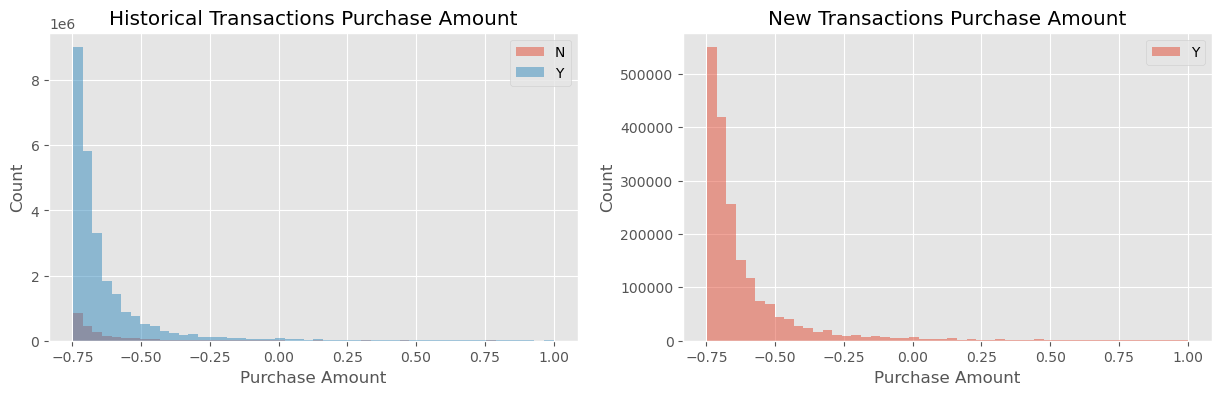

In [ ]:
# create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# plot purchase amount distribution in historical transactions
hist_trans_df[hist_trans_df['purchase_amount'] < 1]\
    .groupby('authorized_flag')['purchase_amount']\
    .plot(kind='hist',
          bins=50,
          alpha=0.5,
          legend=True,
          title='Historical Transactions Purchase Amount',
          ax=axes[0])

# plot purchase amount distribution in new transactions
new_trans_df[new_trans_df['purchase_amount'] < 1]\
    .groupby('authorized_flag')['purchase_amount']\
    .plot(kind='hist',
          bins=50,
          alpha=0.5,
          legend=True,
          title='New Transactions Purchase Amount',
          ax=axes[1])

# set common x and y labels for the subplots
for ax in axes:
    ax.set_xlabel('Purchase Amount')
    ax.set_ylabel('Count')

# display the plot
plt.show()

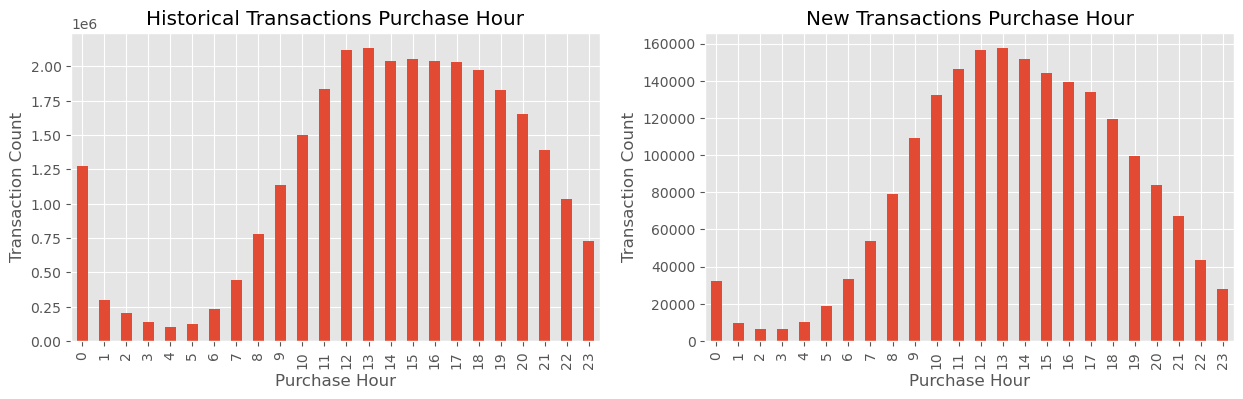

In [ ]:
# create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# plot purchase hour distribution in historical transactions
hist_trans_df.groupby(hist_trans_df['purchase_date'].dt.hour)\
    .size()\
    .plot(kind='bar',
          title='Historical Transactions Purchase Hour',
          ax=axes[0])

# plot purchase hour distribution in new transactions
new_trans_df.groupby(new_trans_df['purchase_date'].dt.hour)\
    .size()\
    .plot(kind='bar',
          title='New Transactions Purchase Hour',
          ax=axes[1])

# set common x and y labels for the subplots
for ax in axes:
    ax.set_xlabel('Purchase Hour')
    ax.set_ylabel('Transaction Count')

# display the plot
plt.show()

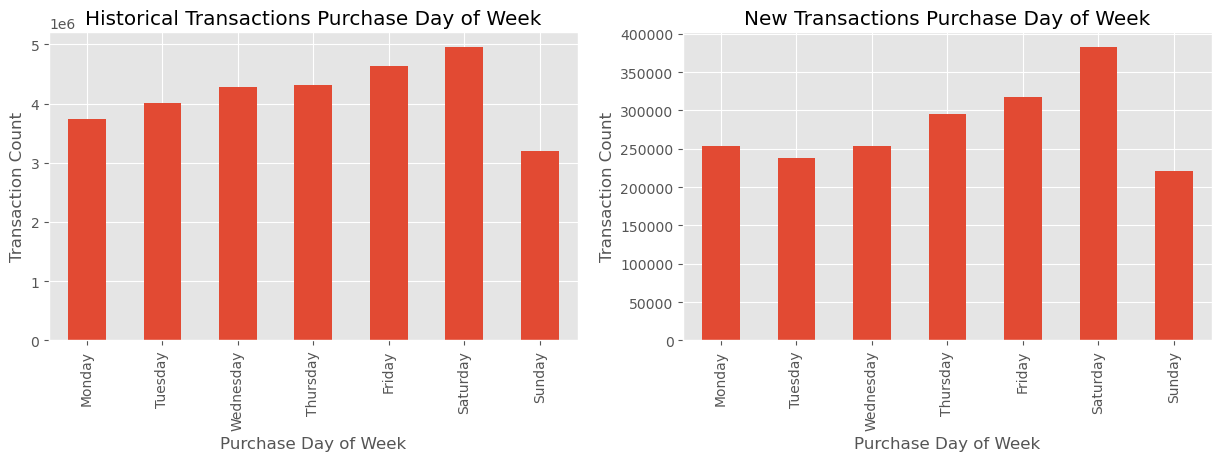

In [ ]:
# create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# define a list of weekday names
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# plot purchase day of week distribution in historical transactions
hist_trans_df.groupby(hist_trans_df['purchase_date'].dt.dayofweek)\
    .size()\
    .rename(index=lambda x: weekday_names[x])\
    .plot(kind='bar',
          title='Historical Transactions Purchase Day of Week',
          ax=axes[0])

# plot purchase day of week distribution in new transactions
new_trans_df.groupby(new_trans_df['purchase_date'].dt.dayofweek)\
    .size()\
    .rename(index=lambda x: weekday_names[x])\
    .plot(kind='bar',
          title='New Transactions Purchase Day of Week',
          ax=axes[1])

# set common x and y labels for the subplots
for ax in axes:
    ax.set_xlabel('Purchase Day of Week')
    ax.set_ylabel('Transaction Count')

# display the plot
plt.show()

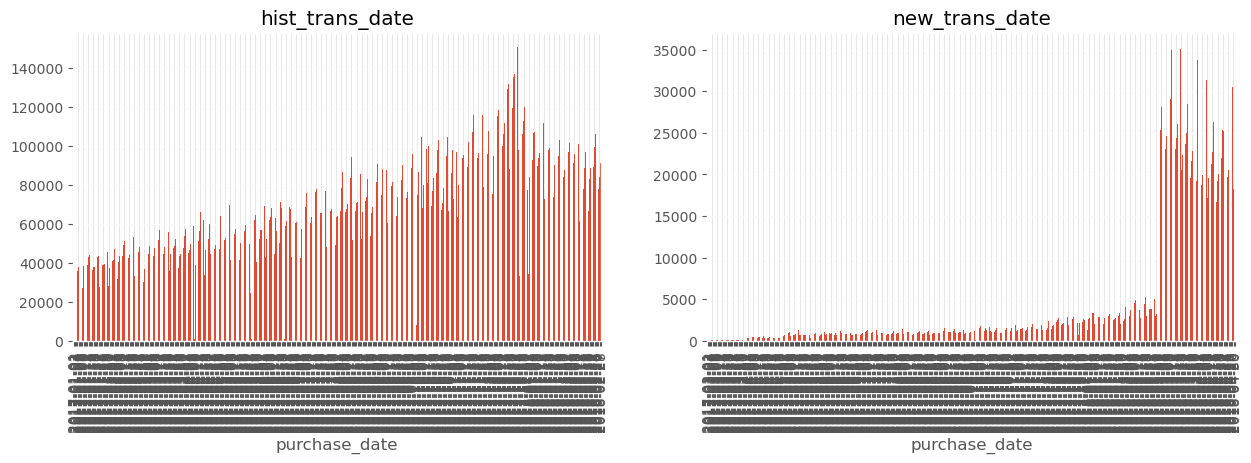

In [ ]:
# purchase date distribution in historical and new transactions
fig, axes = plt.subplots(nrows=1, ncols=2) 
hist_trans_df.groupby(hist_trans_df['purchase_date'].dt.date)\
    .count()['card_id']\
    .plot(kind='bar',
          title='hist_trans_date',
          figsize=(15, 4),
          ax=axes[0])
new_trans_df.groupby(new_trans_df['purchase_date'].dt.date)\
    .count()['card_id']\
    .plot(kind='bar',
          title='new_trans_date',
          figsize=(15, 4))
plt.show()

**Observations**

- authorized_flag column in historical transactions can be removed.
- Most purchase amounts in historical transactions are between 0-50, with a few outliers.
- Values of -1 and 999 in the installments column of historical transactions maybe errors or wrong entries.
- The null values in category_2, category_3, and merchant_id columns of historical transactions need to be handled.
- Purchases in historical transactions are highest on Saturdays and lowest at the end of the month, with the highest number of purchases in March and April.
- The highest purchases in historical transactions were made in January, February, and December, while in new merchant transaction data, the highest purchases were made in March and April.

# **Merging the Datasets**

**data merging steps:**

- Concatenate hist_trans_df and new_trans_df dataframes to create a single transaction dataframe.
- Merge the transaction dataframe with the merch_df dataframe using an outer join to create a unified view of the customer's behavior that includes information about the merchants they interacted with.
- Merge the usersc_df dataframe with the merged transaction and merchant dataframe using a left join to include all customers in the final merged dataframe, even if they haven't made transactions with the merchants in the merch_df dataframe.
- The resulting merged dataframe can be used to build models that predict customer loyalty based on their transactions and interactions with merchants.

In [ ]:
#Drop unnecessary columns before merging
usersc_df.drop(['first_active_month'], axis=1, inplace=True)
merch_df.drop(['merchant_group_id', 'subsector_id'], axis=1, inplace=True)
hist_trans_df.drop(['authorized_flag', 'category_1', 'category_2', 'category_3', 'city_id', 'state_id'], axis=1, inplace=True)
new_trans_df.drop(['authorized_flag', 'category_1', 'category_2', 'category_3', 'city_id', 'state_id'], axis=1, inplace=True)

In [ ]:
#concatenate hist_trans_df and new_trans_df
trans_df = pd.concat([hist_trans_df, new_trans_df], axis=0, ignore_index=True)

In [ ]:
# perform full outer join with merch_df
merged_df = pd.merge(trans_df, merch_df, on='merchant_id', how='outer')

In [ ]:
# perform left join with usersc_df
final_df = pd.merge(usersc_df, merged_df, on='card_id', how='left')

In [ ]:
final_df.head()

card_id  feature_1  feature_2  feature_3         score  year   
0  C_ID_92a2005557          5          2          1 -0.8202826000  2017  \
1  C_ID_92a2005557          5          2          1 -0.8202826000  2017   
2  C_ID_92a2005557          5          2          1 -0.8202826000  2017   
3  C_ID_92a2005557          5          2          1 -0.8202826000  2017   
4  C_ID_92a2005557          5          2          1 -0.8202826000  2017   

   month  installments  merchant_category_id_x      merchant_id  ...   
0      6             0                     879  M_ID_00a6ca8a8a  ...  \
1      6             0                     879  M_ID_00a6ca8a8a  ...   
2      6             0                     879  M_ID_00a6ca8a8a  ...   
3      6             0                     879  M_ID_00a6ca8a8a  ...   
4      6             0                     879  M_ID_00a6ca8a8a  ...   

   avg_sales_lag6  avg_purchases_lag6 active_months_lag6 avg_sales_lag12   
0    8.4200000000       15.8557692300       6.0000000000    8.5700000000  \
1    0.8600000000        0.8712141400       6.0000000000    0.7600000000   
2    8.4200000000       15.8557692300       6.0000000000    8.5700000000   
3    0.8600000000        0.8712141400       6.0000000000    0.7600000000   
4    8.4200000000       15.8557692300       6.0000000000    8.5700000000   

   avg_purchases_lag12  active_months_lag12   category_4       city_id   
0        16.2197802200         7.0000000000 1.0000000000 -1.0000000000  \
1         0.7526406600        12.0000000000 1.0000000000 -1.0000000000   
2        16.2197802200         7.0000000000 1.0000000000 -1.0000000000   
3         0.7526406600        12.0000000000 1.0000000000 -1.0000000000   
4        16.2197802200         7.0000000000 1.0000000000 -1.0000000000   

       state_id category_2  
0 -1.0000000000        NaN  
1 -1.0000000000        NaN  
2 -1.0000000000        NaN  
3 -1.0000000000        NaN  
4 -1.0000000000        NaN  

[5 rows x 33 columns]

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20025733 entries, 0 to 20025732
Data columns (total 33 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   card_id                      object        
 1   feature_1                    int64         
 2   feature_2                    int64         
 3   feature_3                    int64         
 4   score                        float64       
 5   year                         int32         
 6   month                        int32         
 7   installments                 int64         
 8   merchant_category_id_x       int64         
 9   merchant_id                  object        
 10  month_lag                    int64         
 11  purchase_amount              float64       
 12  purchase_date                datetime64[ns]
 13  subsector_id                 category      
 14  merchant_category_id_y       float64       
 15  numerical_1                  float64       
 16

In [ ]:
final_df.isna().sum()

card_id                              0
feature_1                            0
feature_2                            0
feature_3                            0
score                                0
year                                 0
month                                0
installments                         0
merchant_category_id_x               0
merchant_id                     102297
month_lag                            0
purchase_amount                      0
purchase_date                        0
subsector_id                         0
merchant_category_id_y          102297
numerical_1                     102297
numerical_2                     102297
category_1                      102297
most_recent_sales_range         102297
most_recent_purchases_range     102297
avg_sales_lag3                  108140
avg_purchases_lag3              102297
active_months_lag3              102297
avg_sales_lag6                  108140
avg_purchases_lag6              102297
active_months_lag6       

In [ ]:
#Drop unnecessary columns after merging
final_df.drop(['merchant_category_id_x','merchant_id','subsector_id','merchant_category_id_y','city_id','category_2','state_id','purchase_date'], axis=1, inplace=True)

In [ ]:
final_df.isna().sum()

card_id                             0
feature_1                           0
feature_2                           0
feature_3                           0
score                               0
year                                0
month                               0
installments                        0
month_lag                           0
purchase_amount                     0
numerical_1                    102297
numerical_2                    102297
category_1                     102297
most_recent_sales_range        102297
most_recent_purchases_range    102297
avg_sales_lag3                 108140
avg_purchases_lag3             102297
active_months_lag3             102297
avg_sales_lag6                 108140
avg_purchases_lag6             102297
active_months_lag6             102297
avg_sales_lag12                108140
avg_purchases_lag12            102297
active_months_lag12            102297
category_4                     102297
dtype: int64

### **Check Missing Values**

/opt/conda/lib/python3.9/site-packages/matplotlib/image.py:180: UserWarning: Data with more than 2**24 rows cannot be accurately displayed. Downsampling to less than 2**24 rows before displaying. To remove this warning, manually downsample your data.
  warnings.warn(msg.format(n='2**24 rows'))


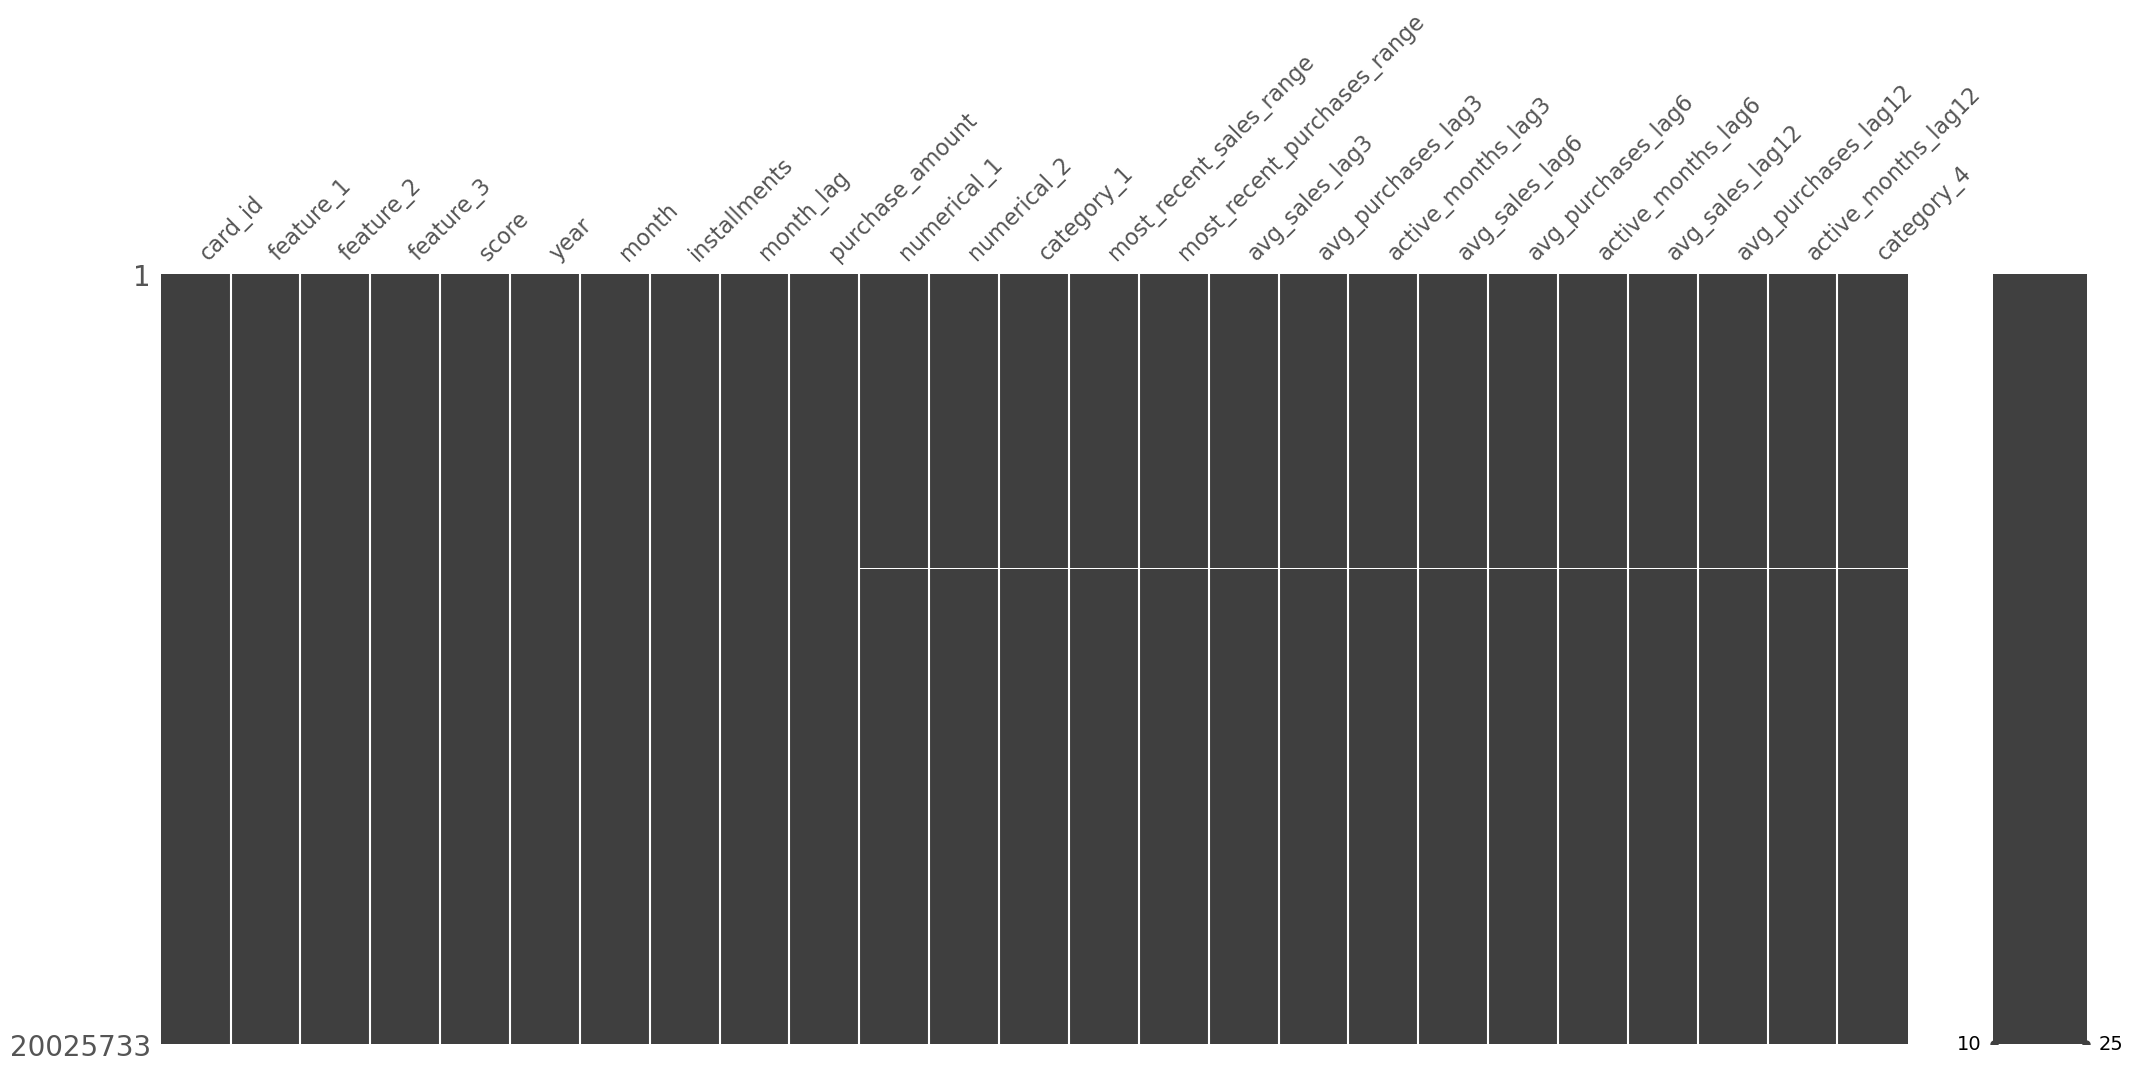

In [ ]:
# Create a visualization of the missing values
msno.matrix(final_df)

# Show the plot
plt.show()

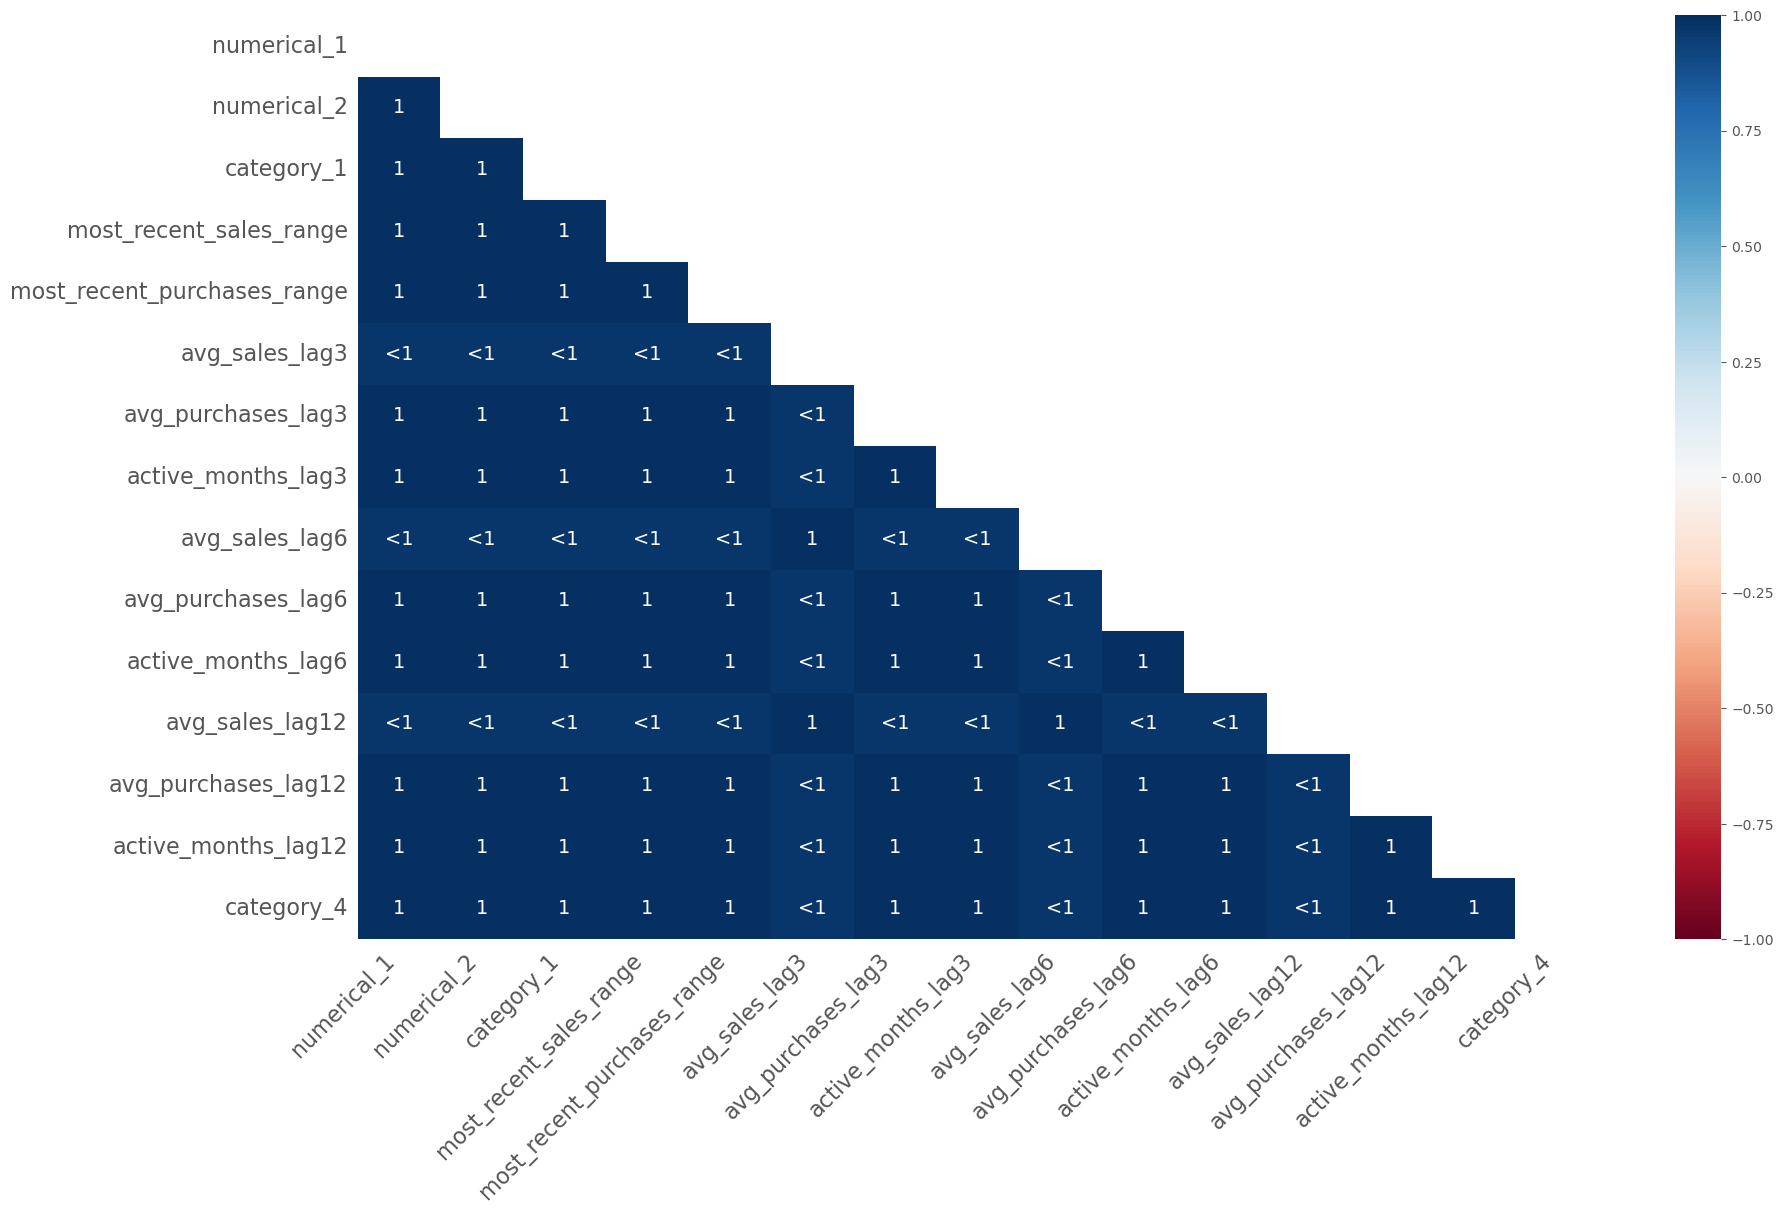

In [ ]:
# Create a heatmap of the correlation between missing values
msno.heatmap(final_df)

# Show the plot
plt.show()

In [ ]:
# Create a boolean mask for the null values in each column
null_mask = final_df[['numerical_1', 'numerical_2', 'category_1', 'most_recent_sales_range', 'most_recent_purchases_range',
                      'avg_purchases_lag3', 'active_months_lag3', 'active_months_lag6', 'avg_purchases_lag12', 'category_4']].isnull()

# Combine the masks to check for the cases where all columns have null values
combined_mask = null_mask.all(axis=1)

# Count the number of rows where all columns have null values
count = combined_mask.sum()

# Print the count
print(count)

102297


In [ ]:
# Create a boolean mask for the null values in each column
null_mask = final_df[['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']].isnull()

# Combine the masks to check for the cases where all columns have null values
combined_mask = null_mask.all(axis=1)

# Count the number of rows where all columns have null values
count = combined_mask.sum()

# Print the count
print(count)

108140


In [ ]:
# create a copy of the original DataFrame
final_df_copy = final_df.copy()

# drop rows with missing values in place
final_df_copy.dropna(inplace=True)

In [ ]:
final_df_copy.isna().sum()

card_id                        0
feature_1                      0
feature_2                      0
feature_3                      0
score                          0
year                           0
month                          0
installments                   0
month_lag                      0
purchase_amount                0
numerical_1                    0
numerical_2                    0
category_1                     0
most_recent_sales_range        0
most_recent_purchases_range    0
avg_sales_lag3                 0
avg_purchases_lag3             0
active_months_lag3             0
avg_sales_lag6                 0
avg_purchases_lag6             0
active_months_lag6             0
avg_sales_lag12                0
avg_purchases_lag12            0
active_months_lag12            0
category_4                     0
dtype: int64

**Observations** 

There are 1022973 rows where all the null values in these columns ('numerical_1', 'numerical_2', 'category_1', 'most_recent_sales_range', 'most_recent_purchases_range',
                      'avg_purchases_lag3', 'active_months_lag3', 'active_months_lag6', 'avg_purchases_lag12', 'category_4') have null values and occur together. 

here are 108140 rows in the dataset where all four columns ('avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12') have null values, and the null values in these columns occur together.


**Type of missing:**
- ('numerical_1', 'numerical_2', 'category_1', 'most_recent_sales_range', 'most_recent_purchases_range',
                      'avg_purchases_lag3', 'active_months_lag3', 'active_months_lag6', 'avg_purchases_lag12', 'category_4') are at Random
- ('avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12') are at Random

**Mechanism:** General 


In [ ]:
final_df_copy.duplicated().sum()

1521920

In [ ]:
# remove duplicate rows from final_df_copy in place
final_df_copy.drop_duplicates(inplace=True)

In [ ]:
final_df_copy.duplicated().sum()

0

In [ ]:
final_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18395673 entries, 0 to 20025732
Data columns (total 25 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   card_id                      object 
 1   feature_1                    int64  
 2   feature_2                    int64  
 3   feature_3                    int64  
 4   score                        float64
 5   year                         int32  
 6   month                        int32  
 7   installments                 int64  
 8   month_lag                    int64  
 9   purchase_amount              float64
 10  numerical_1                  float64
 11  numerical_2                  float64
 12  category_1                   object 
 13  most_recent_sales_range      object 
 14  most_recent_purchases_range  object 
 15  avg_sales_lag3               float64
 16  avg_purchases_lag3           float64
 17  active_months_lag3           float64
 18  avg_sales_lag6               float64
 19  avg

### **Correlation Analysis**

In [ ]:
# Select all numerical columns in the merchants DataFrame
numerical_features = final_df_copy.select_dtypes(include=['float64', 'int64'])

# Display the first 10 rows of the numerical features
print(numerical_features.head(10))

   feature_1  feature_2  feature_3         score  installments  month_lag   
0          5          2          1 -0.8202826000             0          0  \
1          5          2          1 -0.8202826000             0          0   
2          5          2          1 -0.8202826000             0         -2   
3          5          2          1 -0.8202826000             0         -2   
4          5          2          1 -0.8202826000             0          0   
5          5          2          1 -0.8202826000             0          0   
6          5          2          1 -0.8202826000             0         -3   
7          5          2          1 -0.8202826000             0         -3   
8          5          2          1 -0.8202826000             0         -3   
9          5          2          1 -0.8202826000             0         -3   

   purchase_amount   numerical_1   numerical_2  avg_sales_lag3   
0    -0.7078989700 -0.0475557500 -0.0574706500    6.9300000000  \
1    -0.7078989700 -

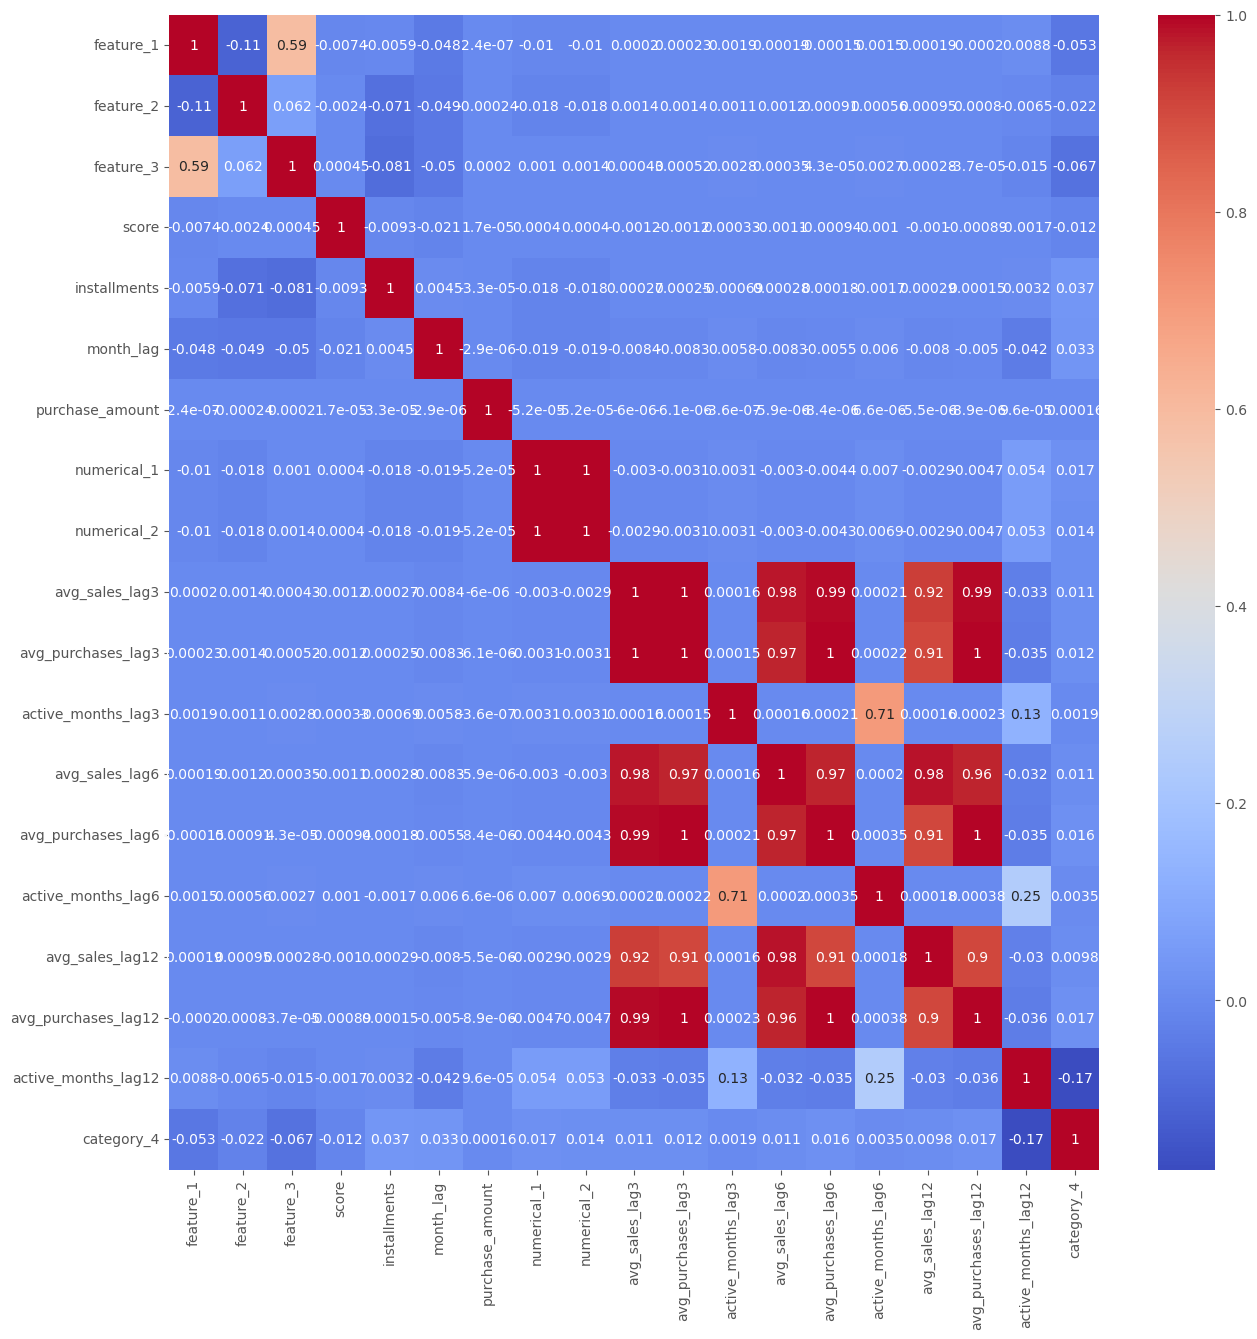

In [ ]:
# Calculate the correlation matrix
corr_matrix = numerical_features.corr()

# Create a larger figure
plt.figure(figsize=(15, 15))

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

# Show the plot
plt.show()

### **Handle Multicollinearity**

In [ ]:
# Stack the correlation matrix into a multi-index series
stacked_corr = corr_matrix.stack()

# Select only the pairs of features that have a correlation greater than 0.9 and are not equal to 1.0
high_corr = stacked_corr[(stacked_corr > 0.9) & (stacked_corr != 1.0)]

# Get the names of the highly correlated features
high_corr_names = high_corr.reset_index()[['level_0', 'level_1']].apply(tuple, axis=1).tolist()

# Print the names of the highly correlated features
print(high_corr_names)

[('numerical_1', 'numerical_2'), ('numerical_2', 'numerical_1'), ('avg_sales_lag3', 'avg_purchases_lag3'), ('avg_sales_lag3', 'avg_sales_lag6'), ('avg_sales_lag3', 'avg_purchases_lag6'), ('avg_sales_lag3', 'avg_sales_lag12'), ('avg_sales_lag3', 'avg_purchases_lag12'), ('avg_purchases_lag3', 'avg_sales_lag3'), ('avg_purchases_lag3', 'avg_sales_lag6'), ('avg_purchases_lag3', 'avg_purchases_lag6'), ('avg_purchases_lag3', 'avg_sales_lag12'), ('avg_purchases_lag3', 'avg_purchases_lag12'), ('avg_sales_lag6', 'avg_sales_lag3'), ('avg_sales_lag6', 'avg_purchases_lag3'), ('avg_sales_lag6', 'avg_purchases_lag6'), ('avg_sales_lag6', 'avg_sales_lag12'), ('avg_sales_lag6', 'avg_purchases_lag12'), ('avg_purchases_lag6', 'avg_sales_lag3'), ('avg_purchases_lag6', 'avg_purchases_lag3'), ('avg_purchases_lag6', 'avg_sales_lag6'), ('avg_purchases_lag6', 'avg_sales_lag12'), ('avg_purchases_lag6', 'avg_purchases_lag12'), ('avg_sales_lag12', 'avg_sales_lag3'), ('avg_sales_lag12', 'avg_purchases_lag3'), ('avg

In [ ]:
unique_pairs = []
for pair in high_corr_names:
    if (pair[1], pair[0]) not in unique_pairs:
        unique_pairs.append(pair)

In [ ]:
unique_pairs

[('numerical_1', 'numerical_2'),
 ('avg_sales_lag3', 'avg_purchases_lag3'),
 ('avg_sales_lag3', 'avg_sales_lag6'),
 ('avg_sales_lag3', 'avg_purchases_lag6'),
 ('avg_sales_lag3', 'avg_sales_lag12'),
 ('avg_sales_lag3', 'avg_purchases_lag12'),
 ('avg_purchases_lag3', 'avg_sales_lag6'),
 ('avg_purchases_lag3', 'avg_purchases_lag6'),
 ('avg_purchases_lag3', 'avg_sales_lag12'),
 ('avg_purchases_lag3', 'avg_purchases_lag12'),
 ('avg_sales_lag6', 'avg_purchases_lag6'),
 ('avg_sales_lag6', 'avg_sales_lag12'),
 ('avg_sales_lag6', 'avg_purchases_lag12'),
 ('avg_purchases_lag6', 'avg_sales_lag12'),
 ('avg_purchases_lag6', 'avg_purchases_lag12'),
 ('avg_sales_lag12', 'avg_purchases_lag12')]

In [ ]:
corr = numerical_features.corr()['score'].sort_values(ascending=False)
corr

score                  1.0000000000
active_months_lag6     0.0010382945
feature_3              0.0004528890
numerical_2            0.0003998095
numerical_1            0.0003991478
active_months_lag3     0.0003272092
purchase_amount        0.0000165722
avg_purchases_lag12   -0.0008942930
avg_purchases_lag6    -0.0009436268
avg_sales_lag12       -0.0010303843
avg_sales_lag6        -0.0011198948
avg_purchases_lag3    -0.0011757462
avg_sales_lag3        -0.0011797133
active_months_lag12   -0.0017333321
feature_2             -0.0023782683
feature_1             -0.0074394986
installments          -0.0093190771
category_4            -0.0117998304
month_lag             -0.0206280234
Name: score, dtype: float64

In [ ]:
cols_to_drop = ['numerical_1', 'avg_purchases_lag3','avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12', 'avg_purchases_lag6']
df2 = final_df_copy.drop(cols_to_drop, axis=1)

In [ ]:
df2.head()

card_id  feature_1  feature_2  feature_3         score  year   
0  C_ID_92a2005557          5          2          1 -0.8202826000  2017  \
1  C_ID_92a2005557          5          2          1 -0.8202826000  2017   
2  C_ID_92a2005557          5          2          1 -0.8202826000  2017   
3  C_ID_92a2005557          5          2          1 -0.8202826000  2017   
4  C_ID_92a2005557          5          2          1 -0.8202826000  2017   

   month  installments  month_lag  purchase_amount   numerical_2 category_1   
0      6             0          0    -0.7078989700 -0.0574706500          Y  \
1      6             0          0    -0.7078989700 -0.0574706500          Y   
2      6             0         -2    -0.6417222100 -0.0574706500          Y   
3      6             0         -2    -0.6417222100 -0.0574706500          Y   
4      6             0          0    -0.7348865900 -0.0574706500          Y   

  most_recent_sales_range most_recent_purchases_range  active_months_lag3   
0                       E                           E        3.0000000000  \
1                       A                           A        3.0000000000   
2                       E                           E        3.0000000000   
3                       A                           A        3.0000000000   
4                       E                           E        3.0000000000   

   active_months_lag6  avg_purchases_lag12  active_months_lag12   category_4  
0        6.0000000000        16.2197802200         7.0000000000 1.0000000000  
1        6.0000000000         0.7526406600        12.0000000000 1.0000000000  
2        6.0000000000        16.2197802200         7.0000000000 1.0000000000  
3        6.0000000000         0.7526406600        12.0000000000 1.0000000000  
4        6.0000000000        16.2197802200         7.0000000000 1.0000000000

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18395673 entries, 0 to 20025732
Data columns (total 19 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   card_id                      object 
 1   feature_1                    int64  
 2   feature_2                    int64  
 3   feature_3                    int64  
 4   score                        float64
 5   year                         int32  
 6   month                        int32  
 7   installments                 int64  
 8   month_lag                    int64  
 9   purchase_amount              float64
 10  numerical_2                  float64
 11  category_1                   object 
 12  most_recent_sales_range      object 
 13  most_recent_purchases_range  object 
 14  active_months_lag3           float64
 15  active_months_lag6           float64
 16  avg_purchases_lag12          float64
 17  active_months_lag12          float64
 18  category_4                   float64
dtypes: 

In [ ]:
df2.describe()

feature_1           feature_2           feature_3   
count 18395673.0000000000 18395673.0000000000 18395673.0000000000  \
mean         3.1170688346        1.7423134777        0.5489054953   
std          1.2661092225        0.7116592352        0.4976025181   
min          1.0000000000        1.0000000000        0.0000000000   
25%          2.0000000000        1.0000000000        0.0000000000   
50%          3.0000000000        2.0000000000        1.0000000000   
75%          4.0000000000        2.0000000000        1.0000000000   
max          5.0000000000        3.0000000000        1.0000000000   

                    score                year               month   
count 18395673.0000000000 18395673.0000000000 18395673.0000000000  \
mean        -0.4420686086     2016.4385831929        7.0357788486   
std          3.5131747486        0.7742930890        3.4161997923   
min        -33.2192809500     2011.0000000000        1.0000000000   
25%         -0.8069678300     2016.0000000000        4.0000000000   
50%         -0.0904978600     2017.0000000000        7.0000000000   
75%          0.5416494100     2017.0000000000       10.0000000000   
max         17.9650684000     2018.0000000000       12.0000000000   

             installments           month_lag     purchase_amount   
count 18395673.0000000000 18395673.0000000000 18395673.0000000000  \
mean         0.6467803597       -4.0711609736        0.1376896156   
std          2.6735521189        3.7562077069     1408.8371541741   
min         -1.0000000000      -13.0000000000       -0.7469078000   
25%          0.0000000000       -7.0000000000       -0.7196497000   
50%          0.0000000000       -3.0000000000       -0.6868919100   
75%          1.0000000000       -1.0000000000       -0.5989567600   
max        999.0000000000        2.0000000000  6010603.9717525002   

              numerical_2  active_months_lag3  active_months_lag6   
count 18395673.0000000000 18395673.0000000000 18395673.0000000000  \
mean         5.2006885379        2.9997251528        5.9975241460   
std         22.0360280586        0.0210776684        0.0853311169   
min         -0.0574706500        1.0000000000        1.0000000000   
25%         -0.0574706500        3.0000000000        6.0000000000   
50%         -0.0574706500        3.0000000000        6.0000000000   
75%          0.0317634900        3.0000000000        6.0000000000   
max        182.0793223400        3.0000000000        6.0000000000   

       avg_purchases_lag12  active_months_lag12          category_4  
count  18395673.0000000000  18395673.0000000000 18395673.0000000000  
mean         13.0596787007        11.7702476555        0.5207063639  
std         610.0189573876         1.0278449072        0.4995710761  
min           0.0983295400         1.0000000000        0.0000000000  
25%           0.9630192900        12.0000000000        0.0000000000  
50%           1.0558685200        12.0000000000        1.0000000000  
75%           1.1765833100        12.0000000000        1.0000000000  
max       50215.5555555600        12.0000000000        1.0000000000

In [ ]:
# Select all numerical columns in the merchants DataFrame
numerical_features = df2.select_dtypes(include=['float64', 'int64'])

# Display the first 10 rows of the numerical features
print(numerical_features.head(10))

   feature_1  feature_2  feature_3         score  installments  month_lag   
0          5          2          1 -0.8202826000             0          0  \
1          5          2          1 -0.8202826000             0          0   
2          5          2          1 -0.8202826000             0         -2   
3          5          2          1 -0.8202826000             0         -2   
4          5          2          1 -0.8202826000             0          0   
5          5          2          1 -0.8202826000             0          0   
6          5          2          1 -0.8202826000             0         -3   
7          5          2          1 -0.8202826000             0         -3   
8          5          2          1 -0.8202826000             0         -3   
9          5          2          1 -0.8202826000             0         -3   

   purchase_amount   numerical_2  active_months_lag3  active_months_lag6   
0    -0.7078989700 -0.0574706500        3.0000000000        6.0000000000  \


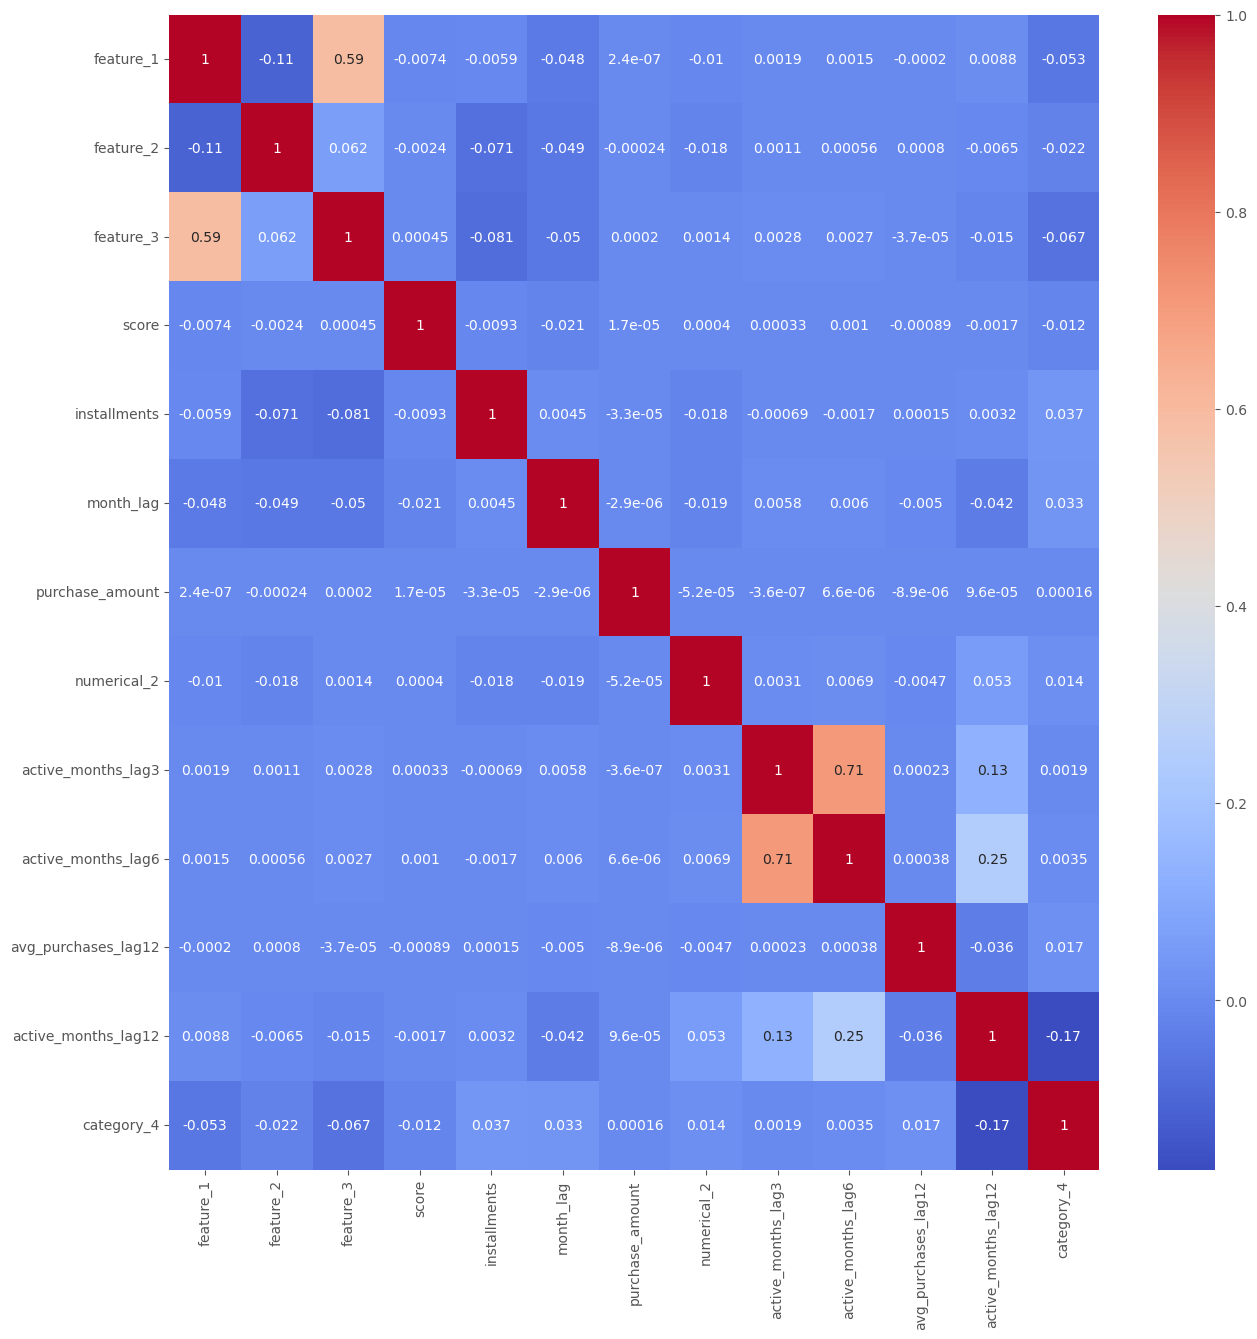

In [ ]:
# Calculate the correlation matrix
corr_matrix = numerical_features.corr()

# Create a larger figure
plt.figure(figsize=(15, 15))

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

# Show the plot
plt.show()

### **loyalty score**

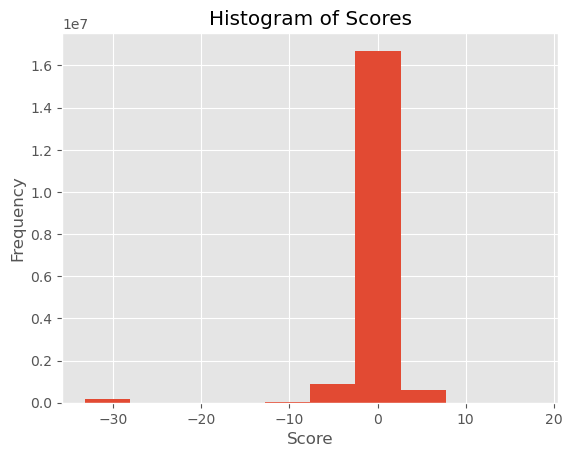

In [ ]:
# Draw a histogram of the "score" column
df2['score'].hist()

# Set the title and axis labels
plt.title('Histogram of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Show the plot
plt.show()

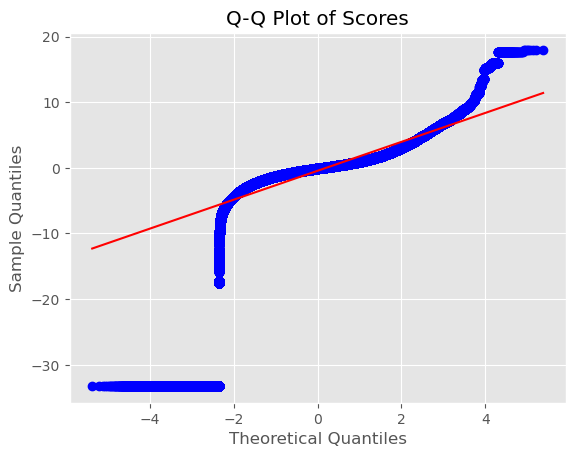

In [ ]:
# Generate a Q-Q plot for the "score" column
stats.probplot(df2['score'], plot=plt)

# Set the title and axis labels
plt.title('Q-Q Plot of Scores')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Show the plot
plt.show()

In [ ]:
# Count the values of the "score" column
counts = df2['score'].value_counts()

# Calculate the percentages of values in different ranges
total_count = len(df2)
range_a_count = len(df2.loc[(usersc_df['score'] >= -30) & (df2['score'] < -10)])
range_b_count = len(df2.loc[(usersc_df['score'] >= -10) & (df2['score'] < 0)])
range_c_count = len(df2.loc[(usersc_df['score'] >= 0) & (df2['score'] <= 10)])
range_d_count = len(df2.loc[(usersc_df['score'] > -1) & (df2['score'] < 1)])
range_e_count = len(df2.loc[(usersc_df['score'] >= -1) & (df2['score'] < 0)])
range_f_count = len(df2.loc[(usersc_df['score'] >= 0) & (df2['score'] <= 1)])
range_a_percent = range_a_count / total_count * 100
range_b_percent = range_b_count / total_count * 100
range_c_percent = range_c_count / total_count * 100
range_d_percent = range_d_count / total_count * 100
range_e_percent = range_e_count / total_count * 100
range_f_percent = range_f_count / total_count * 100

# Print the results
print('Value Counts:')
print(counts)
print('Percentages:')
print('Values between -30 and -10:', round(range_a_percent, 2), '%')
print('Values between -10 and 0:', round(range_b_percent, 2), '%')
print('Values between 0 and 10:', round(range_c_percent, 2), '%')
print('Values between -1 and 1:', round(range_d_percent, 2), '%')
print('Values between -1 and 0:', round(range_e_percent, 2), '%')
print('Values between 0 and 1:', round(range_f_percent, 2), '%')

Value Counts:
score
-33.2192809500    171148
0.0000000000       46199
1.0000000000        3127
-1.0000000000       2208
-1.2297522500       1939
                   ...  
-0.8492892000          3
-0.4624656800          2
1.7256922400           2
0.8434844000           2
0.8015812400           2
Name: count, Length: 197110, dtype: int64
Percentages:
Values between -30 and -10: 0.01 %
Values between -10 and 0: 0.52 %
Values between 0 and 10: 0.49 %
Values between -1 and 1: 0.67 %
Values between -1 and 0: 0.41 %
Values between 0 and 1: 0.42 %


In [ ]:
# Calculate the number of values below -30
num_below_30 = len(df2.loc[df2['score'] < -30])

# Calculate the percentage of values below -30
percentage_below_30 = (num_below_30 / len(df2)) * 100

# Calculate the number of values over -30
num_over_30 = len(df2.loc[df2['score'] >= -30])

# Calculate the percentage of values over -30
percentage_over_30 = (num_over_30 / len(df2)) * 100

# Print the results
print(f'Number of values below -30: {num_below_30}')
print(f'Percentage of values below -30: {percentage_below_30:.2f}%')
print(f'Number of values over or equal to -30: {num_over_30}')
print(f'Percentage of values over or equal to -30: {percentage_over_30:.2f}%')

Number of values below -30: 171148
Percentage of values below -30: 0.93%
Number of values over or equal to -30: 18224525
Percentage of values over or equal to -30: 99.07%


#### **1-hypothesis test**

**Two-sample t-test to compare mean purchase amount for high and low loyalty score cardholders**

**Motivation:** We want to test the hypothesis that the average purchase amount made by cardholders is significantly related to their loyalty score. Specifically, we want to see if cardholders with high loyalty scores have a significantly different average purchase amount compared to cardholders with low loyalty scores.

**Null hypothesis:** The mean purchase amount for cardholders with high and low loyalty scores is not significantly different.


**Hypothesis test:** We can perform a two-sample t-test with unequal variances to compare the mean purchase amount for the two groups. The test will provide a p-value that indicates the probability of observing a difference in means as extreme as the observed difference, assuming that the null hypothesis is true.


In [ ]:
# Group cardholders based on median loyalty score
high_loyalty_group = df2[df2['score'] >= df2['score'].median()]
low_loyalty_group = df2[df2['score'] < df2['score'].median()]

# Perform two-sample t-test
t, p = stats.ttest_ind(high_loyalty_group['purchase_amount'],
                       low_loyalty_group['purchase_amount'], equal_var=False)

print('t-statistic:', t)
print('p-value:', p)

t-statistic: 1.0460719664868352
p-value: 0.29552783427523377


After performs a two-sample t-test to compare the purchase amount between two groups of cardholders based on their median loyalty score. The null hypothesis is that there is no difference in the mean purchase amount between the two groups, while the alternative hypothesis is that there is a difference.

The output shows that the t-statistic is 1.046 and the p-value is 0.296. Since the p-value is greater than 0.05, we fail to reject the null hypothesis and conclude that there is no significant difference in the mean purchase amount between the two groups at the 5% significance level.

Overall, this suggests that the loyalty score may not be a good predictor of the purchase amount, or that other factors may be influencing the purchase behavior of these cardholders.

#### **2-hypothesis test**

**Motivation:** Does the average purchase amount differ significantly between customers who have made purchases in the most recent sales range (range A) and customers who have not made purchases in the most recent sales range (range B)? This test is interesting because it can help us understand the impact of the most recent sales range on purchase behavior.

**Null Hypothesis:** The average purchase amount is the same for customers in range A and customers in range B.

**Statistical Test:** Two-sample t-test with unequal variances.

In [ ]:
# Separate the data for customers in range A and customers in range B
range_a_data = df2[df2['most_recent_purchases_range'] == 'A']['purchase_amount']
range_b_data = df2[df2['most_recent_purchases_range'] != 'A']['purchase_amount']

# Perform two-sample t-test
t, p = stats.ttest_ind(range_a_data, range_b_data, equal_var=False)

# Check the results
alpha = 0.05
if p < alpha:
    print('There is a significant difference in the mean purchase amount between range A and range B.')
else:
    print('There is no significant difference in the mean purchase amount between range A and range B.')
    
print('t-statistic:', t)
print('p-value:', p)

There is no significant difference in the mean purchase amount between range A and range B.
t-statistic: -1.568095592562088
p-value: 0.11685884927185056


the results of the two-sample t-test, we can conclude that there is no statistically significant difference in the mean purchase amount between customers in range A and customers in range B, with a p-value of 0.117 which is greater than the significance level of 0.05. Therefore, we fail to reject the null hypothesis that the mean purchase amount is the same for both groups.

However, it's important to note that the p-value is relatively close to the significance level, so there may be a small effect that we are not able to detect with this sample size. Additionally, there may be other factors that influence purchase behavior beyond the most recent purchases range, so further analysis may be needed to fully understand the relationship between these variables.

#### **3-hypothesis test**

**Motivation:** Is there a significant difference in the average active months (lag 3) between customers with category 1 and customers without category 1? This test is interesting because it can help us understand the impact of category 1 on customer activity.

**Null Hypothesis:** The average active months (lag 3) is the same for customers with category 1 and customers without category 1.

**Statistical Test:** Two-sample t-test with unequal variances.

In [ ]:
# Separate the data for customers with category 1 and customers without category 1
cat_1_data = df2[df2['category_1'] == 'Y']['active_months_lag3']
no_cat_1_data = df2[df2['category_1'] == 'N']['active_months_lag3']

# Perform two-sample t-test
t, p = stats.ttest_ind(cat_1_data, no_cat_1_data, equal_var=False)

# Check the results
alpha = 0.05
if p < alpha:
    print('There is a significant difference in the mean active months (lag 3) between customers with category 1 and customers without category 1.')
else:
    print('There is no significant difference in the mean active months (lag 3) between customers with category 1 and customers without category 1.')
    
print('t-statistic:', t)
print('p-value:', p)

There is a significant difference in the mean active months (lag 3) between customers with category 1 and customers without category 1.
t-statistic: 10.319942546971225
p-value: 5.729459318701527e-25


the results of the two-sample t-test, we can conclude that there is a statistically significant difference in the mean active months (lag 3) between customers with category 1 and customers without category 1, with a very small p-value of 5.7e-25 which is much smaller than the significance level of 0.05. Therefore, we reject the null hypothesis that the mean active months (lag 3) is the same for both groups.

The t-statistic of 10.32 indicates that the difference between the mean active months (lag 3) for the two groups is large relative to the variability within each group.

In [ ]:
#Drop unnecessary columns after merging
df2.drop(['card_id'], axis=1, inplace=True)
final_df_copy.drop(['card_id'], axis=1, inplace=True)

## Model after handle nulls and before handle mutilcolinearity

### **Apply Standerscaler**

In [ ]:
# Split the data into features (X) and target variable (y)
X = final_df_copy.drop('score', axis=1)
y = final_df_copy['score']

# Define categorical and numerical variables
cat_vars = X.select_dtypes(include='object').columns.tolist()
num_vars = X.select_dtypes(include='number').columns.tolist()

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_vars),
        ('cat', OneHotEncoder(drop='first'), cat_vars)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

**Linear Regression**

In [ ]:
# Define the pipeline1
pipeline1 = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


# Fit the pipeline to the training data
pipeline1.fit(X_train, y_train)

# Generate predictions for the testing data
y_pred = pipeline1.predict(X_test)

# Evaluate the performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared value:", r2)

Mean Squared Error (MSE): 12.351344632088336
Root Mean Squared Error (RMSE): 3.514447983978186
R-squared value: 0.002836370185403281


**LGBM Regressor**

In [ ]:
# Define the hyperparameters for the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'n_estimators': 100
}

# Define the pipeline2 with LightGBM as the regressor
pipeline2 = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor',LGBMRegressor(**params))
])


# Fit the pipeline to the training data
pipeline2.fit(X_train, y_train)

# Generate predictions for the testing data
y_pred = pipeline2.predict(X_test)

# Evaluate the performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared value:", r2)

Mean Squared Error (MSE): 12.133563516057768
Root Mean Squared Error (RMSE): 3.483326501500795
R-squared value: 0.020418537523033242


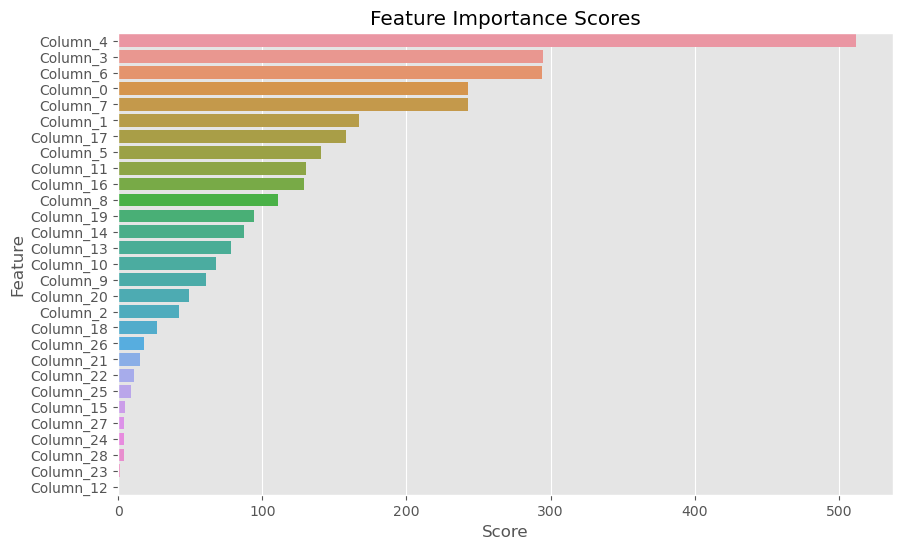

In [ ]:
# Extract the LightGBM model from the pipeline
lgbm_regressor = pipeline2.named_steps['regressor']

# Extract feature importance scores
importance_scores = lgbm_regressor.feature_importances_

# Get feature names sorted by importance score
feature_names = lgbm_regressor.booster_.feature_name()
sorted_indices = importance_scores.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot feature importance scores
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_scores[sorted_indices], y=sorted_feature_names)
plt.title('Feature Importance Scores')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()

### **Apply RobustScaler**

**Linear Regression**

In [ ]:
# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_vars),
        ('cat', OneHotEncoder(drop='first'), cat_vars)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# Define the pipeline3
pipeline3 = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


# Fit the pipeline to the training data
pipeline3.fit(X_train, y_train)

# Generate predictions for the testing data
y_pred = pipeline3.predict(X_test)

# Evaluate the performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared value:", r2)

Mean Squared Error (MSE): 12.351344632088335
Root Mean Squared Error (RMSE): 3.5144479839781857
R-squared value: 0.002836370185403392


**LGBM Regressor**

In [ ]:
# Define the hyperparameters for the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'n_estimators': 100
}

# Define the pipeline with LightGBM as the regressor
pipeline4 = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor',LGBMRegressor(**params))
])


# Fit the pipeline to the training data
pipeline4.fit(X_train, y_train)

# Generate predictions for the testing data
y_pred = pipeline4.predict(X_test)

# Evaluate the performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared value:", r2)

Mean Squared Error (MSE): 12.132199441187119
Root Mean Squared Error (RMSE): 3.483130695392741
R-squared value: 0.02052866365827377


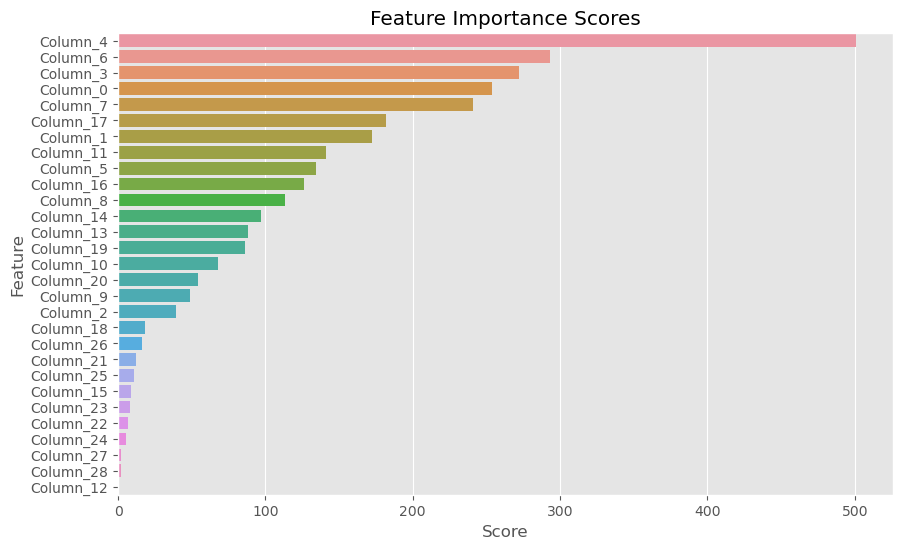

In [ ]:
# Extract the LightGBM model from the pipeline
lgbm_regressor = pipeline4.named_steps['regressor']

# Extract feature importance scores
importance_scores = lgbm_regressor.feature_importances_

# Get feature names sorted by importance score
feature_names = lgbm_regressor.booster_.feature_name()
sorted_indices = importance_scores.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot feature importance scores
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_scores[sorted_indices], y=sorted_feature_names)
plt.title('Feature Importance Scores')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()

## Model after handle nulls and mutilcolinearity

### **Apply Standerscaler**

In [ ]:
# Split the data into features (X) and target variable (y)
X = df2.drop('score', axis=1)
y = df2['score']

# Define categorical and numerical variables
cat_vars = X.select_dtypes(include='object').columns.tolist()
num_vars = X.select_dtypes(include='number').columns.tolist()

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_vars),
        ('cat', OneHotEncoder(drop='first'), cat_vars)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

**Linear Regression**

In [ ]:
# Define the pipeline1
pipeline5 = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


# Fit the pipeline to the training data
pipeline5.fit(X_train, y_train)

# Generate predictions for the testing data
y_pred = pipeline5.predict(X_test)

# Evaluate the performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared value:", r2)

Mean Squared Error (MSE): 12.352246762035291
Root Mean Squared Error (RMSE): 3.5145763275301465
R-squared value: 0.0027635383440721695


**LGBM Regressor**

In [ ]:
# Define the hyperparameters for the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'n_estimators': 100
}

# Define the pipeline2 with LightGBM as the regressor
pipeline6 = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor',LGBMRegressor(**params))
])


# Fit the pipeline to the training data
pipeline6.fit(X_train, y_train)

# Generate predictions for the testing data
y_pred = pipeline6.predict(X_test)

# Evaluate the performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared value:", r2)

Mean Squared Error (MSE): 12.148097164157067
Root Mean Squared Error (RMSE): 3.4854120508423487
R-squared value: 0.01924518954151122


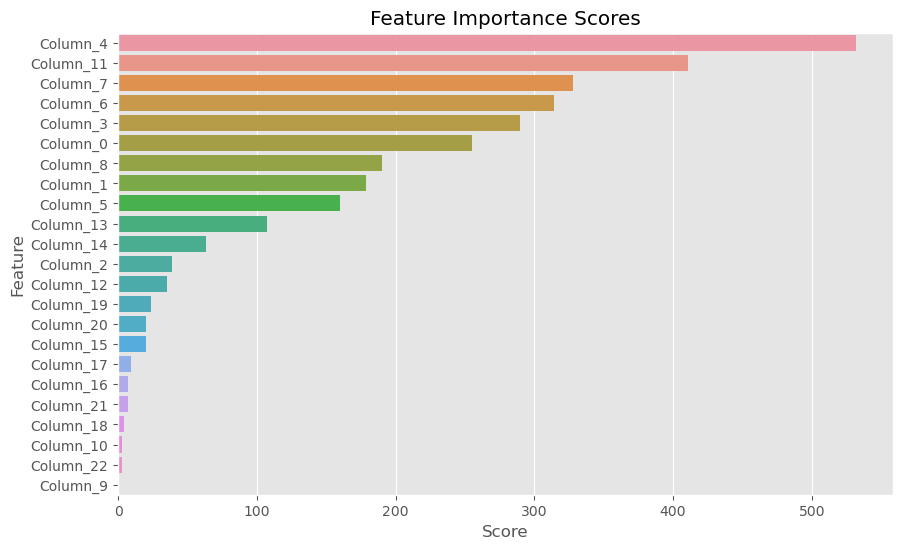

In [ ]:
# Extract the LightGBM model from the pipeline
lgbm_regressor = pipeline6.named_steps['regressor']

# Extract feature importance scores
importance_scores = lgbm_regressor.feature_importances_

# Get feature names sorted by importance score
feature_names = lgbm_regressor.booster_.feature_name()
sorted_indices = importance_scores.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot feature importance scores
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_scores[sorted_indices], y=sorted_feature_names)
plt.title('Feature Importance Scores')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()

### **Apply RobustScaler**

**Linear Regression**

In [ ]:
# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_vars),
        ('cat', OneHotEncoder(drop='first'), cat_vars)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# Define the pipeline3
pipeline7 = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


# Fit the pipeline to the training data
pipeline7.fit(X_train, y_train)

# Generate predictions for the testing data
y_pred = pipeline7.predict(X_test)

# Evaluate the performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared value:", r2)

Mean Squared Error (MSE): 12.35224676203529
Root Mean Squared Error (RMSE): 3.514576327530146
R-squared value: 0.0027635383440723915


**LGBM Regressor**

In [ ]:
# Define the hyperparameters for the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'n_estimators': 100
}

# Define the pipeline with LightGBM as the regressor
pipeline8 = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor',LGBMRegressor(**params))
])


# Fit the pipeline to the training data
pipeline8.fit(X_train, y_train)

# Generate predictions for the testing data
y_pred = pipeline8.predict(X_test)

# Evaluate the performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared value:", r2)

Mean Squared Error (MSE): 12.150820067940584
Root Mean Squared Error (RMSE): 3.485802643286132
R-squared value: 0.019025360794011514


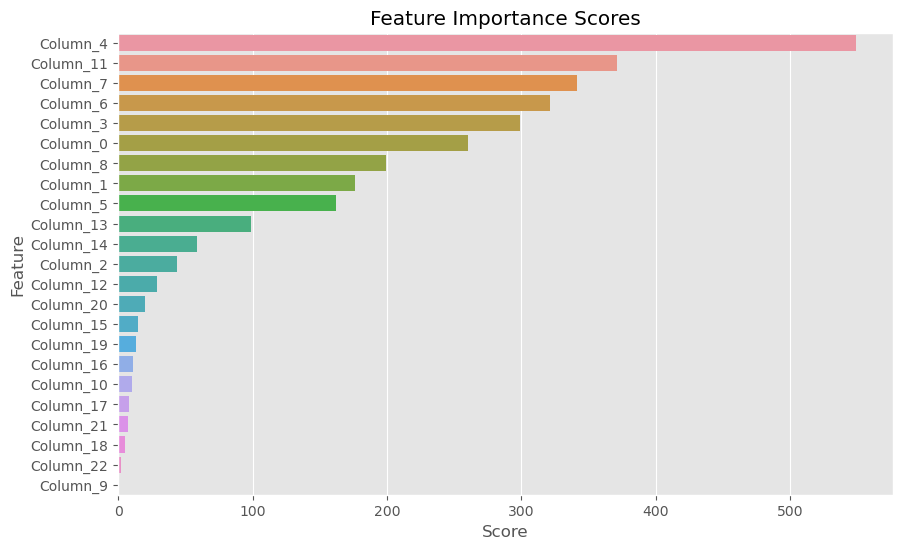

In [ ]:
# Extract the LightGBM model from the pipeline
lgbm_regressor = pipeline8.named_steps['regressor']

# Extract feature importance scores
importance_scores = lgbm_regressor.feature_importances_

# Get feature names sorted by importance score
feature_names = lgbm_regressor.booster_.feature_name()
sorted_indices = importance_scores.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot feature importance scores
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_scores[sorted_indices], y=sorted_feature_names)
plt.title('Feature Importance Scores')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()

In [ ]:
# Save the resulting DataFrame as a CSV file
final_df_copy.to_csv('final_df_copy.csv', index=False)

In [ ]:
# Save the resulting DataFrame as a CSV file
df2.to_csv('df2.csv', index=False)

- the models do not perform very well, as evidenced by the high MSE and RMSE values. 
- The R-squared values are also very low, indicating that the models explain very little of the variance in the data. 
- The LGBM Regressor performs slightly better than the Linear Regression model, but the differences are not very significant. 
- The choice of scaler (StandardScaler vs. RobustScaler) does not seem to have a large impact on the performanceof the models.
- Additionally, handling multicollinearity doesn't seem to have a significant effect on the performance of the models.

# **Feature Selection**

In [ ]:
# Load the dataset
df = pd.read_csv('final_df_copy.csv')

In [ ]:
df.head()

feature_1  feature_2  feature_3         score  year  month  installments   
0          5          2          1 -0.8202826000  2017      6             0  \
1          5          2          1 -0.8202826000  2017      6             0   
2          5          2          1 -0.8202826000  2017      6             0   
3          5          2          1 -0.8202826000  2017      6             0   
4          5          2          1 -0.8202826000  2017      6             0   

   month_lag  purchase_amount   numerical_1  ...  avg_sales_lag3   
0          0    -0.7078989700 -0.0475557500  ...    6.9300000000  \
1          0    -0.7078989700 -0.0574706500  ...    0.9300000000   
2         -2    -0.6417222100 -0.0475557500  ...    6.9300000000   
3         -2    -0.6417222100 -0.0574706500  ...    0.9300000000   
4          0    -0.7348865900 -0.0475557500  ...    6.9300000000   

  avg_purchases_lag3 active_months_lag3 avg_sales_lag6  avg_purchases_lag6   
0      12.7051282100       3.0000000000   8.4200000000       15.8557692300  \
1       0.9492884200       3.0000000000   0.8600000000        0.8712141400   
2      12.7051282100       3.0000000000   8.4200000000       15.8557692300   
3       0.9492884200       3.0000000000   0.8600000000        0.8712141400   
4      12.7051282100       3.0000000000   8.4200000000       15.8557692300   

   active_months_lag6  avg_sales_lag12  avg_purchases_lag12   
0        6.0000000000     8.5700000000        16.2197802200  \
1        6.0000000000     0.7600000000         0.7526406600   
2        6.0000000000     8.5700000000        16.2197802200   
3        6.0000000000     0.7600000000         0.7526406600   
4        6.0000000000     8.5700000000        16.2197802200   

   active_months_lag12   category_4  
0         7.0000000000 1.0000000000  
1        12.0000000000 1.0000000000  
2         7.0000000000 1.0000000000  
3        12.0000000000 1.0000000000  
4         7.0000000000 1.0000000000  

[5 rows x 24 columns]

In [ ]:
df['category_1'].nunique()

2

In [ ]:
df['most_recent_sales_range'].nunique()

5

In [ ]:
df['most_recent_sales_range'].unique()

array(['E', 'A', 'B', 'C', 'D'], dtype=object)

In [ ]:
df['most_recent_purchases_range'].nunique()

5

In [ ]:
df['most_recent_purchases_range'].unique()

array(['E', 'A', 'C', 'B', 'D'], dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7107097 entries, 0 to 7107096
Data columns (total 24 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   feature_1                    int64  
 1   feature_2                    int64  
 2   feature_3                    int64  
 3   score                        float64
 4   year                         int64  
 5   month                        int64  
 6   installments                 int64  
 7   month_lag                    int64  
 8   purchase_amount              float64
 9   numerical_1                  float64
 10  numerical_2                  float64
 11  category_1                   object 
 12  most_recent_sales_range      object 
 13  most_recent_purchases_range  object 
 14  avg_sales_lag3               float64
 15  avg_purchases_lag3           float64
 16  active_months_lag3           float64
 17  avg_sales_lag6               float64
 18  avg_purchases_lag6           float64
 19  

In [ ]:
df.isna().sum()

feature_1                      0
feature_2                      0
feature_3                      0
score                          0
year                           0
month                          0
installments                   0
month_lag                      0
purchase_amount                0
numerical_1                    0
numerical_2                    0
category_1                     0
most_recent_sales_range        0
most_recent_purchases_range    0
avg_sales_lag3                 0
avg_purchases_lag3             0
active_months_lag3             0
avg_sales_lag6                 0
avg_purchases_lag6             0
active_months_lag6             0
avg_sales_lag12                0
avg_purchases_lag12            0
active_months_lag12            0
category_4                     0
dtype: int64

In [ ]:
# Use pd.get_dummies() to one-hot encode the categorical variables
encoded_df = pd.get_dummies(df)

In [ ]:
# Split the data into features (X) and target variable (y)
X = encoded_df.drop('score', axis=1)
y = encoded_df['score']

# Split the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)

In [ ]:
 encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7107097 entries, 0 to 7107096
Data columns (total 33 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   feature_1                      int64  
 1   feature_2                      int64  
 2   feature_3                      int64  
 3   score                          float64
 4   year                           int64  
 5   month                          int64  
 6   installments                   int64  
 7   month_lag                      int64  
 8   purchase_amount                float64
 9   numerical_1                    float64
 10  numerical_2                    float64
 11  avg_sales_lag3                 float64
 12  avg_purchases_lag3             float64
 13  active_months_lag3             float64
 14  avg_sales_lag6                 float64
 15  avg_purchases_lag6             float64
 16  active_months_lag6             float64
 17  avg_sales_lag12                float64
 18  av

In [ ]:
# Define the LightGBM regressor model
lgbm_regressor = LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100)

# Train the LightGBM regressor model
lgbm_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lgbm_regressor.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")

Mean squared error: 12.172583637055592


In [ ]:
# Extract feature importance scores
importance_scores = lgbm_regressor.feature_importances_

# Get feature names sorted by importance score
feature_names = lgbm_regressor.booster_.feature_name()
sorted_indices = importance_scores.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Print top 10 important feature names
num_features = 20
print(f"Top {num_features} important features:")
for i in range(num_features):
    print(f"{i+1}. {sorted_feature_names[i]}")

Top 20 important features:
1. month
2. purchase_amount
3. month_lag
4. year
5. feature_1
6. avg_purchases_lag12
7. feature_2
8. avg_sales_lag12
9. numerical_1
10. avg_purchases_lag3
11. category_4
12. avg_purchases_lag6
13. installments
14. avg_sales_lag6
15. avg_sales_lag3
16. numerical_2
17. category_1_N
18. feature_3
19. most_recent_purchases_range_A
20. most_recent_sales_range_B


In [ ]:
# Define X_train_top and X_test_top with top 15 features
num_features = 15
top_feature_names = sorted_feature_names[:num_features]
X_train_top = X_train[top_feature_names]
X_test_top = X_test[top_feature_names]

LGBMRegressor ✓ 5180.08 sec
{'Algorithm': 'LGBMRegressor', 'Train_Score': 0.04307295091369956, 'Test_Score': 0.03926457610612777, 'Train_Rmse': 3.4684553207127293, 'Test_Rmse': 3.4946581528296767, 'Train_Mae': 1.3890101203648493, 'Test_Mae': 1.393357790644985}


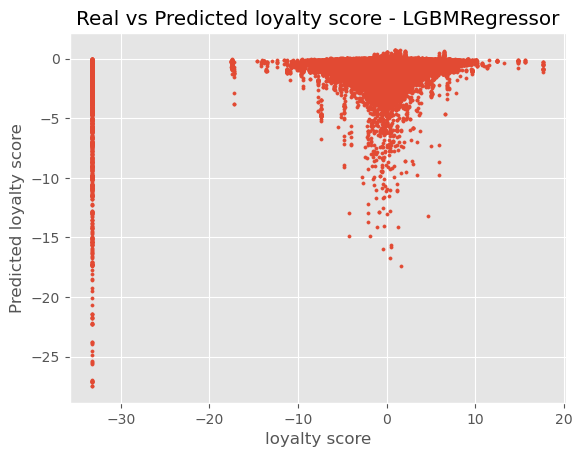

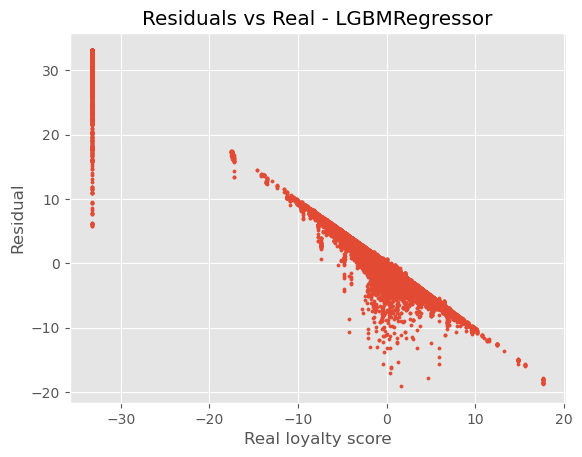

In [ ]:
# Initialize the pipeline with the scaler and model
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('model', LGBMRegressor())
])

# Fit the pipeline to the training data
start_time = time.process_time()
pipeline.fit(X_train_top, y_train)

# Calculate various performance metrics and store them in a dictionary
metrics = {
    'Algorithm': 'LGBMRegressor',
    'Train_Score': pipeline.score(X_train_top, y_train),
    'Test_Score': pipeline.score(X_test_top, y_test),
    'Train_Rmse': np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train_top))),
    'Test_Rmse': np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test_top))),
    'Train_Mae': mean_absolute_error(y_train, pipeline.predict(X_train_top)),
    'Test_Mae': mean_absolute_error(y_test, pipeline.predict(X_test_top))
}

# Print the algorithm name and the time taken to fit the model
print('{} ✓ {:.2f} sec'.format('LGBMRegressor', time.process_time()-start_time))

# Print the performance metrics
print(metrics)

# Plot the predicted vs actual values and the residuals vs actual values
plt.scatter(y_test, pipeline.predict(X_test_top), s=5)
plt.xlabel('loyalty score')
plt.ylabel('Predicted loyalty score')
plt.title('Real vs Predicted loyalty score - LGBMRegressor')
plt.show()

plt.scatter(y_test, pipeline.predict(X_test_top)-y_test, s=5)
plt.xlabel('Real loyalty score')
plt.ylabel('Residual')
plt.title('Residuals vs Real - LGBMRegressor')
plt.show()

**the results from the LGBMRegressor model:**

- The training and test scores (R^2) were 0.04307295091369956 and 0.03926457610612777, respectively.
- The root mean squared error (RMSE) was 3.4684553207127293 for the training data and 3.4946581528296767 for the test data.
- The mean absolute error (MAE) was 1.3890101203648493 for the training data and 1.393357790644985 for the test data.
- The difference between the training and test scores, RMSE, and MAE is small, indicating that the model is not overfitting to the training data.

Time Taken: 5110.27 sec